In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import json

In [2]:
%matplotlib inline

In [93]:
with open("output_data/all_data_final_updated_East Midlands.json", "r") as f:
    data = json.loads(f.read())

In [94]:
data[0]

{'OA21CD': 'E00067991',
 'RGN22NM': 'East Midlands',
 'amenities': [{'name': 'N/A',
   'amenity': 'waste_basket',
   'data_type': 'node',
   'lat': '52.9558306',
   'lon': '-1.4727300',
   'other_tags': {'amenity': 'waste_basket'}},
  {'name': 'N/A',
   'amenity': 'waste_basket',
   'data_type': 'node',
   'lat': '52.9557861',
   'lon': '-1.4729285',
   'other_tags': {'amenity': 'waste_basket'}}]}

## Per Parish data

Per parish, we want to know:

- The population
- The size
- The facilities
- The IMD
- Whether it is rural or urban

Right now, we have data on:

- The population (at OA level)
- The size (at OA level)
- The facilities (at OA level)
- The IMD (at LSOA level in 2011!)
- Whether it is rural or urban (at OA level in 2011)

Given a lookup between OA and parish, we can get the population, size and facilities relatively easily. Let's do that first.

### Convert OA to Parish

In [29]:
oa_to_parish_lookup = pd.read_csv('data/OAs_(2021)_to_Civil_Parish_and_Non-Civil_Parished_Areas_to_LTLA_to_UTLA_to_Region_to_Country_(May_2022)_Lookup_in_England_and_Wales.csv')
oa_to_parish_lookup.head()

/var/folders/zs/1hvc18dn7v94z77k1xy7g90c0000gn/T/ipykernel_18487/1533396775.py:1: DtypeWarning: Columns (4,7,10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  oa_to_parish_lookup = pd.read_csv('data/OAs_(2021)_to_Civil_Parish_and_Non-Civil_Parished_Areas_to_LTLA_to_UTLA_to_Region_to_Country_(May_2022)_Lookup_in_England_and_Wales.csv')


ObjectId     OA21CD    PAR22CD        PAR22NM PAR22NMW   LTLA22CD  \
0         1  E00060311  E04000255  Dalton Piercy      NaN  E06000001   
1         2  E00060356  E04000257       Greatham      NaN  E06000001   
2         3  E00060360  E04000257       Greatham      NaN  E06000001   
3         4  E00060357  E04000257       Greatham      NaN  E06000001   
4         5  E00060359  E04000257       Greatham      NaN  E06000001   

     LTLA22NM LTLA22NMW   UTLA22CD    UTLA22NM UTLA22NMW    RGN22CD  \
0  Hartlepool       NaN  E06000001  Hartlepool       NaN  E12000001   
1  Hartlepool       NaN  E06000001  Hartlepool       NaN  E12000001   
2  Hartlepool       NaN  E06000001  Hartlepool       NaN  E12000001   
3  Hartlepool       NaN  E06000001  Hartlepool       NaN  E12000001   
4  Hartlepool       NaN  E06000001  Hartlepool       NaN  E12000001   

      RGN22NM RGN22NMW   CTRY22CD CTRY22NM CTRY22NMW    NAT22CD  \
0  North East      NaN  E92000001  England    Lloegr  K04000001   
1  North East      NaN  E92000001  England    Lloegr  K04000001   
2  North East      NaN  E92000001  England    Lloegr  K04000001   
3  North East      NaN  E92000001  England    Lloegr  K04000001   
4  North East      NaN  E92000001  England    Lloegr  K04000001   

             NAT22NM        NAT22NMW  
0  England and Wales  Cymru a Lloegr  
1  England and Wales  Cymru a Lloegr  
2  England and Wales  Cymru a Lloegr  
3  England and Wales  Cymru a Lloegr  
4  England and Wales  Cymru a Lloegr

In [30]:
oa_to_parish_lookup.shape

(188880, 20)

In [31]:
oa_to_parish_lookup = oa_to_parish_lookup[[
    'OA21CD',
    'PAR22CD',
    'PAR22NM',
    'RGN22NM'
]]

oa_to_parish_lookup.head()

OA21CD    PAR22CD        PAR22NM     RGN22NM
0  E00060311  E04000255  Dalton Piercy  North East
1  E00060356  E04000257       Greatham  North East
2  E00060360  E04000257       Greatham  North East
3  E00060357  E04000257       Greatham  North East
4  E00060359  E04000257       Greatham  North East

In [32]:
oa_populations = pd.read_csv('data/census2021-ts001-oa.csv')
oa_populations.head()

date  geography geography code  Residence type: Total; measures: Value  \
0  2021  E00060274      E00060274                                     273   
1  2021  E00060275      E00060275                                     416   
2  2021  E00060276      E00060276                                     259   
3  2021  E00060277      E00060277                                     278   
4  2021  E00060279      E00060279                                     276   

   Residence type: Lives in a household; measures: Value  \
0                                                273       
1                                                416       
2                                                259       
3                                                278       
4                                                276       

   Residence type: Lives in a communal establishment; measures: Value  
0                                                  0                   
1                                                  0                   
2                                                  0                   
3                                                  0                   
4                                                  0

In [128]:
oa_total_frame = oa_to_parish_lookup.merge(
    oa_populations[['geography code', 'Residence type: Total; measures: Value']], 
    how='inner', 
    left_on='OA21CD', 
    right_on='geography code')

oa_total_frame.head()
                    

OA21CD    PAR22CD        PAR22NM     RGN22NM geography code  \
0  E00060311  E04000255  Dalton Piercy  North East      E00060311   
1  E00060356  E04000257       Greatham  North East      E00060356   
2  E00060360  E04000257       Greatham  North East      E00060360   
3  E00060357  E04000257       Greatham  North East      E00060357   
4  E00060359  E04000257       Greatham  North East      E00060359   

   Residence type: Total; measures: Value  
0                                     312  
1                                     283  
2                                     274  
3                                     298  
4                                     274

In [129]:
oa_total_frame = oa_total_frame.rename(columns={'Residence type: Total; measures: Value': 'population'}, errors='raise')
oa_total_frame = oa_total_frame[[
    'OA21CD',
    'PAR22CD',
    'PAR22NM',
    'RGN22NM',
    'population'
]]

oa_total_frame.head()

OA21CD    PAR22CD        PAR22NM     RGN22NM  population
0  E00060311  E04000255  Dalton Piercy  North East         312
1  E00060356  E04000257       Greatham  North East         283
2  E00060360  E04000257       Greatham  North East         274
3  E00060357  E04000257       Greatham  North East         298
4  E00060359  E04000257       Greatham  North East         274

In [130]:
size_frame = pd.read_csv('geo_data/Output_Areas_Dec_2021_Boundaries_Full_Clipped_EW_BFC_2022_-340120420164038365.csv')
size_frame.head()

OBJECTID     OA21CD   Shape__Area  Shape__Length  \
0         1  E00000001   6707.003326     448.104925   
1         2  E00000003   4186.970726     341.814871   
2         3  E00000005   8736.115654     444.386357   
3         4  E00000007  73494.158020    1607.023365   
4         5  E00000010   2533.057602     259.046872   

                               GlobalID  
0  b6c81a78-d070-4324-a2e9-3522777aca9c  
1  9be984cf-6bdf-470b-bd01-16793c7135f5  
2  6460aa1d-b8b7-4062-a679-354a99d33f73  
3  de2b0475-c5b9-4aec-8804-43e3e21d54e2  
4  55b296f3-e208-41a6-a806-1a020ed907a5

In [131]:
oa_total_frame = oa_total_frame.merge(
    size_frame[['OA21CD', 'Shape__Area']],
    how='inner',
    on='OA21CD'
)
oa_total_frame = oa_total_frame.rename(
    columns={'Shape__Area': 'area'}, 
    errors='raise'
)

In [132]:
oa_total_frame.head()

OA21CD    PAR22CD        PAR22NM     RGN22NM  population          area
0  E00060311  E04000255  Dalton Piercy  North East         312  6.758443e+06
1  E00060356  E04000257       Greatham  North East         283  5.098650e+05
2  E00060360  E04000257       Greatham  North East         274  6.863565e+04
3  E00060357  E04000257       Greatham  North East         298  3.589880e+05
4  E00060359  E04000257       Greatham  North East         274  6.126857e+04

In [127]:
import glob
to_include = list(set(glob.glob('output_data/all_data_final_updated_*.json')) - set(glob.glob('output_data/all_data_final_updated_errors*.json')))
region_frames = [pd.read_json(i) for i in to_include]
big_df = pd.concat(region_frames)
big_df.shape


(178605, 3)

In [133]:
oa_total_frame = oa_total_frame.merge(
    big_df[['OA21CD', 'amenities']],
    how='left',
    on='OA21CD'
)
oa_total_frame.head()

OA21CD    PAR22CD        PAR22NM     RGN22NM  population          area  \
0  E00060311  E04000255  Dalton Piercy  North East         312  6.758443e+06   
1  E00060356  E04000257       Greatham  North East         283  5.098650e+05   
2  E00060360  E04000257       Greatham  North East         274  6.863565e+04   
3  E00060357  E04000257       Greatham  North East         298  3.589880e+05   
4  E00060359  E04000257       Greatham  North East         274  6.126857e+04   

                                           amenities  
0  [{'name': 'N/A', 'amenity': 'post_box', 'data_...  
1  [{'name': 'The Bull and Dog', 'amenity': 'pub'...  
2                                                 []  
3  [{'name': 'N/A', 'amenity': 'waste_basket', 'd...  
4                                                 []

In [134]:
oa_total_frame.tail()

OA21CD    PAR22CD PAR22NM RGN22NM  population          area  \
188875  W00006941  W04000881  Vaynor   Wales         274  5.605059e+05   
188876  W00006932  W04000881  Vaynor   Wales         303  8.202506e+04   
188877  W00006935  W04000881  Vaynor   Wales         211  6.634248e+04   
188878  W00006940  W04000881  Vaynor   Wales         422  2.768095e+05   
188879  W00006934  W04000881  Vaynor   Wales         293  3.034093e+06   

       amenities  
188875       NaN  
188876       NaN  
188877       NaN  
188878       NaN  
188879       NaN

In [135]:
## drop Wales
drop_wales = oa_total_frame[oa_total_frame.RGN22NM != 'Wales']
drop_wales.shape

(178605, 7)

In [136]:
drop_wales[pd.isnull(drop_wales.amenities)].groupby(['RGN22NM']).size()

Series([], dtype: int64)

In [140]:
oa_to_parish_lookup.groupby(['RGN22NM']).size()

RGN22NM
East Midlands               15393
East of England             19972
London                      26369
North East                   9100
North West                  24050
South East                  28969
South West                  18427
Wales                       10275
West Midlands               18584
Yorkshire and The Humber    17741
dtype: int64

In [139]:
drop_wales.groupby(['RGN22NM']).size()

RGN22NM
East Midlands               15393
East of England             19972
London                      26369
North East                   9100
North West                  24050
South East                  28969
South West                  18427
West Midlands               18584
Yorkshire and The Humber    17741
dtype: int64

In [143]:
drop_wales.head()

OA21CD    PAR22CD        PAR22NM     RGN22NM  population          area  \
0  E00060311  E04000255  Dalton Piercy  North East         312  6.758443e+06   
1  E00060356  E04000257       Greatham  North East         283  5.098650e+05   
2  E00060360  E04000257       Greatham  North East         274  6.863565e+04   
3  E00060357  E04000257       Greatham  North East         298  3.589880e+05   
4  E00060359  E04000257       Greatham  North East         274  6.126857e+04   

                                           amenities  
0  [{'name': 'N/A', 'amenity': 'post_box', 'data_...  
1  [{'name': 'The Bull and Dog', 'amenity': 'pub'...  
2                                                 []  
3  [{'name': 'N/A', 'amenity': 'waste_basket', 'd...  
4                                                 []

In [144]:
drop_wales.to_csv('data/oa_population_area_amenities.csv')

In [145]:
parish_frame = drop_wales[['PAR22CD', 'PAR22NM', 'RGN22NM', 'population', 'area']].groupby(['PAR22CD', 'PAR22NM', 'RGN22NM']).agg('sum').reset_index()
parish_frame.head()

PAR22CD       PAR22NM     RGN22NM  population          area
0  E04000001      Blackrod  North West        5517  8.599134e+06
1  E04000002       Horwich  North West       20908  1.424275e+07
2  E04000003  Westhoughton  North West       25340  1.786415e+07
3  E04000005   Saddleworth  North West       25466  7.613353e+07
4  E04000008       Mossley  North West       11566  8.658747e+06

In [146]:
parish_frame.sort_values(by='population', ascending=False).head(10)

PAR22CD                            PAR22NM                   RGN22NM  \
9547  E43000250        Birmingham, unparished area             West Midlands   
9569  E43000276             Leeds, unparished area  Yorkshire and The Humber   
9477  E43000157        Manchester, unparished area                North West   
9490  E43000173         Sheffield, unparished area  Yorkshire and The Humber   
9485  E43000166         Liverpool, unparished area                North West   
9382  E43000019  Bristol, City of, unparished area                South West   
9508  E43000198           Croydon, unparished area                    London   
9503  E43000193            Barnet, unparished area                    London   
9378  E43000015         Leicester, unparished area             East Midlands   
9509  E43000199            Ealing, unparished area                    London   

      population          area  
9547     1040773  2.085932e+08  
9569      639331  2.514287e+08  
9477      551924  1.156455e+08  
9490      494678  1.846339e+08  
9485      486093  1.118441e+08  
9382      472446  1.096668e+08  
9508      390702  8.651926e+07  
9503      389348  8.673641e+07  
9378      368607  7.331395e+07  
9509      367092  5.552570e+07

In [147]:
parish_frame.sort_values(by='population', ascending=True).head(10)

PAR22CD            PAR22NM                   RGN22NM  population  \
6480  E04009303            Denston           East of England         100   
6083  E04008836   East Quantoxhead                South West         101   
7484  E04010831          Middleton                North East         101   
6093  E04008848         Monksilver                South West         102   
7463  E04010807        Hollinghill                North East         102   
5125  E04007406           Plompton  Yorkshire and The Humber         102   
7875  E04011403           Boconnoc                South West         102   
2332  E04003601              Swyre                South West         102   
1358  E04001838  Shingay cum Wendy           East of England         103   
3993  E04005762           West Fen             East Midlands         103   

              area  
6480  4.853327e+06  
6083  9.455905e+06  
7484  2.525922e+07  
6093  3.214719e+06  
7463  5.884271e+07  
5125  7.672632e+06  
7875  8.366349e+06  
2332  4.562940e+06  
1358  7.277571e+06  
3993  8.264972e+06

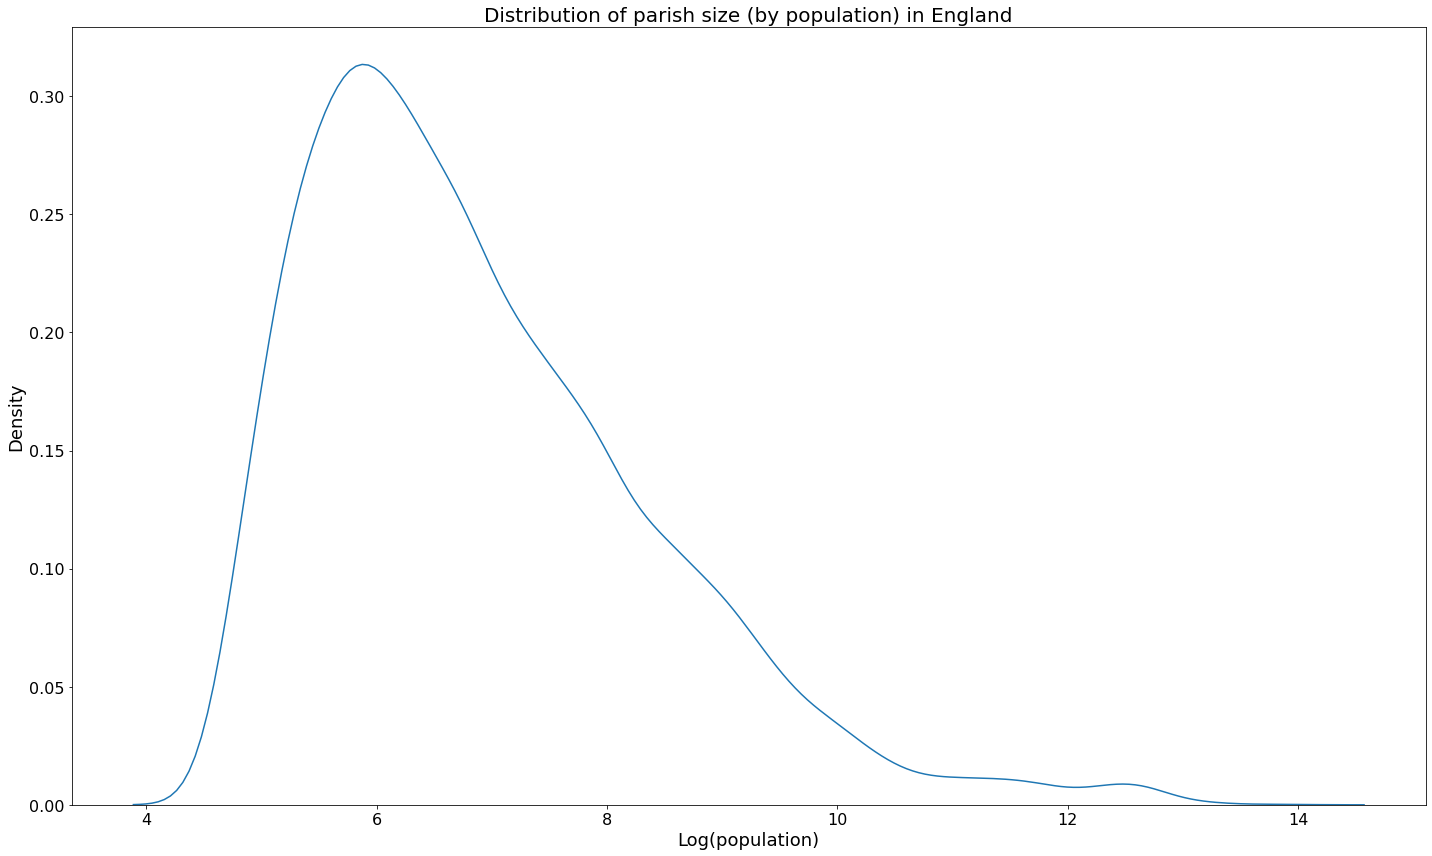

In [155]:
fig, ax = plt.subplots(figsize=(20,12))
sns.kdeplot(data=np.log(parish_frame.population))
plt.xlabel('Log(population)', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Density', fontsize=18)
plt.yticks(fontsize=16)
plt.title('Distribution of parish size (by population) in England', fontsize=20)
plt.tight_layout()
plt.savefig('results/parish_size_by_population.png')
plt.show()

## Adding on Rural/Urban classification

In [157]:
rural_urban_lookup = pd.read_csv('data/RUC11_OA11_EW.csv')
rural_urban_lookup.head()

OA11CD RUC11CD                    RUC11 BOUND_CHGIND ASSIGN_CHGIND  \
0  E00000001      A1  Urban major conurbation            U           NaN   
1  E00000003      A1  Urban major conurbation            U           NaN   
2  E00000005      A1  Urban major conurbation            U           NaN   
3  E00000007      A1  Urban major conurbation            U           NaN   
4  E00000010      A1  Urban major conurbation            U           NaN   

  ASSIGN_CHREASON  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN

In [158]:
oa11_oa21_lookup = pd.read_csv('data/OA_(2011)_to_OA_(2021)_to_Local_Authority_District_(2022)_for_England_and_Wales_Lookup_(Version_2).csv')
oa11_oa21_lookup.head()

/var/folders/zs/1hvc18dn7v94z77k1xy7g90c0000gn/T/ipykernel_18487/1732757884.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  oa11_oa21_lookup = pd.read_csv('data/OA_(2011)_to_OA_(2021)_to_Local_Authority_District_(2022)_for_England_and_Wales_Lookup_(Version_2).csv')


ObjectId     OA11CD     OA21CD CHNGIND    LAD22CD               LAD22NM  \
0         1  E00000124  E00000124       U  E09000002  Barking and Dagenham   
1         2  E00000125  E00000125       U  E09000002  Barking and Dagenham   
2         3  E00000128  E00000128       U  E09000002  Barking and Dagenham   
3         4  E00000129  E00000129       U  E09000002  Barking and Dagenham   
4         5  E00000130  E00000130       U  E09000002  Barking and Dagenham   

  LAD22NMW  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

In [159]:
rural_urban_lookup = rural_urban_lookup[['OA11CD', 'RUC11CD', 'RUC11']].merge(
    oa11_oa21_lookup[['OA11CD', 'OA21CD']],
    how='left',
    on='OA11CD'
)
rural_urban_lookup.head()

OA11CD RUC11CD                    RUC11     OA21CD
0  E00000001      A1  Urban major conurbation  E00000001
1  E00000003      A1  Urban major conurbation  E00000003
2  E00000005      A1  Urban major conurbation  E00000005
3  E00000007      A1  Urban major conurbation  E00000007
4  E00000010      A1  Urban major conurbation  E00000010

In [160]:
drop_wales.head()

OA21CD    PAR22CD        PAR22NM     RGN22NM  population          area  \
0  E00060311  E04000255  Dalton Piercy  North East         312  6.758443e+06   
1  E00060356  E04000257       Greatham  North East         283  5.098650e+05   
2  E00060360  E04000257       Greatham  North East         274  6.863565e+04   
3  E00060357  E04000257       Greatham  North East         298  3.589880e+05   
4  E00060359  E04000257       Greatham  North East         274  6.126857e+04   

                                           amenities  
0  [{'name': 'N/A', 'amenity': 'post_box', 'data_...  
1  [{'name': 'The Bull and Dog', 'amenity': 'pub'...  
2                                                 []  
3  [{'name': 'N/A', 'amenity': 'waste_basket', 'd...  
4                                                 []

In [161]:
with_rural = drop_wales.merge(
    rural_urban_lookup[[
        'OA21CD',
        'RUC11CD',
        'RUC11'
    ]],
    how='left',
    on='OA21CD'
)

with_rural.head()

OA21CD    PAR22CD        PAR22NM     RGN22NM  population          area  \
0  E00060311  E04000255  Dalton Piercy  North East         312  6.758443e+06   
1  E00060356  E04000257       Greatham  North East         283  5.098650e+05   
2  E00060360  E04000257       Greatham  North East         274  6.863565e+04   
3  E00060357  E04000257       Greatham  North East         298  3.589880e+05   
4  E00060359  E04000257       Greatham  North East         274  6.126857e+04   

                                           amenities RUC11CD  \
0  [{'name': 'N/A', 'amenity': 'post_box', 'data_...      E1   
1  [{'name': 'The Bull and Dog', 'amenity': 'pub'...      C1   
2                                                 []      C1   
3  [{'name': 'N/A', 'amenity': 'waste_basket', 'd...      D1   
4                                                 []      C1   

                   RUC11  
0          Rural village  
1    Urban city and town  
2    Urban city and town  
3  Rural town and fringe  
4    Urban city and town

In [166]:
with_rural.groupby(['RUC11'])[[ 'area']].describe()

area                \
                                                      count          mean   
RUC11                                                                       
Rural hamlets and isolated dwellings                 6055.0  8.612901e+06   
Rural hamlets and isolated dwellings in a spars...    533.0  2.408017e+07   
Rural town and fringe                               15455.0  4.986474e+05   
Rural town and fringe in a sparse setting             677.0  6.755757e+05   
Rural village                                        9442.0  3.594200e+06   
Rural village in a sparse setting                     560.0  7.883246e+06   
Urban city and town                                 77942.0  1.801583e+05   
Urban city and town in a sparse setting               309.0  3.200873e+05   
Urban major conurbation                             61842.0  8.642908e+04   
Urban minor conurbation                              6459.0  1.320435e+05   

                                                                  \
                                                             std   
RUC11                                                              
Rural hamlets and isolated dwellings                8.013448e+06   
Rural hamlets and isolated dwellings in a spars...  2.278767e+07   
Rural town and fringe                               1.271245e+06   
Rural town and fringe in a sparse setting           2.114947e+06   
Rural village                                       4.197805e+06   
Rural village in a sparse setting                   1.212237e+07   
Urban city and town                                 6.126136e+05   
Urban city and town in a sparse setting             1.003697e+06   
Urban major conurbation                             2.138449e+05   
Urban minor conurbation                             2.974184e+05   

                                                                   \
                                                              min   
RUC11                                                               
Rural hamlets and isolated dwellings                  8041.212532   
Rural hamlets and isolated dwellings in a spars...  120146.604691   
Rural town and fringe                                 8176.085709   
Rural town and fringe in a sparse setting            15904.477230   
Rural village                                        12769.463512   
Rural village in a sparse setting                    38411.565811   
Urban city and town                                    290.793518   
Urban city and town in a sparse setting              14198.348251   
Urban major conurbation                                201.248619   
Urban minor conurbation                                  0.039673   

                                                                  \
                                                             25%   
RUC11                                                              
Rural hamlets and isolated dwellings                3.852323e+06   
Rural hamlets and isolated dwellings in a spars...  1.110002e+07   
Rural town and fringe                               6.771172e+04   
Rural town and fringe in a sparse setting           7.333769e+04   
Rural village                                       6.080874e+05   
Rural village in a sparse setting                   1.003910e+06   
Urban city and town                                 4.338182e+04   
Urban city and town in a sparse setting             5.480465e+04   
Urban major conurbation                             2.843624e+04   
Urban minor conurbation                             4.245505e+04   

                                                                  \
                                                             50%   
RUC11                                                              
Rural hamlets and isolated dwellings                7.152737e+06   
Rural hamlets and isolated dwellings in a spars...  1.700971e+07   
Rural town and fringe                        

In [167]:
with_rural[['RUC11', 'RUC11CD']].drop_duplicates()

RUC11 RUC11CD
0                                          Rural village      E1
1                                    Urban city and town      C1
3                                  Rural town and fringe      D1
6                   Rural hamlets and isolated dwellings      F1
10042                            Urban minor conurbation      B1
10978  Rural hamlets and isolated dwellings in a spar...      F2
11072                  Rural village in a sparse setting      E2
11360            Urban city and town in a sparse setting      C2
11413          Rural town and fringe in a sparse setting      D2
20708                            Urban major conurbation      A1

In [168]:
official_rural_list = [
    'D1', 'E1', 'F1', 'D2', 'E2', 'F2'
]

with_rural.head()

OA21CD    PAR22CD        PAR22NM     RGN22NM  population          area  \
0  E00060311  E04000255  Dalton Piercy  North East         312  6.758443e+06   
1  E00060356  E04000257       Greatham  North East         283  5.098650e+05   
2  E00060360  E04000257       Greatham  North East         274  6.863565e+04   
3  E00060357  E04000257       Greatham  North East         298  3.589880e+05   
4  E00060359  E04000257       Greatham  North East         274  6.126857e+04   

                                           amenities RUC11CD  \
0  [{'name': 'N/A', 'amenity': 'post_box', 'data_...      E1   
1  [{'name': 'The Bull and Dog', 'amenity': 'pub'...      C1   
2                                                 []      C1   
3  [{'name': 'N/A', 'amenity': 'waste_basket', 'd...      D1   
4                                                 []      C1   

                   RUC11  
0          Rural village  
1    Urban city and town  
2    Urban city and town  
3  Rural town and fringe  
4    Urban city and town

In [169]:
with_rural['is_rural'] = with_rural.RUC11CD.isin(official_rural_list)
with_rural.head()

OA21CD    PAR22CD        PAR22NM     RGN22NM  population          area  \
0  E00060311  E04000255  Dalton Piercy  North East         312  6.758443e+06   
1  E00060356  E04000257       Greatham  North East         283  5.098650e+05   
2  E00060360  E04000257       Greatham  North East         274  6.863565e+04   
3  E00060357  E04000257       Greatham  North East         298  3.589880e+05   
4  E00060359  E04000257       Greatham  North East         274  6.126857e+04   

                                           amenities RUC11CD  \
0  [{'name': 'N/A', 'amenity': 'post_box', 'data_...      E1   
1  [{'name': 'The Bull and Dog', 'amenity': 'pub'...      C1   
2                                                 []      C1   
3  [{'name': 'N/A', 'amenity': 'waste_basket', 'd...      D1   
4                                                 []      C1   

                   RUC11  is_rural  
0          Rural village      True  
1    Urban city and town     False  
2    Urban city and town     False  
3  Rural town and fringe      True  
4    Urban city and town     False

In [170]:
with_rural.groupby(['is_rural']).describe()

population                                                     \
              count        mean         std   min    25%    50%    75%   
is_rural                                                                 
False      146552.0  318.812435   98.411545  98.0  266.0  308.0  358.0   
True        32722.0  309.130463  104.301149  98.0  253.0  300.0  353.0   

                      area                                           \
             max     count          mean           std          min   
is_rural                                                              
False     4502.0  146552.0  1.387809e+05  4.764933e+05     0.039673   
True      3327.0   32722.0  3.407520e+06  6.727087e+06  8041.212532   

                                                                    
                    25%            50%           75%           max  
is_rural                                                            
False      36838.736525   56246.968002  9.618878e+04  4.729333e+07  
True      115628.284220  627994.315384  4.527755e+06  2.016620e+08

In [173]:
agg_stats = with_rural.groupby(['is_rural']).sum().reset_index()
agg_stats

is_rural  population          area
0     False    46722600  2.033862e+10
1      True    10115367  1.115009e+11

In [175]:
agg_stats['pct_population'] = 100*agg_stats.population/agg_stats.population.sum()
agg_stats['pct_area'] = 100*agg_stats.area/agg_stats.area.sum()
agg_stats

is_rural  population          area  pct_population   pct_area
0     False    46722600  2.033862e+10       82.203151  15.426807
1      True    10115367  1.115009e+11       17.796849  84.573193

## Facilities by urban/rural

In [176]:
with_rural.head()

OA21CD    PAR22CD        PAR22NM     RGN22NM  population          area  \
0  E00060311  E04000255  Dalton Piercy  North East         312  6.758443e+06   
1  E00060356  E04000257       Greatham  North East         283  5.098650e+05   
2  E00060360  E04000257       Greatham  North East         274  6.863565e+04   
3  E00060357  E04000257       Greatham  North East         298  3.589880e+05   
4  E00060359  E04000257       Greatham  North East         274  6.126857e+04   

                                           amenities RUC11CD  \
0  [{'name': 'N/A', 'amenity': 'post_box', 'data_...      E1   
1  [{'name': 'The Bull and Dog', 'amenity': 'pub'...      C1   
2                                                 []      C1   
3  [{'name': 'N/A', 'amenity': 'waste_basket', 'd...      D1   
4                                                 []      C1   

                   RUC11  is_rural  
0          Rural village      True  
1    Urban city and town     False  
2    Urban city and town     False  
3  Rural town and fringe      True  
4    Urban city and town     False

In [193]:
import collections

def extract_amenity_list(value):
    return collections.Counter([entry['amenity'] for entry in value])

In [195]:
with_rural['amenity_list'] = with_rural.amenities.apply(extract_amenity_list)
with_rural.head()

OA21CD    PAR22CD        PAR22NM     RGN22NM  population          area  \
0  E00060311  E04000255  Dalton Piercy  North East         312  6.758443e+06   
1  E00060356  E04000257       Greatham  North East         283  5.098650e+05   
2  E00060360  E04000257       Greatham  North East         274  6.863565e+04   
3  E00060357  E04000257       Greatham  North East         298  3.589880e+05   
4  E00060359  E04000257       Greatham  North East         274  6.126857e+04   

                                           amenities RUC11CD  \
0  [{'name': 'N/A', 'amenity': 'post_box', 'data_...      E1   
1  [{'name': 'The Bull and Dog', 'amenity': 'pub'...      C1   
2                                                 []      C1   
3  [{'name': 'N/A', 'amenity': 'waste_basket', 'd...      D1   
4                                                 []      C1   

                   RUC11  is_rural  \
0          Rural village      True   
1    Urban city and town     False   
2    Urban city and town     False   
3  Rural town and fringe      True   
4    Urban city and town     False   

                                        amenity_list  
0  {'post_box': 1, 'telephone': 1, 'parking': 2, ...  
1   {'pub': 3, 'place_of_worship': 1, 'post_box': 1}  
2                                                 {}  
3                  {'waste_basket': 1, 'parking': 2}  
4                                                 {}

In [198]:
amenity_counters = with_rural.groupby(['is_rural']).amenity_list.sum(collections.Counter()).reset_index()
amenity_counters

is_rural                                       amenity_list
0     False  {'pub': 22922, 'place_of_worship': 19186, 'pos...
1      True  {'post_box': 26940, 'telephone': 4540, 'parkin...

In [201]:
rural_counter = amenity_counters[amenity_counters.is_rural].amenity_list.values[0]
urban_counter = amenity_counters[~amenity_counters.is_rural].amenity_list.values[0]

In [203]:
urban_counter.most_common(10)

[('parking', 123288),
 ('parking_space', 67989),
 ('bench', 61504),
 ('bicycle_parking', 46391),
 ('post_box', 45004),
 ('waste_basket', 35454),
 ('fast_food', 30369),
 ('restaurant', 24997),
 ('pub', 22922),
 ('cafe', 22673)]

In [204]:
rural_counter.most_common(10)

[('parking', 52442),
 ('bench', 29427),
 ('post_box', 26940),
 ('place_of_worship', 13333),
 ('pub', 11706),
 ('parking_space', 10757),
 ('grave_yard', 8665),
 ('waste_basket', 7959),
 ('school', 6532),
 ('cafe', 5949)]

In [205]:
with_rural.groupby('is_rural').size()

is_rural
False    146552
True      32722
dtype: int64

In [222]:
normalised_rural = collections.Counter()
total_rural = sum(rural_counter.values())
for item, count in rural_counter.items():
    normalised_rural[item] = 100*count/total_rural
    
normalised_urban = collections.Counter()
total_urban = sum(urban_counter.values())
for item, count in urban_counter.items():
    normalised_urban[item] = 100*count/total_urban

In [223]:
normalised_urban.most_common(10)

[('parking', 18.660971463946613),
 ('parking_space', 10.290870067340425),
 ('bench', 9.309295218663394),
 ('bicycle_parking', 7.02177930685831),
 ('post_box', 6.811841864280817),
 ('waste_basket', 5.366346134926053),
 ('fast_food', 4.5966764193481495),
 ('restaurant', 3.783566151484925),
 ('pub', 3.4694924720701468),
 ('cafe', 3.431803630540373)]

In [224]:
normalised_rural.most_common(10)

[('parking', 22.537862508810232),
 ('bench', 12.64676557047326),
 ('post_box', 11.577934022107236),
 ('place_of_worship', 5.730088875900362),
 ('pub', 5.030857300029224),
 ('parking_space', 4.623008028055216),
 ('grave_yard', 3.723934606590913),
 ('waste_basket', 3.4205188152172044),
 ('school', 2.807240721321621),
 ('cafe', 2.5566863213628785)]

In [234]:
rural_population=with_rural[with_rural.is_rural].population.sum()
rural_oas = with_rural[with_rural.is_rural].shape[0]
urban_population=with_rural[~with_rural.is_rural].population.sum()
urban_oas = with_rural[~with_rural.is_rural].shape[0]

rural_frame = pd.DataFrame(rural_counter.items(), columns=['amenity', 'number'])
rural_frame['pct_items'] = 100*rural_frame.number / rural_frame.number.sum()
rural_frame['num_per_person'] = rural_frame.number / rural_population
rural_frame['num_per_oa'] = rural_frame.number / rural_oas
urban_frame = pd.DataFrame(urban_counter.items(), columns=['amenity', 'number'])
urban_frame['pct_items'] = 100*urban_frame.number / urban_frame.number.sum()
urban_frame['num_per_person'] = urban_frame.number / urban_population
urban_frame['num_per_oa'] = urban_frame.number / urban_oas
urban_frame.head()

amenity  number  pct_items  num_per_person  num_per_oa
0               pub   22922   3.469492        0.000491    0.156409
1  place_of_worship   19186   2.904008        0.000411    0.130916
2          post_box   45004   6.811842        0.000963    0.307086
3           toilets    5262   0.796461        0.000113    0.035905
4             bench   61504   9.309295        0.001316    0.419674

In [235]:
mergey = urban_frame.merge(rural_frame, how='left', on='amenity', suffixes=('_urban', '_rural'))
mergey.head()

amenity  number_urban  pct_items_urban  num_per_person_urban  \
0               pub         22922         3.469492              0.000491   
1  place_of_worship         19186         2.904008              0.000411   
2          post_box         45004         6.811842              0.000963   
3           toilets          5262         0.796461              0.000113   
4             bench         61504         9.309295              0.001316   

   num_per_oa_urban  number_rural  pct_items_rural  num_per_person_rural  \
0          0.156409       11706.0         5.030857              0.001157   
1          0.130916       13333.0         5.730089              0.001318   
2          0.307086       26940.0        11.577934              0.002663   
3          0.035905        3749.0         1.611198              0.000371   
4          0.419674       29427.0        12.646766              0.002909   

   num_per_oa_rural  
0          0.357741  
1          0.407463  
2          0.823299  
3          0.114571  
4          0.899303

In [236]:
mergey['pct_diff'] = mergey.pct_items_urban - mergey.pct_items_rural
mergey['diff_per_person'] = mergey.num_per_person_urban - mergey.num_per_person_rural
mergey['diff_per_oa'] = mergey.num_per_oa_urban - mergey.num_per_oa_rural
mergey.head()

amenity  number_urban  pct_items_urban  num_per_person_urban  \
0               pub         22922         3.469492              0.000491   
1  place_of_worship         19186         2.904008              0.000411   
2          post_box         45004         6.811842              0.000963   
3           toilets          5262         0.796461              0.000113   
4             bench         61504         9.309295              0.001316   

   num_per_oa_urban  number_rural  pct_items_rural  num_per_person_rural  \
0          0.156409       11706.0         5.030857              0.001157   
1          0.130916       13333.0         5.730089              0.001318   
2          0.307086       26940.0        11.577934              0.002663   
3          0.035905        3749.0         1.611198              0.000371   
4          0.419674       29427.0        12.646766              0.002909   

   num_per_oa_rural  pct_diff  diff_per_person  diff_per_oa  
0          0.357741 -1.561365        -0.000667    -0.201332  
1          0.407463 -2.826080        -0.000907    -0.276547  
2          0.823299 -4.766092        -0.001700    -0.516214  
3          0.114571 -0.814737        -0.000258    -0.078666  
4          0.899303 -3.337470        -0.001593    -0.479630

In [237]:
mergey.sort_values(by='pct_diff').head(10)

amenity  number_urban  pct_items_urban  num_per_person_urban  \
2           post_box         45004         6.811842              0.000963   
11           parking        123288        18.660971              0.002639   
14        grave_yard          2409         0.364628              0.000052   
4              bench         61504         9.309295              0.001316   
1   place_of_worship         19186         2.904008              0.000411   
73     hunting_stand            60         0.009082              0.000001   
0                pub         22922         3.469492              0.000491   
35  community_centre          5418         0.820073              0.000116   
3            toilets          5262         0.796461              0.000113   
9        post_office          4630         0.700801              0.000099   

    num_per_oa_urban  number_rural  pct_items_rural  num_per_person_rural  \
2           0.307086       26940.0        11.577934              0.002663   
11          0.841258       52442.0        22.537863              0.005184   
14          0.016438        8665.0         3.723935              0.000857   
4           0.419674       29427.0        12.646766              0.002909   
1           0.130916       13333.0         5.730089              0.001318   
73          0.000409        5386.0         2.314727              0.000532   
0           0.156409       11706.0         5.030857              0.001157   
35          0.036970        4360.0         1.873786              0.000431   
3           0.035905        3749.0         1.611198              0.000371   
9           0.031593        2889.0         1.241598              0.000286   

    num_per_oa_rural  pct_diff  diff_per_person  diff_per_oa  
2           0.823299 -4.766092        -0.001700    -0.516214  
11          1.602653 -3.876891        -0.002546    -0.761395  
14          0.264807 -3.359306        -0.000805    -0.248369  
4           0.899303 -3.337470        -0.001593    -0.479630  
1           0.407463 -2.826080        -0.000907    -0.276547  
73          0.164599 -2.305646        -0.000531    -0.164189  
0           0.357741 -1.561365        -0.000667    -0.201332  
35          0.133244 -1.053713        -0.000315    -0.096274  
3           0.114571 -0.814737        -0.000258    -0.078666  
9           0.088289 -0.540797        -0.000187    -0.056696

In [238]:
mergey.sort_values(by='pct_diff', ascending=False).head(10)

amenity  number_urban  pct_items_urban  num_per_person_urban  \
12  bicycle_parking         46391         7.021779              0.000993   
59    parking_space         67989        10.290870              0.001455   
8         fast_food         30369         4.596676              0.000650   
19       restaurant         24997         3.783566              0.000535   
5      waste_basket         35454         5.366346              0.000759   
6              cafe         22673         3.431804              0.000485   
27              atm          8062         1.220271              0.000173   
25         pharmacy          6759         1.023048              0.000145   
36             bank          4942         0.748025              0.000106   
22              bar          4945         0.748479              0.000106   

    num_per_oa_urban  number_rural  pct_items_rural  num_per_person_rural  \
12          0.316550        3024.0         1.299617              0.000299   
59          0.463924       10757.0         4.623008              0.001063   
8           0.207223        3187.0         1.369669              0.000315   
19          0.170567        3528.0         1.516219              0.000349   
5           0.241921        7959.0         3.420519              0.000787   
6           0.154710        5949.0         2.556686              0.000588   
27          0.055011         918.0         0.394526              0.000091   
25          0.046120         953.0         0.409568              0.000094   
36          0.033722         338.0         0.145261              0.000033   
22          0.033742         484.0         0.208007              0.000048   

    num_per_oa_rural  pct_diff  diff_per_person  diff_per_oa  
12          0.092415  5.722163         0.000694     0.224135  
59          0.328739  5.667862         0.000392     0.135185  
8           0.097396  3.227008         0.000335     0.109827  
19          0.107817  2.267347         0.000186     0.062750  
5           0.243231  1.945827        -0.000028    -0.001310  
6           0.181804  0.875117        -0.000103    -0.027095  
27          0.028055  0.825744         0.000082     0.026957  
25          0.029124  0.613479         0.000050     0.016996  
36          0.010329  0.602764         0.000072     0.023392  
22          0.014791  0.540472         0.000058     0.018951

In [239]:
mergey.sort_values(by='diff_per_person').head(10)

amenity  number_urban  pct_items_urban  num_per_person_urban  \
11           parking        123288        18.660971              0.002639   
2           post_box         45004         6.811842              0.000963   
4              bench         61504         9.309295              0.001316   
1   place_of_worship         19186         2.904008              0.000411   
14        grave_yard          2409         0.364628              0.000052   
0                pub         22922         3.469492              0.000491   
73     hunting_stand            60         0.009082              0.000001   
35  community_centre          5418         0.820073              0.000116   
3            toilets          5262         0.796461              0.000113   
16            school         18872         2.856481              0.000404   

    num_per_oa_urban  number_rural  pct_items_rural  num_per_person_rural  \
11          0.841258       52442.0        22.537863              0.005184   
2           0.307086       26940.0        11.577934              0.002663   
4           0.419674       29427.0        12.646766              0.002909   
1           0.130916       13333.0         5.730089              0.001318   
14          0.016438        8665.0         3.723935              0.000857   
0           0.156409       11706.0         5.030857              0.001157   
73          0.000409        5386.0         2.314727              0.000532   
35          0.036970        4360.0         1.873786              0.000431   
3           0.035905        3749.0         1.611198              0.000371   
16          0.128773        6532.0         2.807241              0.000646   

    num_per_oa_rural  pct_diff  diff_per_person  diff_per_oa  
11          1.602653 -3.876891        -0.002546    -0.761395  
2           0.823299 -4.766092        -0.001700    -0.516214  
4           0.899303 -3.337470        -0.001593    -0.479630  
1           0.407463 -2.826080        -0.000907    -0.276547  
14          0.264807 -3.359306        -0.000805    -0.248369  
0           0.357741 -1.561365        -0.000667    -0.201332  
73          0.164599 -2.305646        -0.000531    -0.164189  
35          0.133244 -1.053713        -0.000315    -0.096274  
3           0.114571 -0.814737        -0.000258    -0.078666  
16          0.199621  0.049240        -0.000242    -0.070848

In [240]:
mergey.sort_values(by='diff_per_person', ascending=False).head(10)

amenity  number_urban  pct_items_urban  num_per_person_urban  \
12   bicycle_parking         46391         7.021779              0.000993   
59     parking_space         67989        10.290870              0.001455   
8          fast_food         30369         4.596676              0.000650   
19        restaurant         24997         3.783566              0.000535   
27               atm          8062         1.220271              0.000173   
36              bank          4942         0.748025              0.000106   
22               bar          4945         0.748479              0.000106   
25          pharmacy          6759         1.023048              0.000145   
109   bicycle_rental          2683         0.406101              0.000057   
46           dentist          3714         0.562154              0.000079   

     num_per_oa_urban  number_rural  pct_items_rural  num_per_person_rural  \
12           0.316550        3024.0         1.299617              0.000299   
59           0.463924       10757.0         4.623008              0.001063   
8            0.207223        3187.0         1.369669              0.000315   
19           0.170567        3528.0         1.516219              0.000349   
27           0.055011         918.0         0.394526              0.000091   
36           0.033722         338.0         0.145261              0.000033   
22           0.033742         484.0         0.208007              0.000048   
25           0.046120         953.0         0.409568              0.000094   
109          0.018307         146.0         0.062746              0.000014   
46           0.025343         433.0         0.186089              0.000043   

     num_per_oa_rural  pct_diff  diff_per_person  diff_per_oa  
12           0.092415  5.722163         0.000694     0.224135  
59           0.328739  5.667862         0.000392     0.135185  
8            0.097396  3.227008         0.000335     0.109827  
19           0.107817  2.267347         0.000186     0.062750  
27           0.028055  0.825744         0.000082     0.026957  
36           0.010329  0.602764         0.000072     0.023392  
22           0.014791  0.540472         0.000058     0.018951  
25           0.029124  0.613479         0.000050     0.016996  
109          0.004462  0.343355         0.000043     0.013846  
46           0.013233  0.376065         0.000037     0.012110

## Classifying parishes

In [241]:
with_rural.head()

OA21CD    PAR22CD        PAR22NM     RGN22NM  population          area  \
0  E00060311  E04000255  Dalton Piercy  North East         312  6.758443e+06   
1  E00060356  E04000257       Greatham  North East         283  5.098650e+05   
2  E00060360  E04000257       Greatham  North East         274  6.863565e+04   
3  E00060357  E04000257       Greatham  North East         298  3.589880e+05   
4  E00060359  E04000257       Greatham  North East         274  6.126857e+04   

                                           amenities RUC11CD  \
0  [{'name': 'N/A', 'amenity': 'post_box', 'data_...      E1   
1  [{'name': 'The Bull and Dog', 'amenity': 'pub'...      C1   
2                                                 []      C1   
3  [{'name': 'N/A', 'amenity': 'waste_basket', 'd...      D1   
4                                                 []      C1   

                   RUC11  is_rural  \
0          Rural village      True   
1    Urban city and town     False   
2    Urban city and town     False   
3  Rural town and fringe      True   
4    Urban city and town     False   

                                        amenity_list  
0  {'post_box': 1, 'telephone': 1, 'parking': 2, ...  
1   {'pub': 3, 'place_of_worship': 1, 'post_box': 1}  
2                                                 {}  
3                  {'waste_basket': 1, 'parking': 2}  
4                                                 {}

In [242]:
parish_frame.head()

PAR22CD       PAR22NM     RGN22NM  population          area
0  E04000001      Blackrod  North West        5517  8.599134e+06
1  E04000002       Horwich  North West       20908  1.424275e+07
2  E04000003  Westhoughton  North West       25340  1.786415e+07
3  E04000005   Saddleworth  North West       25466  7.613353e+07
4  E04000008       Mossley  North West       11566  8.658747e+06

In [243]:
parish_amenities = with_rural.groupby(['PAR22CD', 'PAR22NM', 'RGN22NM']).amenity_list.sum(collections.Counter()).reset_index()
parish_amenities.head()

PAR22CD       PAR22NM     RGN22NM  \
0  E04000001      Blackrod  North West   
1  E04000002       Horwich  North West   
2  E04000003  Westhoughton  North West   
3  E04000005   Saddleworth  North West   
4  E04000008       Mossley  North West   

                                        amenity_list  
0  {'post_box': 3, 'place_of_worship': 2, 'fast_f...  
1  {'waste_basket': 6, 'parking': 48, 'school': 9...  
2  {'waste_basket': 22, 'charging_station': 1, 'a...  
3  {'parking': 115, 'telephone': 8, 'bench': 63, ...  
4  {'place_of_worship': 5, 'parking': 16, 'waste_...

In [244]:
parish_data = parish_frame.merge(parish_amenities, how='inner', on=['PAR22CD', 'PAR22NM', 'RGN22NM'])
parish_data.head()

PAR22CD       PAR22NM     RGN22NM  population          area  \
0  E04000001      Blackrod  North West        5517  8.599134e+06   
1  E04000002       Horwich  North West       20908  1.424275e+07   
2  E04000003  Westhoughton  North West       25340  1.786415e+07   
3  E04000005   Saddleworth  North West       25466  7.613353e+07   
4  E04000008       Mossley  North West       11566  8.658747e+06   

                                        amenity_list  
0  {'post_box': 3, 'place_of_worship': 2, 'fast_f...  
1  {'waste_basket': 6, 'parking': 48, 'school': 9...  
2  {'waste_basket': 22, 'charging_station': 1, 'a...  
3  {'parking': 115, 'telephone': 8, 'bench': 63, ...  
4  {'place_of_worship': 5, 'parking': 16, 'waste_...

In [245]:
parish_data.shape

(9575, 6)

In [253]:
classification = with_rural.groupby(['PAR22CD']).is_rural.apply(lambda x: x.sum() / x.size).reset_index()
classification.head()

PAR22CD  is_rural
0  E04000001  0.000000
1  E04000002  0.041667
2  E04000003  0.037500
3  E04000005  0.091954
4  E04000008  0.025000

In [254]:
def classify_parish(x):
    if x == 0:
        return 'Urban'
    elif x == 1:
        return 'Rural'
    else:
        return 'Mixed'
classification['rural_label'] = classification.is_rural.apply(classify_parish)
classification.head()

PAR22CD  is_rural rural_label
0  E04000001  0.000000       Urban
1  E04000002  0.041667       Mixed
2  E04000003  0.037500       Mixed
3  E04000005  0.091954       Mixed
4  E04000008  0.025000       Mixed

In [255]:
classification.groupby(['rural_label']).size()

rural_label
Mixed     876
Rural    7781
Urban     918
dtype: int64

In [256]:
parish_data = parish_data.merge(classification[['PAR22CD', 'rural_label']], how='inner', on='PAR22CD')
parish_data.head()

PAR22CD       PAR22NM     RGN22NM  population          area  \
0  E04000001      Blackrod  North West        5517  8.599134e+06   
1  E04000002       Horwich  North West       20908  1.424275e+07   
2  E04000003  Westhoughton  North West       25340  1.786415e+07   
3  E04000005   Saddleworth  North West       25466  7.613353e+07   
4  E04000008       Mossley  North West       11566  8.658747e+06   

                                        amenity_list rural_label  
0  {'post_box': 3, 'place_of_worship': 2, 'fast_f...       Urban  
1  {'waste_basket': 6, 'parking': 48, 'school': 9...       Mixed  
2  {'waste_basket': 22, 'charging_station': 1, 'a...       Mixed  
3  {'parking': 115, 'telephone': 8, 'bench': 63, ...       Mixed  
4  {'place_of_worship': 5, 'parking': 16, 'waste_...       Mixed

In [257]:
parish_data.groupby(['rural_label']).describe()

population                                                      \
                 count          mean           std    min      25%     50%   
rural_label                                                                  
Mixed            876.0  27160.795662  64092.622037  286.0  2406.75  5948.0   
Rural           7781.0   1139.148696   1635.919237  100.0   272.00   527.0   
Urban            918.0  25962.648148  68101.314649  159.0  2939.75  7581.5   

                                    area                              \
                  75%        max   count          mean           std   
rural_label                                                            
Mixed        17421.00   639331.0   876.0  2.145082e+07  2.652608e+07   
Rural         1229.00    19888.0  7781.0  1.313212e+07  1.194090e+07   
Urban        16672.75  1040773.0   918.0  1.033836e+07  1.422177e+07   

                                                                     \
                      min           25%           50%           75%   
rural_label                                                           
Mixed        1.116669e+06  8.178469e+06  1.326923e+07  2.240782e+07   
Rural        6.230078e+04  6.711701e+06  1.009315e+07  1.568383e+07   
Urban        3.447584e+05  3.741608e+06  6.624938e+06  1.088701e+07   

                           
                      max  
rural_label                
Mixed        2.514287e+08  
Rural        2.555671e+08  
Urban        2.085932e+08

In [258]:
parish_data.head()

PAR22CD       PAR22NM     RGN22NM  population          area  \
0  E04000001      Blackrod  North West        5517  8.599134e+06   
1  E04000002       Horwich  North West       20908  1.424275e+07   
2  E04000003  Westhoughton  North West       25340  1.786415e+07   
3  E04000005   Saddleworth  North West       25466  7.613353e+07   
4  E04000008       Mossley  North West       11566  8.658747e+06   

                                        amenity_list rural_label  
0  {'post_box': 3, 'place_of_worship': 2, 'fast_f...       Urban  
1  {'waste_basket': 6, 'parking': 48, 'school': 9...       Mixed  
2  {'waste_basket': 22, 'charging_station': 1, 'a...       Mixed  
3  {'parking': 115, 'telephone': 8, 'bench': 63, ...       Mixed  
4  {'place_of_worship': 5, 'parking': 16, 'waste_...       Mixed

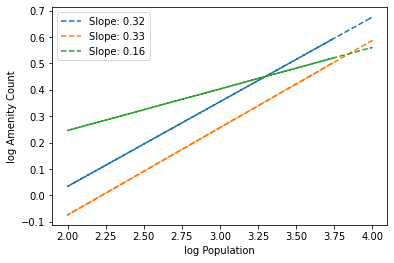

In [264]:
amenity_list = ['pub', 'school', 'place_of_worship']
small_pop_threshold = 10000
small_pop_data = parish_data[parish_data.population <= small_pop_threshold]

for amenity in amenity_list:
    amenity_counts = small_pop_data["amenity_list"].apply(lambda x: x.get(amenity, 0))
    amenity_counts += 1
    x = np.log10(small_pop_data["population"])
    y = np.log10(amenity_counts)

    # Perform linear regression to estimate the scaling exponent
    slope, intercept = np.polyfit(x, y, 1)

    # Plot the scaling relationship
#    plt.scatter(x, y, label=amenity)
    plt.plot(x, slope * x + intercept, linestyle='--', label=f"Slope: {slope:.2f}")
    
plt.xlabel("log Population")
plt.ylabel("log Amenity Count")
plt.legend()
plt.show()    

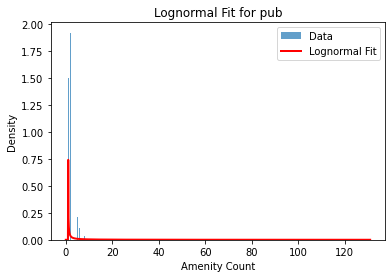

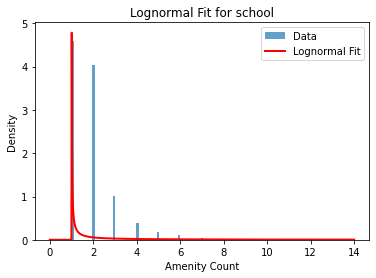

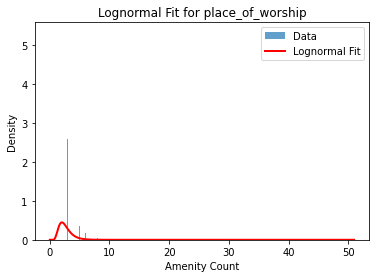

In [266]:
from scipy.stats import lognorm

for amenity in amenity_list:
    amenity_counts = small_pop_data["amenity_list"].apply(lambda x: x.get(amenity, 0))
    amenity_counts += 1  # Add a small offset to avoid zero counts

    # Fit lognormal distribution to the data
    params = lognorm.fit(amenity_counts)

    # Generate x values for the lognormal distribution
    x = np.linspace(0, amenity_counts.max(), 1000)

    # Plot the histogram of the data
    plt.hist(amenity_counts, bins='auto', density=True, alpha=0.7, label='Data')

    # Plot the fitted lognormal distribution
    plt.plot(x, lognorm.pdf(x, *params), 'r-', lw=2, label='Lognormal Fit')

        # Add plot labels and legend
    plt.xlabel("Amenity Count")
    plt.ylabel("Density")
    plt.legend()
    plt.title(f"Lognormal Fit for {amenity}")
    plt.show()

## Zipf law for population

In [268]:
parish_data.head()

PAR22CD       PAR22NM     RGN22NM  population          area  \
0  E04000001      Blackrod  North West        5517  8.599134e+06   
1  E04000002       Horwich  North West       20908  1.424275e+07   
2  E04000003  Westhoughton  North West       25340  1.786415e+07   
3  E04000005   Saddleworth  North West       25466  7.613353e+07   
4  E04000008       Mossley  North West       11566  8.658747e+06   

                                        amenity_list rural_label  
0  {'post_box': 3, 'place_of_worship': 2, 'fast_f...       Urban  
1  {'waste_basket': 6, 'parking': 48, 'school': 9...       Mixed  
2  {'waste_basket': 22, 'charging_station': 1, 'a...       Mixed  
3  {'parking': 115, 'telephone': 8, 'bench': 63, ...       Mixed  
4  {'place_of_worship': 5, 'parking': 16, 'waste_...       Mixed

In [274]:
parish_data.sort_values(by='population', ascending=False, inplace=True)
parish_ranks = np.arange(1, parish_data.shape[0]+1)

populations = parish_data.population.values
log_ranks = np.log(parish_ranks)
log_pops = np.log(populations)

In [278]:
import pylab
pylab.loglog?

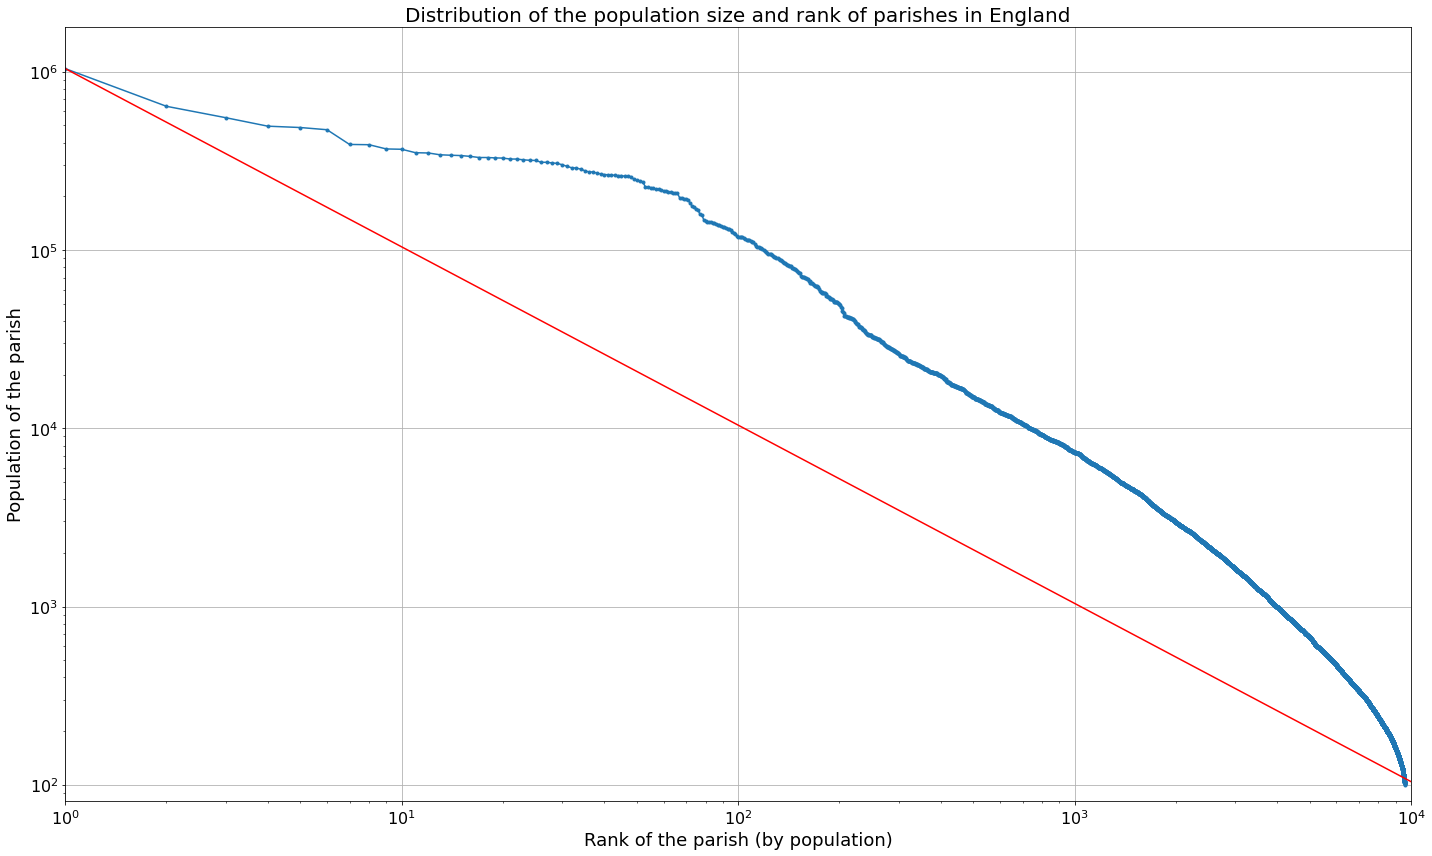

In [287]:
import pylab
fig, ax = plt.subplots(figsize=(20,12))
pylab.loglog(parish_ranks, populations, marker='.')
plt.xlim(1,10**4)
plt.ylim(9**2, 11**6)
plt.plot([1, populations[0]], [populations[0], 1], color='r')
plt.xlabel('Rank of the parish (by population)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Population of the parish', fontsize=18)
pylab.grid(True)
plt.title('Distribution of the population size and rank of parishes in England', fontsize=20)
plt.tight_layout()
plt.savefig('results/zipflaw_population_by_parish.png')
plt.show()

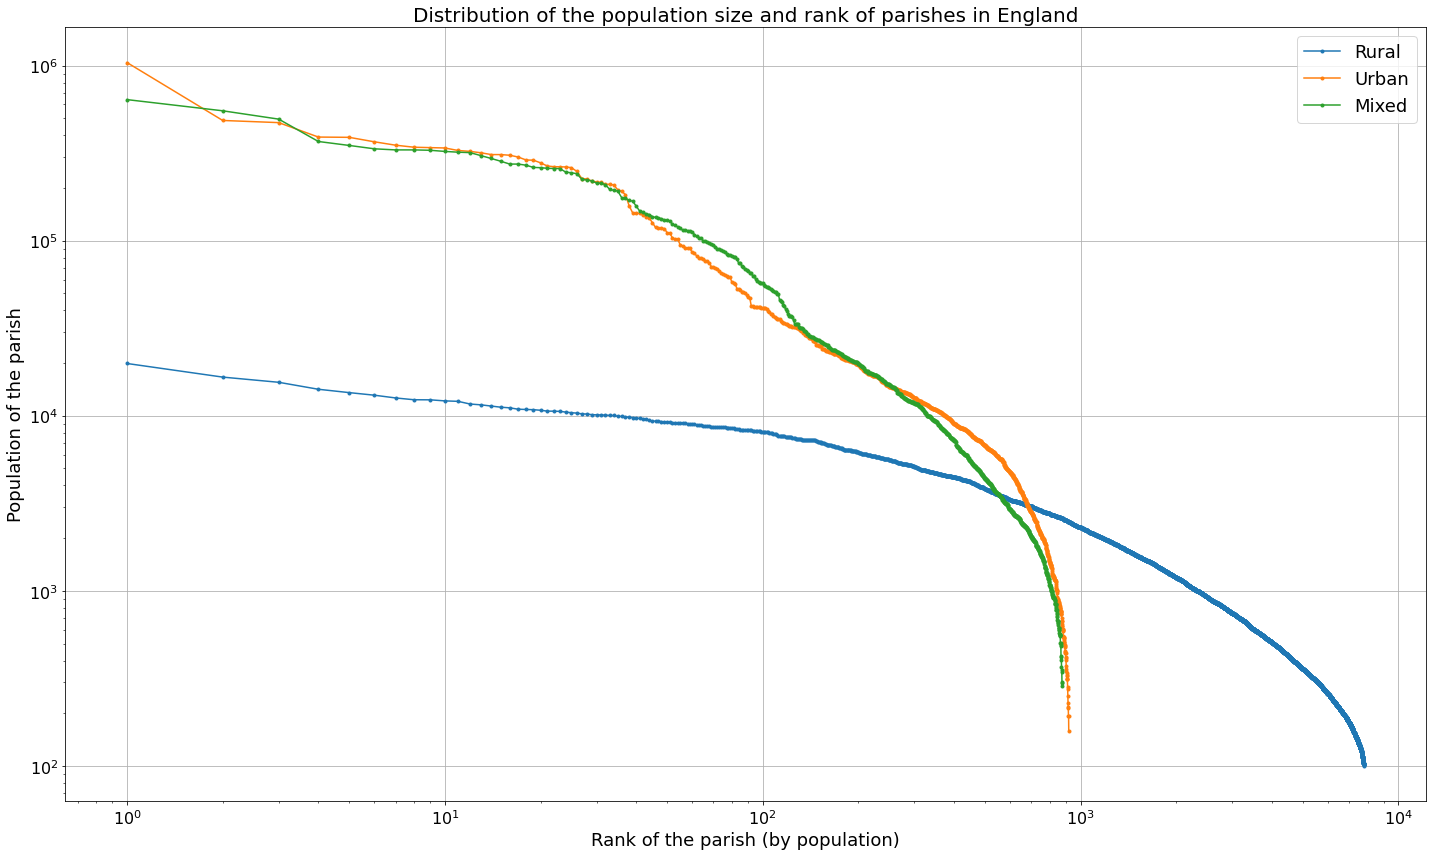

In [290]:
import pylab
fig, ax = plt.subplots(figsize=(20,12))

for parish_type in ['Rural', 'Urban', 'Mixed']:
    data = parish_data[parish_data['rural_label'] == parish_type]
    ranks = np.arange(1, data.shape[0] + 1)
    values = data.population.values
    pylab.loglog(ranks, values, marker='.', label=parish_type)
    
    

#plt.plot([1, populations[0]], [populations[0], 1], color='r')
plt.xlabel('Rank of the parish (by population)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=18)
plt.ylabel('Population of the parish', fontsize=18)
pylab.grid(True)
plt.title('Distribution of the population size and rank of parishes in England', fontsize=20)
plt.tight_layout()
plt.savefig('results/zipflaw_population_by_parish_split.png')
plt.show()

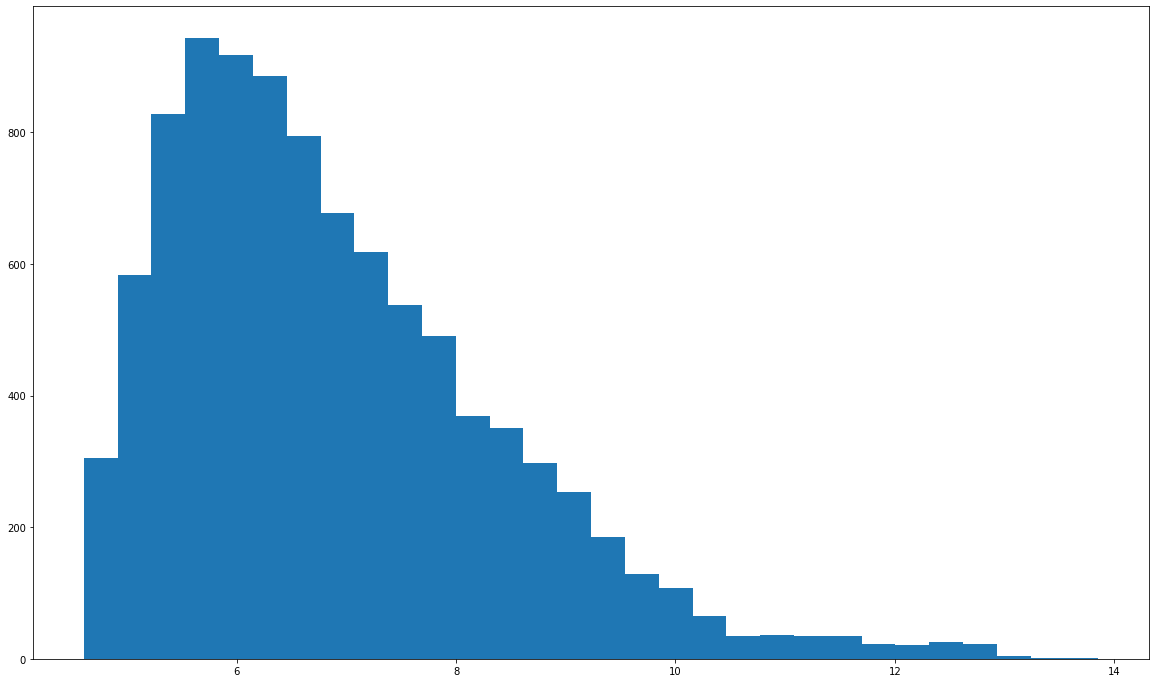

In [293]:
fig, ax = plt.subplots(figsize=(20,12))
plt.hist(np.log(parish_data.population.values), bins=30)
plt.show()

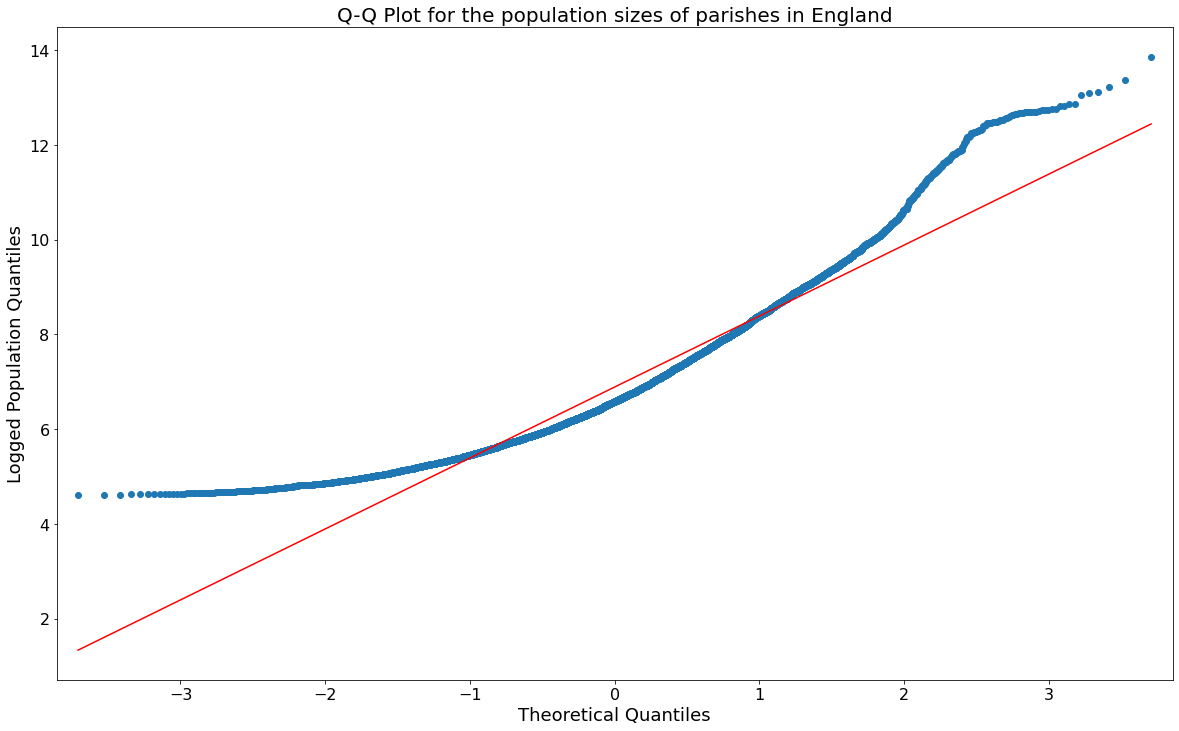

In [298]:
import statsmodels.api as sm
logged_pop = np.log(parish_data.population.values)

fig, ax = plt.subplots(figsize=(20,12))
sm.qqplot(logged_pop, line='s', ax=ax)
plt.xlabel("Theoretical Quantiles", fontsize=18)
plt.ylabel("Logged Population Quantiles", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Q-Q Plot for the population sizes of parishes in England", fontsize=20)
plt.savefig('results/qqplot_population_sizes.png')
plt.show()

In [321]:
amenity_counts = [
    [i.get(amenity,0) for i in parish_data.amenity_list]
    for amenity in amenity_list
]

for amenity in amenity_list:
    parish_data[amenity] = [i.get(amenity, 0) for i in parish_data.amenity_list]
    
parish_data.head()

PAR22CD                      PAR22NM                   RGN22NM  \
9547  E43000250  Birmingham, unparished area             West Midlands   
9569  E43000276       Leeds, unparished area  Yorkshire and The Humber   
9477  E43000157  Manchester, unparished area                North West   
9490  E43000173   Sheffield, unparished area  Yorkshire and The Humber   
9485  E43000166   Liverpool, unparished area                North West   

      population          area  \
9547     1040773  2.085932e+08   
9569      639331  2.514287e+08   
9477      551924  1.156455e+08   
9490      494678  1.846339e+08   
9485      486093  1.118441e+08   

                                           amenity_list rural_label  pub  \
9547  {'post_box': 1010, 'parking': 1419, 'bench': 6...       Urban  370   
9569  {'post_box': 714, 'parking': 1726, 'waste_bask...       Mixed  409   
9477  {'school': 213, 'taxi': 64, 'bicycle_parking':...       Mixed  293   
9490  {'bicycle_parking': 318, 'pharmacy': 87, 'post...       Mixed  304   
9485  {'post_box': 445, 'veterinary': 5, 'place_of_w...       Urban  311   

      school  place_of_worship  
9547     447               566  
9569     235               258  
9477     213               281  
9490     177               228  
9485     192               230

In [310]:
from statsmodels.genmod.families import NegativeBinomial
from statsmodels.discrete.count_model import ZeroInflatedPoisson
# Fit the Negative Binomial model
negbin_model = sm.GLM(amenity_counts[0], sm.add_constant(logged_pop),
                      family=sm.families.NegativeBinomial()).fit()

# Fit the Zero-Inflated Poisson model
zip_model = ZeroInflatedPoisson(np.array(amenity_counts[0]), sm.add_constant(logged_pop)).fit()



# Compare model performance using AIC or BIC
print(negbin_model.summary())
print(zip_model.summary())

Optimization terminated successfully.
         Current function value: 1.816715
         Iterations: 16
         Function evaluations: 22
         Gradient evaluations: 22
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 9575
Model:                            GLM   Df Residuals:                     9573
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16357.
Date:                Fri, 19 May 2023   Deviance:                       4932.7
Time:                        13:59:05   Pearson chi2:                 4.50e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.7555
Covariance Type:            nonrobust                                         
                 coef    std err      

/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [312]:
print(negbin_model.aic)
print(zip_model.aic)

32718.11049226865
34794.09197815423


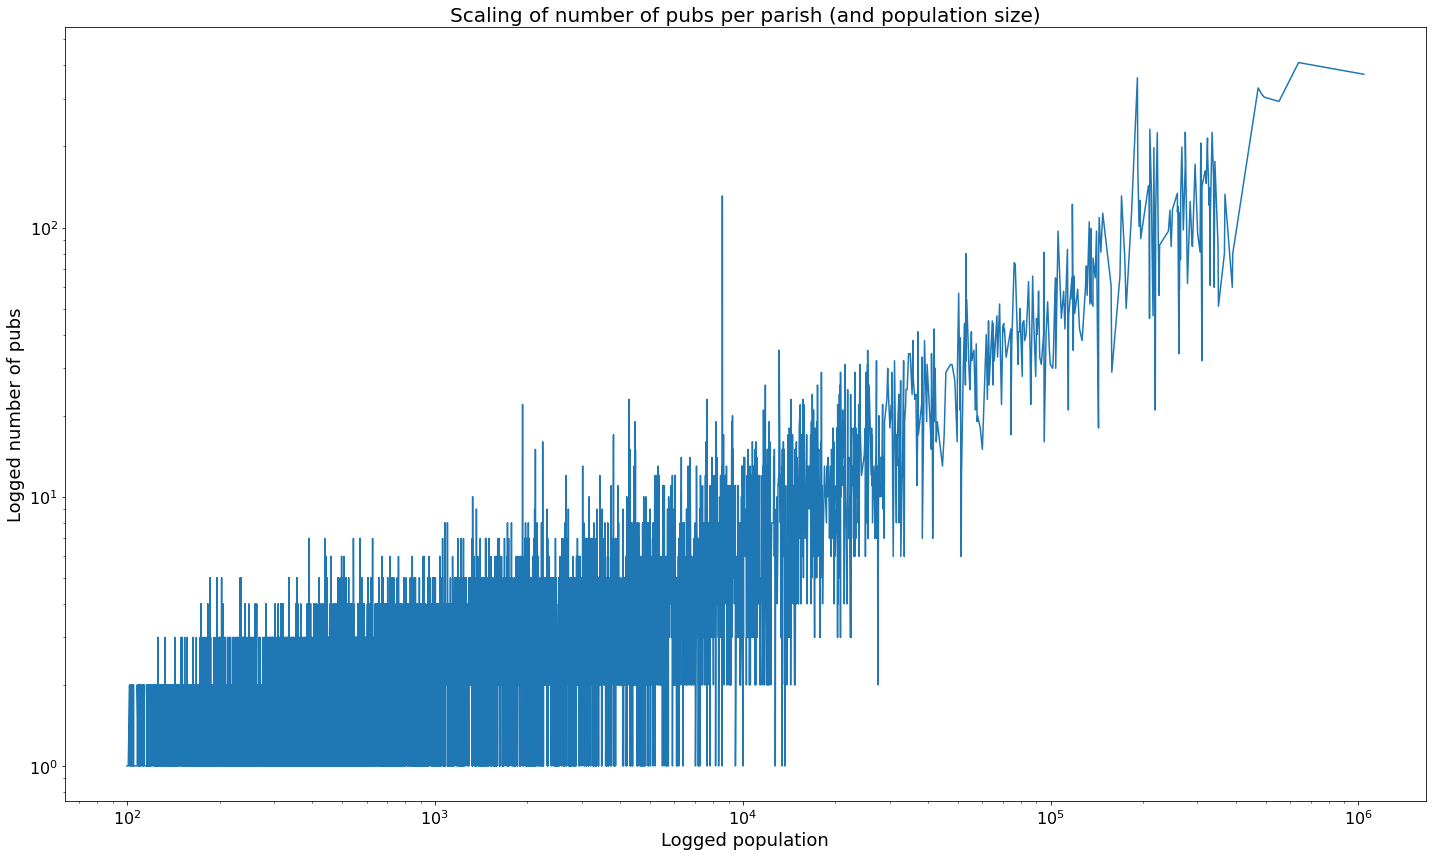

In [320]:
fig, ax = plt.subplots(figsize=(20,12))
pylab.loglog(populations, [i+1 for i in amenity_counts[0]])
plt.xlabel('Logged population', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Logged number of pubs', fontsize=18)
plt.yticks(fontsize=16)
plt.title('Scaling of number of pubs per parish (and population size)', fontsize=20)
plt.tight_layout()
plt.savefig('results/pubs_and_population_size.png')
plt.show()

In [325]:
len([i+1 for i in parish_data[parish_data.rural_label == 'Rural'].pub])

7781

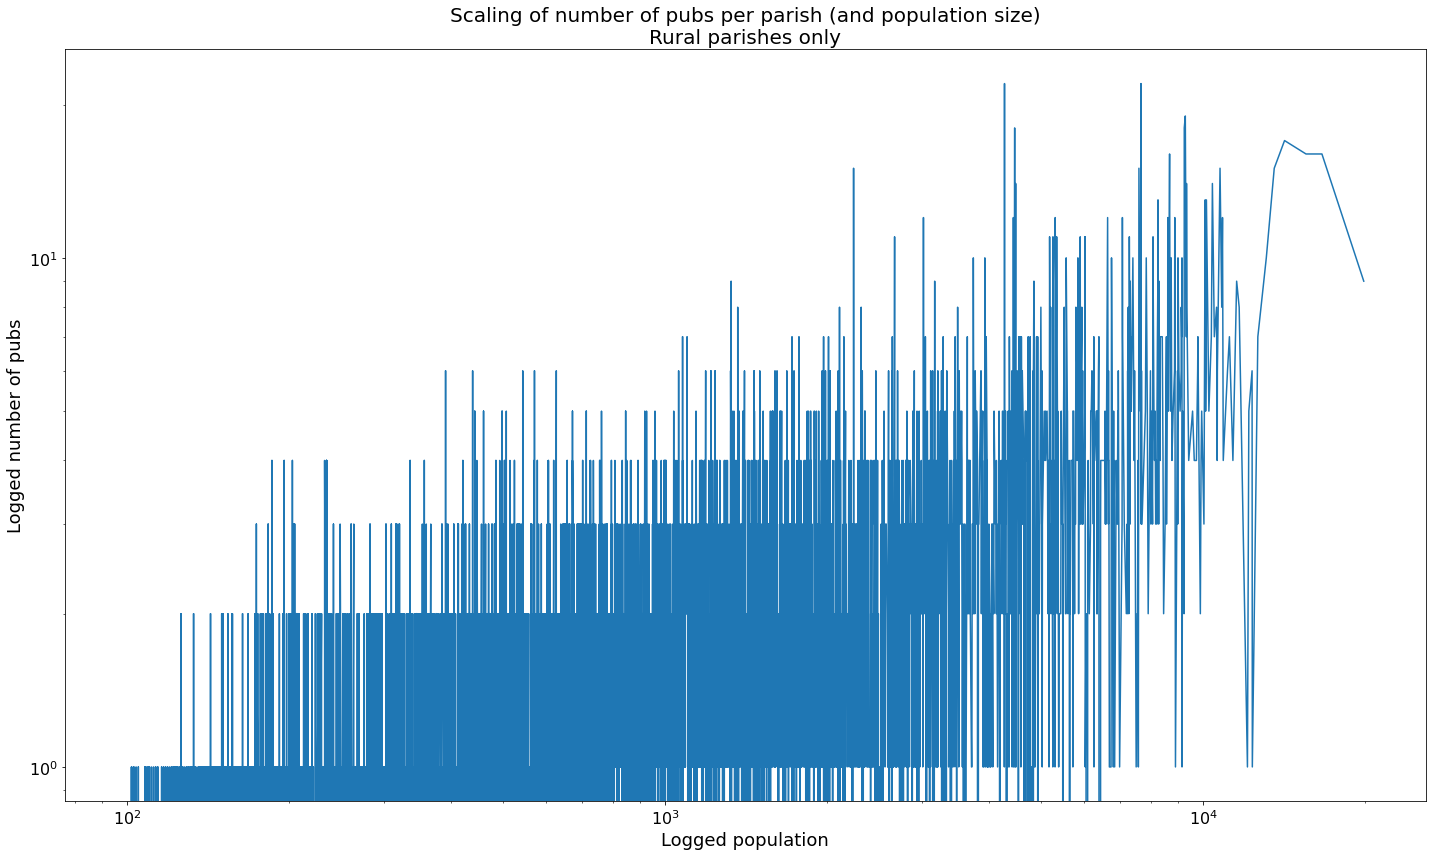

In [328]:
fig, ax = plt.subplots(figsize=(20,12))
pylab.loglog(parish_data[parish_data.rural_label == 'Rural'].population, [i for i in parish_data[parish_data.rural_label == 'Rural'].pub])
plt.xlabel('Logged population', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Logged number of pubs', fontsize=18)
plt.yticks(fontsize=16)
plt.title('Scaling of number of pubs per parish (and population size)\nRural parishes only', fontsize=20)
plt.tight_layout()
plt.savefig('results/rural_pubs_and_population_size.png')
plt.show()

In [330]:
print(np.mean(parish_data[parish_data.rural_label == 'Rural'].pub))
print(np.var(parish_data[parish_data.rural_label == 'Rural'].pub))

1.3511116823030458
2.8105337211088646


In [345]:
# Fit the negative binomial regression model
model = sm.GLM(
    np.log(parish_data[parish_data.rural_label == 'Rural'].pub + 1), 
    sm.add_constant(
        np.log(parish_data[parish_data.rural_label=='Rural'].population)
    ),
    family=sm.families.NegativeBinomial()
).fit()

# Print the model summary
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    pub   No. Observations:                 7781
Model:                            GLM   Df Residuals:                     7779
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8430.8
Date:                Fri, 19 May 2023   Deviance:                       2381.0
Time:                        14:40:39   Pearson chi2:                 1.60e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1002
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5932      0.115    -31.244      0.0

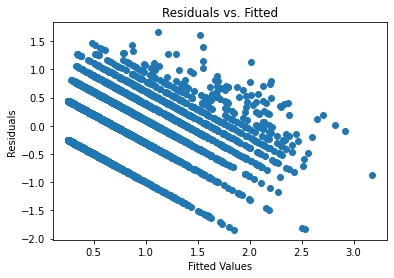

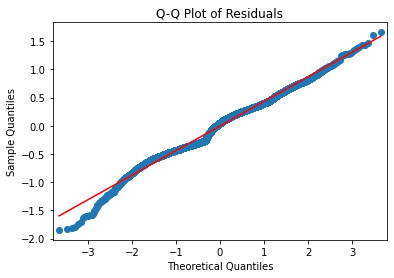

In [346]:
residuals = model.resid_response
fitted_values = model.fittedvalues
plt.scatter(fitted_values, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()

# Quantile-Quantile plot of the residuals
sm.qqplot(residuals, line='s')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot of Residuals')
plt.show()

## Smallest villages with things

In [349]:
parish_data[(parish_data.pub > 0) & (parish_data.school > 0) & (parish_data.place_of_worship > 0)].sort_values(by='population').head(10)

PAR22CD           PAR22NM                   RGN22NM  population  \
6940  E04009895           Eartham                South East         113   
6239  E04009005           Marston             West Midlands         123   
3191  E04004775            Hexton           East of England         123   
4914  E04007056         Arncliffe  Yorkshire and The Humber         127   
8957  E04012731       St Martin's                South West         136   
5251  E04007579         Gillamoor  Yorkshire and The Humber         139   
7464  E04010808       Holy Island                North East         150   
7326  E04010630  Forest and Frith                North East         151   
8959  E04012733            Tresco                South West         152   
4919  E04007067          Burnsall  Yorkshire and The Humber         157   

              area                                       amenity_list  \
6940  1.330718e+07  {'pub': 1, 'post_box': 2, 'parking': 7, 'bench...   
6239  7.079713e+06  {'post_box': 1, 'school': 1, 'place_of_worship...   
3191  6.005143e+06  {'pub': 1, 'post_box': 1, 'cafe': 1, 'parking'...   
4914  2.514150e+07  {'post_box': 1, 'bench': 2, 'telephone': 1, 'h...   
8957  2.751597e+06  {'telephone': 2, 'post_box': 1, 'pub': 1, 'bar...   
5251  6.595024e+06  {'pub': 1, 'post_box': 2, 'telephone': 1, 'ben...   
7464  6.234955e+06  {'pub': 2, 'telephone': 1, 'bicycle_parking': ...   
7326  7.159856e+07  {'drinking_water': 1, 'hunting_stand': 58, 'sh...   
8959  3.839622e+06  {'toilets': 3, 'cafe': 2, 'pub': 1, 'restauran...   
4919  1.197684e+07  {'pub': 1, 'cafe': 3, 'telephone': 1, 'toilets...   

     rural_label  pub  school  place_of_worship  
6940       Rural    1       1                 2  
6239       Rural    1       1                 1  
3191       Rural    1       1                 1  
4914       Rural    1       1                 1  
8957       Rural    1       1                 2  
5251       Rural    1       1                 1  
7464       Rural    2       1                 3  
7326       Rural    2       1                 1  
8959       Rural    1       1                 1  
4919       Rural    1       1                 2

In [350]:
parish_data['pubs_per_person'] = parish_data.pub / parish_data.population
parish_data.sort_values(by='pubs_per_person', ascending=False).head(10)

PAR22CD                   PAR22NM                   RGN22NM  \
1477  E04002516  Barton and Pooley Bridge                North West   
3356  E04004979                 Wormshill                South East   
8554  E04012261   Brendon and Countisbury                South West   
4918  E04007066                   Buckden  Yorkshire and The Humber   
8580  E04012291                    Hedley                North East   
7226  E04010477                   Eskdale                North West   
5213  E04007529                  Thoralby  Yorkshire and The Humber   
7600  E04010963         Little Bollington                North West   
3397  E04005035                  Snargate                South East   
4915  E04007060                  Beamsley  Yorkshire and The Humber   

      population          area  \
1477         186  1.825350e+07   
3356         196  6.836577e+06   
8554         203  3.807150e+07   
4918         174  6.501115e+07   
8580         233  1.154004e+07   
7226         235  8.423626e+07   
5213         235  3.762563e+07   
7600         183  2.736314e+06   
3397         126  1.226579e+07   
4915         391  6.085946e+07   

                                           amenity_list rural_label  pub  \
1477  {'toilets': 5, 'bench': 7, 'post_box': 3, 'was...       Rural    4   
3356  {'post_box': 3, 'pub': 4, 'telephone': 1, 'pla...       Rural    4   
8554  {'toilets': 4, 'parking': 12, 'pub': 4, 'cafe'...       Rural    4   
4918  {'parking': 13, 'post_box': 5, 'telephone': 2,...       Rural    3   
8580  {'cafe': 2, 'post_box': 2, 'bench': 2, 'pub': ...       Rural    4   
7226  {'post_office': 1, 'charging_station': 2, 'pos...       Rural    4   
5213  {'telephone': 4, 'post_box': 2, 'hunting_stand...       Rural    4   
7600  {'parking': 5, 'pub': 3, 'water_point': 2, 'we...       Rural    3   
3397   {'pub': 2, 'post_box': 1, 'place_of_worship': 2}       Rural    2   
4915  {'toilets': 21, 'post_box': 24, 'bbq': 3, 'res...       Rural    6   

      school  place_of_worship  pubs_per_person  
1477       0                 2         0.021505  
3356       0                 1         0.020408  
8554       0                 2         0.019704  
4918       0                 1         0.017241  
8580       0                 0         0.017167  
7226       1                 2         0.017021  
5213       0                 0         0.017021  
7600       1                 1         0.016393  
3397       0                 2         0.015873  
4915       6                 3         0.015345

In [357]:
by_region_pop = parish_data.groupby(['RGN22NM', 'rural_label']).population.sum().reset_index()
by_region_pop['pct_population'] = by_region_pop.groupby(['RGN22NM']).population.transform(lambda x: 100*x / x.sum())
by_region_pop

RGN22NM rural_label  population  pct_population
0              East Midlands       Mixed     1308017       26.803254
1              East Midlands       Rural     1239033       25.389667
2              East Midlands       Urban     2333018       47.807080
3            East of England       Mixed     2183853       34.473242
4            East of England       Rural     1689929       26.676398
5            East of England       Urban     2461140       38.850360
6                     London       Mixed     2162871       24.578722
7                     London       Urban     6636899       75.421278
8                 North East       Mixed     1838986       69.473850
9                 North East       Rural      377736       14.270241
10                North East       Urban      430297       16.255909
11                North West       Mixed     4883170       65.832663
12                North West       Rural      632566        8.527965
13                North West       Urban     1901813       25.639372
14                South East       Mixed     4474827       48.229910
15                South East       Rural     1624735       17.511475
16                South East       Urban     3178554       34.258615
17                South West       Mixed     1793364       31.455849
18                South West       Rural     1663567       29.179192
19                South West       Urban     2244279       39.364959
20             West Midlands       Mixed     1776765       29.857763
21             West Midlands       Rural      810624       13.622184
22             West Midlands       Urban     3363375       56.520054
23  Yorkshire and The Humber       Mixed     3371004       61.504952
24  Yorkshire and The Humber       Rural      825526       15.061963
25  Yorkshire and The Humber       Urban     1284336       23.433085

In [387]:
to_add = {'RGN22NM': 'London', 'rural_label': 'Rural', 'population': 0, 'pct_population': 0}
by_region_pop = by_region_pop.append(to_add, ignore_index=True)

/var/folders/zs/1hvc18dn7v94z77k1xy7g90c0000gn/T/ipykernel_18487/719357222.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  by_region_pop = by_region_pop.append(to_add, ignore_index=True)


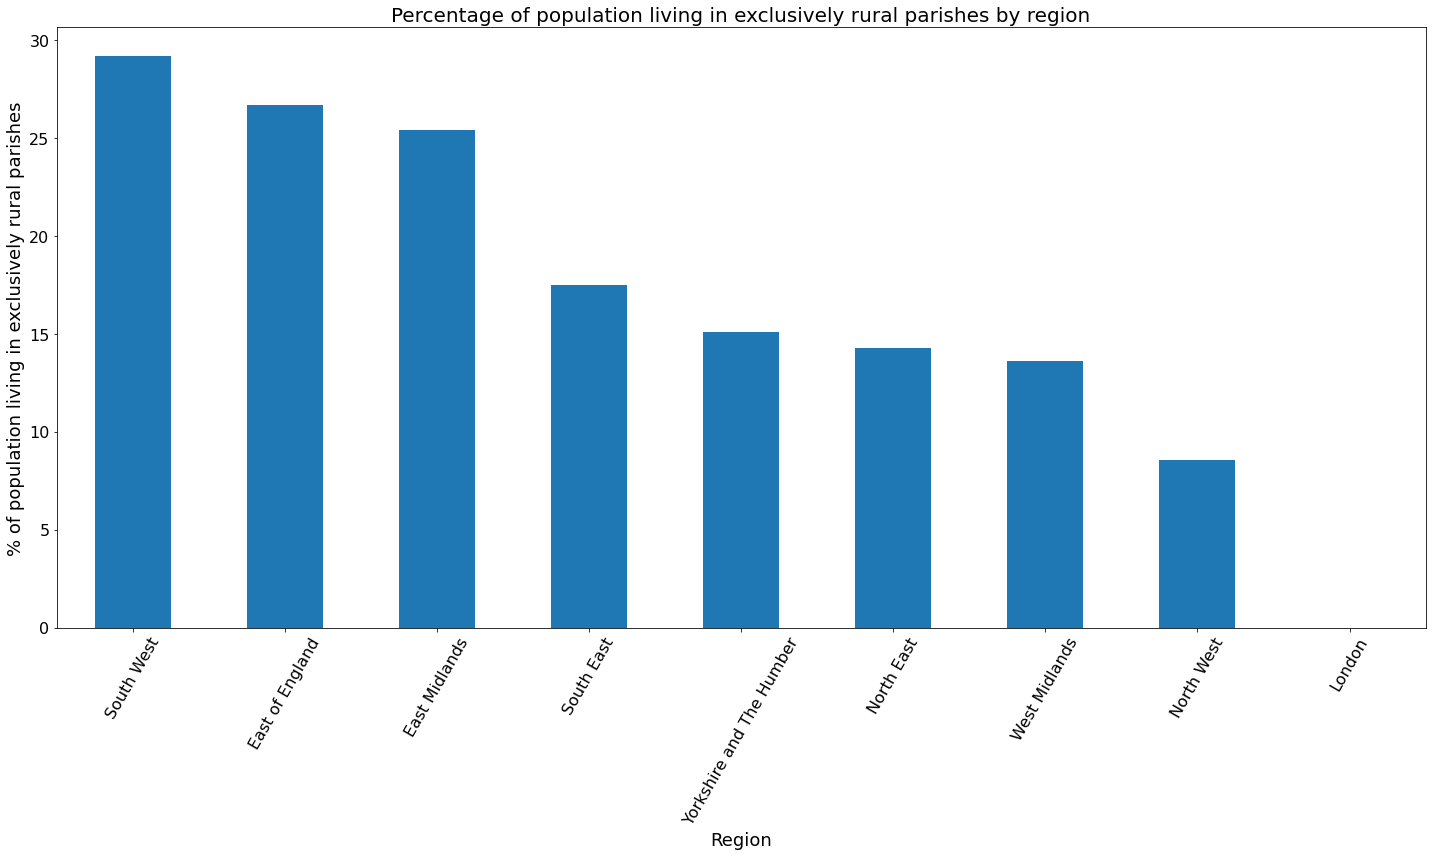

In [388]:
rural_pct_pop = by_region_pop[by_region_pop.rural_label == 'Rural'].sort_values(by='pct_population', ascending=False)
fig, ax = plt.subplots(figsize=(20,12))
rural_pct_pop.pct_population.plot(kind='bar', ax=ax)
plt.xlabel('Region', fontsize=18)
plt.ylabel('% of population living in exclusively rural parishes', fontsize=18)
plt.xticks(np.arange(len(rural_pct_pop)), rural_pct_pop.RGN22NM, fontsize=16, rotation=60)
plt.yticks(fontsize=16)
plt.title('Percentage of population living in exclusively rural parishes by region', fontsize=20)
plt.tight_layout()
plt.savefig('results/pct_exclusive_rural.png')
plt.show()

In [389]:
by_region_size = parish_data.groupby(['RGN22NM', 'rural_label']).size().reset_index()
by_region_size

RGN22NM rural_label     0
0              East Midlands       Mixed    69
1              East Midlands       Rural  1141
2              East Midlands       Urban   140
3            East of England       Mixed   124
4            East of England       Rural  1484
5            East of England       Urban   125
6                     London       Mixed     8
7                     London       Urban    26
8                 North East       Mixed    41
9                 North East       Rural   264
10                North East       Urban    31
11                North West       Mixed   114
12                North West       Rural   584
13                North West       Urban    92
14                South East       Mixed   242
15                South East       Rural  1131
16                South East       Urban   198
17                South West       Mixed   121
18                South West       Rural  1535
19                South West       Urban   124
20             West Midlands       Mixed    87
21             West Midlands       Rural   802
22             West Midlands       Urban    88
23  Yorkshire and The Humber       Mixed    70
24  Yorkshire and The Humber       Rural   840
25  Yorkshire and The Humber       Urban    94

In [391]:
by_region_size = parish_data.groupby(['RGN22NM', 'rural_label']).size().reset_index()
by_region_size['pct_parishes'] = by_region_size.groupby(['RGN22NM'])[0].transform(lambda x: 100*x / x.sum())
to_add = {'RGN22NM': 'London', 'rural_label': 'Rural', 0: 0, 'pct_parishes': 0}
by_region_size = by_region_size.append(to_add, ignore_index=True)
by_region_size

/var/folders/zs/1hvc18dn7v94z77k1xy7g90c0000gn/T/ipykernel_18487/262316331.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  by_region_size = by_region_size.append(to_add, ignore_index=True)


RGN22NM rural_label     0  pct_parishes
0              East Midlands       Mixed    69      5.111111
1              East Midlands       Rural  1141     84.518519
2              East Midlands       Urban   140     10.370370
3            East of England       Mixed   124      7.155222
4            East of England       Rural  1484     85.631852
5            East of England       Urban   125      7.212926
6                     London       Mixed     8     23.529412
7                     London       Urban    26     76.470588
8                 North East       Mixed    41     12.202381
9                 North East       Rural   264     78.571429
10                North East       Urban    31      9.226190
11                North West       Mixed   114     14.430380
12                North West       Rural   584     73.924051
13                North West       Urban    92     11.645570
14                South East       Mixed   242     15.404201
15                South East       Rural  1131     71.992362
16                South East       Urban   198     12.603437
17                South West       Mixed   121      6.797753
18                South West       Rural  1535     86.235955
19                South West       Urban   124      6.966292
20             West Midlands       Mixed    87      8.904811
21             West Midlands       Rural   802     82.088025
22             West Midlands       Urban    88      9.007165
23  Yorkshire and The Humber       Mixed    70      6.972112
24  Yorkshire and The Humber       Rural   840     83.665339
25  Yorkshire and The Humber       Urban    94      9.362550
26                    London       Rural     0      0.000000

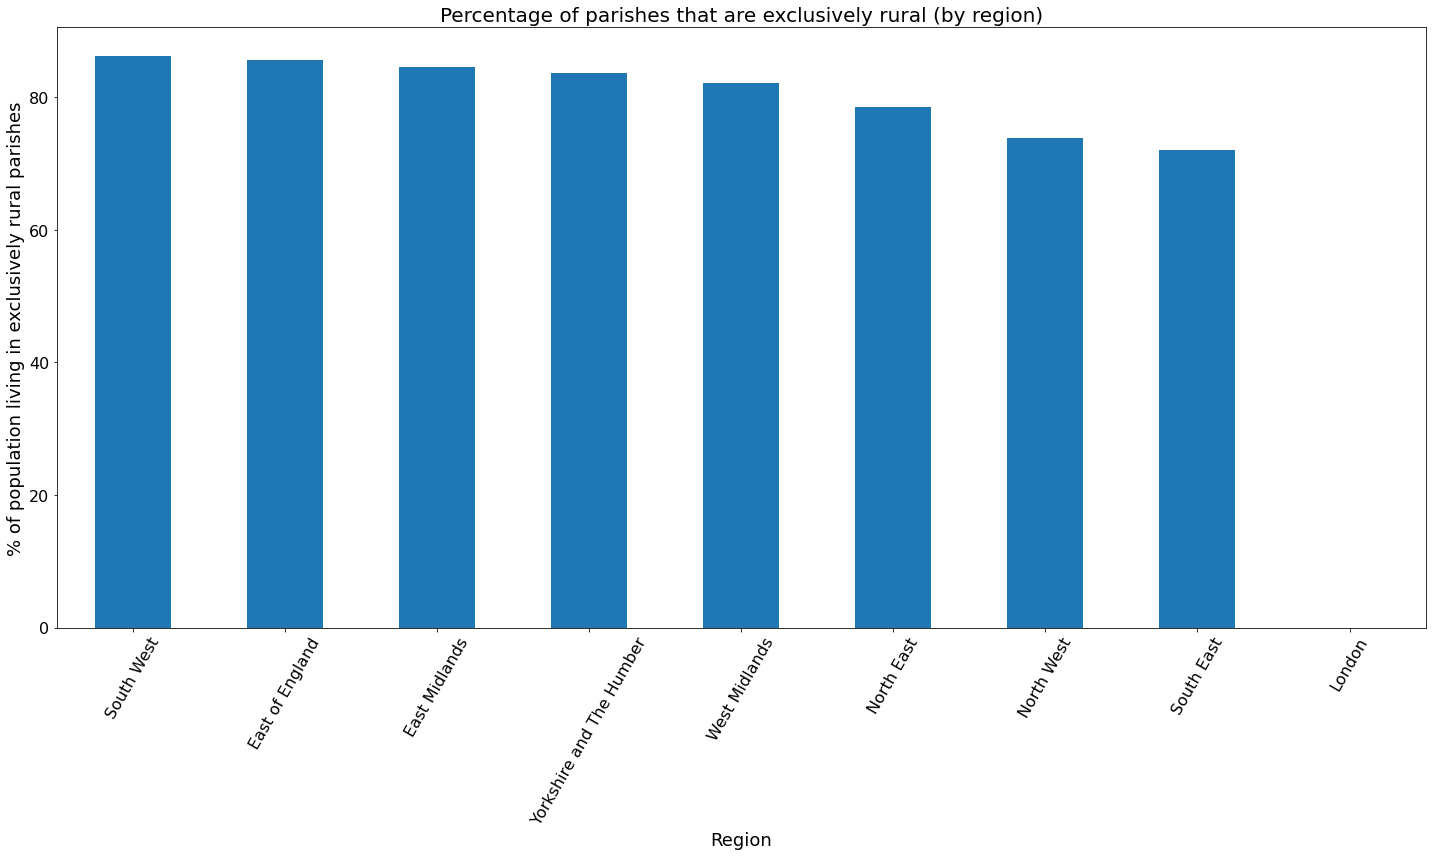

In [397]:
rural_pct_size = by_region_size[by_region_size.rural_label == 'Rural'].sort_values(by='pct_parishes', ascending=False)
fig, ax = plt.subplots(figsize=(20,12))
rural_pct_size.pct_parishes.plot(kind='bar', ax=ax)
plt.xlabel('Region', fontsize=18)
plt.ylabel('% of population living in exclusively rural parishes', fontsize=18)
plt.xticks(np.arange(len(rural_pct_size)), rural_pct_size.RGN22NM, fontsize=16, rotation=60)
plt.yticks(fontsize=16)
plt.title('Percentage of parishes that are exclusively rural (by region)', fontsize=20)
plt.tight_layout()
plt.savefig('results/pct_parishes_exclusive_rural.png')
plt.show()

## Pubs per person distribution

In [393]:
parish_data.head()

PAR22CD                      PAR22NM                   RGN22NM  \
9547  E43000250  Birmingham, unparished area             West Midlands   
9569  E43000276       Leeds, unparished area  Yorkshire and The Humber   
9477  E43000157  Manchester, unparished area                North West   
9490  E43000173   Sheffield, unparished area  Yorkshire and The Humber   
9485  E43000166   Liverpool, unparished area                North West   

      population          area  \
9547     1040773  2.085932e+08   
9569      639331  2.514287e+08   
9477      551924  1.156455e+08   
9490      494678  1.846339e+08   
9485      486093  1.118441e+08   

                                           amenity_list rural_label  pub  \
9547  {'post_box': 1010, 'parking': 1419, 'bench': 6...       Urban  370   
9569  {'post_box': 714, 'parking': 1726, 'waste_bask...       Mixed  409   
9477  {'school': 213, 'taxi': 64, 'bicycle_parking':...       Mixed  293   
9490  {'bicycle_parking': 318, 'pharmacy': 87, 'post...       Mixed  304   
9485  {'post_box': 445, 'veterinary': 5, 'place_of_w...       Urban  311   

      school  place_of_worship  pubs_per_person  
9547     447               566         0.000356  
9569     235               258         0.000640  
9477     213               281         0.000531  
9490     177               228         0.000615  
9485     192               230         0.000640

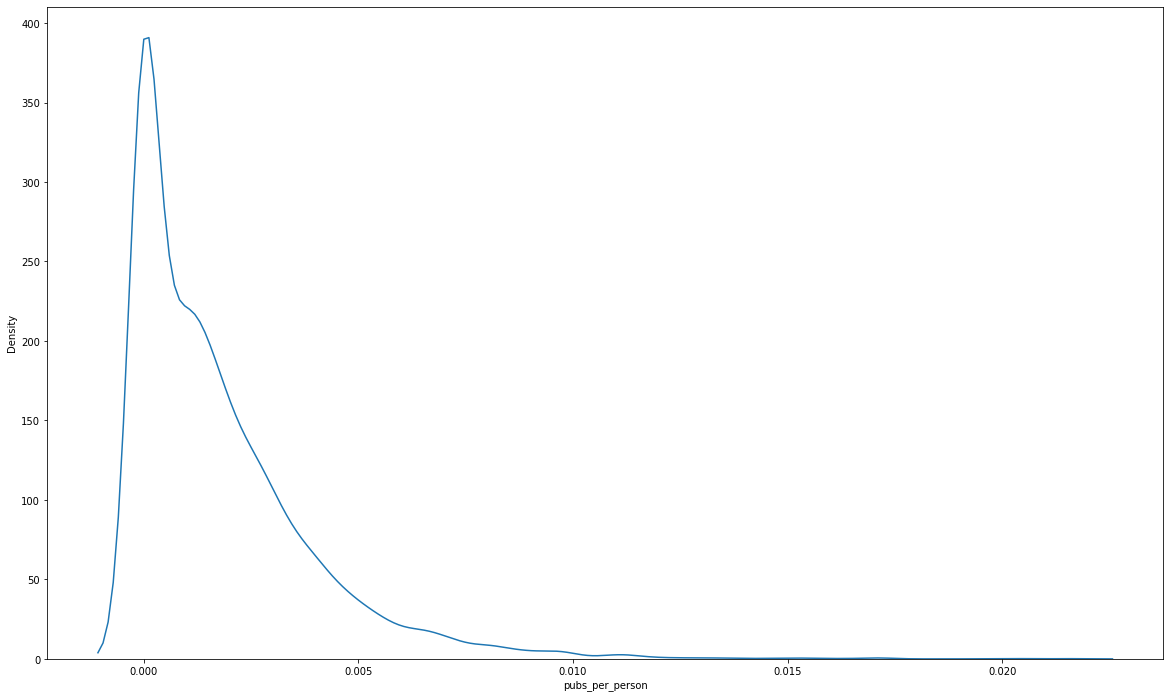

In [396]:
fig, ax = plt.subplots(figsize=(20,12))
sns.kdeplot(parish_data[parish_data.rural_label == 'Rural'].pubs_per_person)
plt.show()

In [399]:
rural_counter.most_common(40)

[('parking', 52442),
 ('bench', 29427),
 ('post_box', 26940),
 ('place_of_worship', 13333),
 ('pub', 11706),
 ('parking_space', 10757),
 ('grave_yard', 8665),
 ('waste_basket', 7959),
 ('school', 6532),
 ('cafe', 5949),
 ('hunting_stand', 5386),
 ('telephone', 4540),
 ('community_centre', 4360),
 ('toilets', 3749),
 ('restaurant', 3528),
 ('fast_food', 3187),
 ('bicycle_parking', 3024),
 ('post_office', 2889),
 ('grit_bin', 2673),
 ('shelter', 2151),
 ('recycling', 2142),
 ('fuel', 1894),
 ('public_bookcase', 1110),
 ('social_facility', 1086),
 ('doctors', 977),
 ('pharmacy', 953),
 ('atm', 918),
 ('charging_station', 759),
 ('kindergarten', 698),
 ('library', 679),
 ('townhall', 624),
 ('fire_station', 568),
 ('fountain', 543),
 ('vending_machine', 503),
 ('bar', 484),
 ('veterinary', 449),
 ('dentist', 433),
 ('drinking_water', 423),
 ('waste_disposal', 400),
 ('car_wash', 382)]

In [402]:
amenities_i_care_about = [
    'pub',
    'school',
    'cafe',
    'community_centre',
    'post_office'
]

def has_these_amenities(amenity_list, ones_i_want):
    result = True
    for amenity in ones_i_want:
        if amenity not in amenity_list:
            result = False
    return result



In [406]:
parish_data[parish_data.amenity_list.apply(lambda x: has_these_amenities(x, amenities_i_care_about))].sort_values(by='population', ascending=True).head(15)

PAR22CD                  PAR22NM                   RGN22NM  \
7464  E04010808              Holy Island                North East   
8959  E04012733                   Tresco                South West   
8956  E04012729                   Bryher                South West   
2359  E04003772                    Firle                South East   
1739  E04002848                    Edale             East Midlands   
1678  E04002763  Hartington Town Quarter             East Midlands   
8006  E04011585                 St. Veep                South West   
5333  E04007688                    Lythe  Yorkshire and The Humber   
3623  E04005282                Slaidburn                North West   
5323  E04007676                Goathland  Yorkshire and The Humber   
4915  E04007060                 Beamsley  Yorkshire and The Humber   
1578  E04002640            Over Staveley                North West   
2095  E04003257                 Clovelly                South West   
2790  E04004276           Temple Guiting                South West   
3560  E04005212         Wray-with-Botton                North West   

      population          area  \
7464         150  6.234955e+06   
8959         152  3.839622e+06   
8956         174  3.177688e+06   
2359         264  1.386432e+07   
1739         285  2.848307e+07   
1678         303  1.609870e+07   
8006         319  1.259688e+07   
5333         339  1.069204e+07   
3623         339  5.121747e+07   
5323         377  3.758025e+07   
4915         391  6.085946e+07   
1578         422  9.634813e+05   
2095         447  1.797400e+07   
2790         448  4.486700e+07   
3560         476  2.170985e+07   

                                           amenity_list rural_label  pub  \
7464  {'pub': 2, 'telephone': 1, 'bicycle_parking': ...       Rural    2   
8959  {'toilets': 3, 'cafe': 2, 'pub': 1, 'restauran...       Rural    1   
8956  {'toilets': 2, 'cafe': 4, 'post_box': 3, 'tele...       Rural    2   
2359  {'post_box': 4, 'pub': 1, 'post_office': 1, 't...       Rural    1   
1739  {'telephone': 4, 'recycling': 1, 'cafe': 2, 'p...       Rural    2   
1678  {'pub': 3, 'cafe': 2, 'bench': 10, 'doctors': ...       Rural    3   
8006  {'post_office': 1, 'telephone': 1, 'bench': 5,...       Rural    3   
5333  {'post_box': 5, 'post_office': 1, 'pub': 2, 't...       Rural    2   
3623  {'parking': 8, 'pub': 1, 'telephone': 2, 'cafe...       Rural    1   
5323  {'parking': 20, 'post_box': 4, 'pub': 2, 'toil...       Rural    2   
4915  {'toilets': 21, 'post_box': 24, 'bbq': 3, 'res...       Rural    6   
1578  {'post_box': 2, 'school': 1, 'place_of_worship...       Rural    1   
2095  {'bench': 20, 'parking': 5, 'cafe': 2, 'dressi...       Rural    3   
2790  {'post_box': 6, 'recycling': 1, 'telephone': 2...       Rural    2   
3560  {'post_box': 1, 'place_of_worship': 2, 'pub': ...       Rural    2   

      school  place_of_worship  pubs_per_person  
7464       1                 3         0.013333  
8959       1                 1         0.006579  
8956       1                 2         0.011494  
2359       1                 1         0.003788  
1739       1                 3         0.007018  
1678       1                 1         0.009901  
8006       1                 1         0.009404  
5333       1                 2         0.005900  
3623       1                 2         0.002950  
5323       1                 1         0.005305  
4915       6                 3         0.015345  
1578       1                 1         0.002370  
2095       1                 4         0.006711  
2790       1                 3         0.004464  
3560       1                 2         0.004202

In [409]:
parish_data[parish_data.PAR22NM == 'Great Ouseburn'].amenity_list.values[0]

Counter({'post_box': 2,
         'post_office': 1,
         'school': 1,
         'place_of_worship': 1,
         'grave_yard': 1,
         'parking': 5,
         'community_centre': 1,
         'pub': 1})

## Layering on IMD

In [410]:
imd_data = pd.read_csv('data/Index_of_Multiple_Deprivation_(Dec_2019)_Lookup_in_England.csv')
imd_data.head()

FID   LSOA11CD                   LSOA11NM    LAD19CD               LAD19NM  \
0    1  E01000001        City of London 001A  E09000001        City of London   
1    2  E01000104  Barking and Dagenham 014B  E09000002  Barking and Dagenham   
2    3  E01000205                Barnet 035A  E09000003                Barnet   
3    4  E01000002        City of London 001B  E09000001        City of London   
4    5  E01000003        City of London 001C  E09000001        City of London   

   IMD19  
0  29199  
1   6002  
2  27397  
3  30379  
4  14915

In [414]:
oa11_lsoa11_lookup = pd.read_csv('data/Output_Area_to_Lower_layer_Super_Output_Area_to_Middle_layer_Super_Output_Area_to_Local_Authority_District_(December_2011)_Lookup_in_England_and_Wales.csv')
oa11_lsoa11_lookup.head()


/var/folders/zs/1hvc18dn7v94z77k1xy7g90c0000gn/T/ipykernel_18487/1005487974.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  oa11_lsoa11_lookup = pd.read_csv('data/Output_Area_to_Lower_layer_Super_Output_Area_to_Middle_layer_Super_Output_Area_to_Local_Authority_District_(December_2011)_Lookup_in_England_and_Wales.csv')


OA11CD   LSOA11CD             LSOA11NM   MSOA11CD            MSOA11NM  \
0  E00000001  E01000001  City of London 001A  E02000001  City of London 001   
1  E00000003  E01000001  City of London 001A  E02000001  City of London 001   
2  E00000005  E01000001  City of London 001A  E02000001  City of London 001   
3  E00000007  E01000001  City of London 001A  E02000001  City of London 001   
4  E00000010  E01000003  City of London 001C  E02000001  City of London 001   

     LAD11CD         LAD11NM LAD11NMW  ObjectId  
0  E09000001  City of London      NaN         1  
1  E09000001  City of London      NaN         2  
2  E09000001  City of London      NaN         3  
3  E09000001  City of London      NaN         4  
4  E09000001  City of London      NaN         5

In [415]:
oa11_oa21_lookup.head()

ObjectId     OA11CD     OA21CD CHNGIND    LAD22CD               LAD22NM  \
0         1  E00000124  E00000124       U  E09000002  Barking and Dagenham   
1         2  E00000125  E00000125       U  E09000002  Barking and Dagenham   
2         3  E00000128  E00000128       U  E09000002  Barking and Dagenham   
3         4  E00000129  E00000129       U  E09000002  Barking and Dagenham   
4         5  E00000130  E00000130       U  E09000002  Barking and Dagenham   

  LAD22NMW  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

In [416]:
imd_frame = oa11_oa21_lookup[['OA11CD', 'OA21CD']].merge(
    oa11_lsoa11_lookup[['OA11CD', 'LSOA11CD']], how='inner', on='OA11CD'
).merge(
    imd_data[['LSOA11CD', 'IMD19']],
    how='inner',
    on='LSOA11CD'
)

imd_frame.head()

OA11CD     OA21CD   LSOA11CD  IMD19
0  E00000124  E00000124  E01000022   6098
1  E00000116  E00000116  E01000022   6098
2  E00000120  E00000120  E01000022   6098
3  E00000122  E00000122  E01000022   6098
4  E00000125  E00000125  E01000023   5243

In [418]:
oa_total_frame.head()

OA21CD    PAR22CD        PAR22NM     RGN22NM  population          area  \
0  E00060311  E04000255  Dalton Piercy  North East         312  6.758443e+06   
1  E00060356  E04000257       Greatham  North East         283  5.098650e+05   
2  E00060360  E04000257       Greatham  North East         274  6.863565e+04   
3  E00060357  E04000257       Greatham  North East         298  3.589880e+05   
4  E00060359  E04000257       Greatham  North East         274  6.126857e+04   

                                           amenities  
0  [{'name': 'N/A', 'amenity': 'post_box', 'data_...  
1  [{'name': 'The Bull and Dog', 'amenity': 'pub'...  
2                                                 []  
3  [{'name': 'N/A', 'amenity': 'waste_basket', 'd...  
4                                                 []

In [419]:
imd_frame.groupby(['OA21CD']).size().sort_values(ascending=False).head(10)

OA21CD
E00182748    5
E00189918    5
E00178635    4
E00180779    4
E00189204    4
E00178724    4
E00181936    4
E00185187    4
E00189219    4
E00176912    3
dtype: int64

In [424]:
raw_oa21_imd_lookup = imd_frame[['OA21CD', 'IMD19']].drop_duplicates()
oa_total_frame = oa_total_frame.merge(raw_oa21_imd_lookup, how='left', on='OA21CD')
oa_total_frame.head()

OA21CD    PAR22CD        PAR22NM     RGN22NM  population          area  \
0  E00060311  E04000255  Dalton Piercy  North East         312  6.758443e+06   
1  E00060356  E04000257       Greatham  North East         283  5.098650e+05   
2  E00060360  E04000257       Greatham  North East         274  6.863565e+04   
3  E00060357  E04000257       Greatham  North East         298  3.589880e+05   
4  E00060359  E04000257       Greatham  North East         274  6.126857e+04   

                                           amenities    IMD19  
0  [{'name': 'N/A', 'amenity': 'post_box', 'data_...  22123.0  
1  [{'name': 'The Bull and Dog', 'amenity': 'pub'...  14530.0  
2                                                 []  14530.0  
3  [{'name': 'N/A', 'amenity': 'waste_basket', 'd...  14530.0  
4                                                 []  14530.0

In [425]:
parish_data.head()

PAR22CD                      PAR22NM                   RGN22NM  \
9547  E43000250  Birmingham, unparished area             West Midlands   
9569  E43000276       Leeds, unparished area  Yorkshire and The Humber   
9477  E43000157  Manchester, unparished area                North West   
9490  E43000173   Sheffield, unparished area  Yorkshire and The Humber   
9485  E43000166   Liverpool, unparished area                North West   

      population          area  \
9547     1040773  2.085932e+08   
9569      639331  2.514287e+08   
9477      551924  1.156455e+08   
9490      494678  1.846339e+08   
9485      486093  1.118441e+08   

                                           amenity_list rural_label  pub  \
9547  {'post_box': 1010, 'parking': 1419, 'bench': 6...       Urban  370   
9569  {'post_box': 714, 'parking': 1726, 'waste_bask...       Mixed  409   
9477  {'school': 213, 'taxi': 64, 'bicycle_parking':...       Mixed  293   
9490  {'bicycle_parking': 318, 'pharmacy': 87, 'post...       Mixed  304   
9485  {'post_box': 445, 'veterinary': 5, 'place_of_w...       Urban  311   

      school  place_of_worship  pubs_per_person  
9547     447               566         0.000356  
9569     235               258         0.000640  
9477     213               281         0.000531  
9490     177               228         0.000615  
9485     192               230         0.000640

In [437]:
def weighted_imd(x,weighting_column):
    imd_total = 0
    weighting_total = 0
    for row in x.iterrows():
        imd_total += row[1].IMD19 * row[1][weighting_column]
        weighting_total += row[1][weighting_column]
    total = imd_total/weighting_total
    return total

parish_imd_frame = oa_total_frame.groupby(['PAR22CD', 'PAR22NM']).apply(lambda x: weighted_imd(x, 'population')).reset_index()
parish_imd_frame.columns = ['PAR22CD', 'PAR22NM', 'population_weighted_imd']
parish_imd_frame.head()


PAR22CD       PAR22NM  population_weighted_imd
0  E04000001      Blackrod             20311.266630
1  E04000002       Horwich             14657.016644
2  E04000003  Westhoughton             18738.612747
3  E04000005   Saddleworth             25033.770282
4  E04000008       Mossley             14241.922013

In [438]:
inty = oa_total_frame.groupby(['PAR22CD', 'PAR22NM']).apply(lambda x: weighted_imd(x, 'area')).reset_index()
inty.columns = ['PAR22CD', 'PAR22NM', 'area_weighted_imd']
inty.head()

PAR22CD       PAR22NM  area_weighted_imd
0  E04000001      Blackrod       23220.071314
1  E04000002       Horwich       22628.188830
2  E04000003  Westhoughton       18446.579204
3  E04000005   Saddleworth       24561.313884
4  E04000008       Mossley        9925.190128

In [439]:
parish_imd_frame = parish_imd_frame.merge(inty, how='inner', on=['PAR22CD', 'PAR22NM'])
parish_imd_frame.head()

PAR22CD       PAR22NM  population_weighted_imd  area_weighted_imd
0  E04000001      Blackrod             20311.266630       23220.071314
1  E04000002       Horwich             14657.016644       22628.188830
2  E04000003  Westhoughton             18738.612747       18446.579204
3  E04000005   Saddleworth             25033.770282       24561.313884
4  E04000008       Mossley             14241.922013        9925.190128

In [441]:
parish_imd_frame[pd.isnull(parish_imd_frame.area_weighted_imd)].head()

PAR22CD    PAR22NM  population_weighted_imd  area_weighted_imd
9575  W04000001  Aberffraw                      NaN                NaN
9576  W04000002     Amlwch                      NaN                NaN
9577  W04000003  Beaumaris                      NaN                NaN
9578  W04000004   Bodedern                      NaN                NaN
9579  W04000005  Bodffordd                      NaN                NaN

In [444]:
parish_data = parish_data.merge(
    parish_imd_frame[['PAR22CD', 'population_weighted_imd', 'area_weighted_imd']],
    how='inner',
    on='PAR22CD'
)

parish_data.head()

PAR22CD                      PAR22NM                   RGN22NM  \
0  E43000250  Birmingham, unparished area             West Midlands   
1  E43000276       Leeds, unparished area  Yorkshire and The Humber   
2  E43000157  Manchester, unparished area                North West   
3  E43000173   Sheffield, unparished area  Yorkshire and The Humber   
4  E43000166   Liverpool, unparished area                North West   

   population          area  \
0     1040773  2.085932e+08   
1      639331  2.514287e+08   
2      551924  1.156455e+08   
3      494678  1.846339e+08   
4      486093  1.118441e+08   

                                        amenity_list rural_label  pub  school  \
0  {'post_box': 1010, 'parking': 1419, 'bench': 6...       Urban  370     447   
1  {'post_box': 714, 'parking': 1726, 'waste_bask...       Mixed  409     235   
2  {'school': 213, 'taxi': 64, 'bicycle_parking':...       Mixed  293     213   
3  {'bicycle_parking': 318, 'pharmacy': 87, 'post...       Mixed  304     177   
4  {'post_box': 445, 'veterinary': 5, 'place_of_w...       Urban  311     192   

   place_of_worship  pubs_per_person  population_weighted_imd  \
0               566         0.000356              6144.443032   
1               258         0.000640             11738.083372   
2               281         0.000531              6170.584196   
3               228         0.000615             13234.785681   
4               230         0.000640              6784.863652   

   area_weighted_imd  
0        6868.463098  
1       15016.499707  
2        6087.892881  
3       17238.849261  
4        7131.580063

In [450]:
parish_data[parish_data.PAR22NM == 'Great Ouseburn']

PAR22CD         PAR22NM                   RGN22NM  population  \
5153  E04007350  Great Ouseburn  Yorkshire and The Humber         623   

              area                                       amenity_list  \
5153  8.649654e+06  {'post_box': 2, 'post_office': 1, 'school': 1,...   

     rural_label  pub  school  place_of_worship  pubs_per_person  \
5153       Rural    1       1                 1         0.001605   

      population_weighted_imd  area_weighted_imd  
5153                  23792.0            23792.0

In [467]:
oa_total_frame[oa_total_frame.PAR22NM == 'Great Ouseburn'].amenities.values

array([list([{'name': 'N/A', 'amenity': 'post_box', 'data_type': 'node', 'lat': '54.0505813', 'lon': '-1.3173559', 'other_tags': {'amenity': 'post_box', 'brand': 'Royal Mail', 'brand:wikidata': 'Q638098', 'brand:wikipedia': 'en:Royal Mail', 'check_date': '2021-10-10', 'operator': 'Royal Mail', 'operator:wikidata': 'Q638098', 'post_box:type': 'wall', 'royal_cypher': 'GVIR'}}, {'name': 'Great Ouseburn Post Office', 'amenity': 'post_office', 'data_type': 'node', 'lat': '54.0505522', 'lon': '-1.3174085', 'other_tags': {'addr:country': 'GB', 'addr:postcode': 'YO26 9RG', 'amenity': 'post_office', 'brand': 'Post Office', 'brand:wikidata': 'Q1783168', 'contact:website': 'https://www.postoffice.co.uk/branch-finder/1933493/great-ouseburn', 'name': 'Great Ouseburn Post Office', 'ref:pol_id': '6337'}}, {'name': 'Great Ouseburn Community Primary School', 'amenity': 'school', 'data_type': 'way', 'lat': '54.0480020', 'lon': '-1.3129487', 'other_tags': {'addr:city': 'Great Ouseburn', 'addr:postcode': 

In [464]:
amenities_i_care_about = [
    'pub',
    'school',
    'community_centre',
    'post_office'
]

parish_data[
    (parish_data.amenity_list.apply(
    lambda x: has_these_amenities(x, amenities_i_care_about)
)) & (parish_data.population_weighted_imd > 23484) & (parish_data.area < 1.009315e+07)
].sort_values(by='population', ascending=True).head(15)

PAR22CD                 PAR22NM                   RGN22NM  population  \
5915  E04007134          Appleton Wiske  Yorkshire and The Humber         482   
5880  E04006838         Little Houghton             East Midlands         487   
5540  E04001542                 Twyford                South East         545   
5518  E04008257   Ascott-under-Wychwood                South East         550   
5504  E04002819                 Winster             East Midlands         552   
5492  E04000970               Freshford                South West         554   
5291  E04001474              Cuddington                South East         592   
5169  E04008660                     Ash                South West         619   
5153  E04007350          Great Ouseburn  Yorkshire and The Humber         623   
5089  E04007345               Follifoot  Yorkshire and The Humber         645   
4971  E04001497                 Ickford                South East         677   
4944  E04002921               Rosliston             East Midlands         684   
4838  E04012988  Utkinton and Cotebrook                North West         711   
4805  E04005535                Stathern             East Midlands         721   
4691  E04000315                   Moore                North West         749   

              area                                       amenity_list  \
5915  7.564110e+06  {'recycling': 1, 'post_office': 1, 'bench': 1,...   
5880  9.838024e+06  {'parking': 2, 'post_box': 1, 'telephone': 1, ...   
5540  6.334716e+06  {'post_box': 3, 'place_of_worship': 2, 'teleph...   
5518  7.076273e+06  {'telephone': 1, 'post_box': 1, 'post_office':...   
5504  4.482113e+06  {'bench': 17, 'post_office': 1, 'post_box': 1,...   
5492  2.394306e+06  {'post_box': 5, 'kindergarten': 1, 'community_...   
5291  5.244894e+06  {'pub': 1, 'bench': 12, 'bar': 1, 'waste_baske...   
5169  7.930123e+06  {'post_box': 2, 'restaurant': 1, 'pub': 1, 'po...   
5153  8.649654e+06  {'post_box': 2, 'post_office': 1, 'school': 1,...   
5089  5.917827e+06  {'community_centre': 1, 'parking': 16, 'post_o...   
4971  4.147237e+06  {'community_centre': 1, 'post_box': 3, 'parkin...   
4944  4.919825e+06  {'post_box': 2, 'post_office': 1, 'parking': 1...   
4838  7.979189e+06  {'post_box': 1, 'cafe': 1, 'pub': 1, 'post_off...   
4805  8.656345e+06  {'bench': 3, 'social_facility': 1, 'cafe': 1, ...   
4691  3.187497e+06  {'post_box': 2, 'bench': 2, 'clubhouse': 1, 'k...   

     rural_label  pub  school  place_of_worship  pubs_per_person  \
5915       Rural    2       1                 2         0.004149   
5880       Rural    1       1                 1         0.002053   
5540       Rural    1       1                 2         0.001835   
5518       Rural    1       1                 1         0.001818   
5504       Rural    2       1                 2         0.003623   
5492       Rural    1       1                 1         0.001805   
5291       Rural    1       1                 2         0.001689   
5169       Rural    1       1                 1         0.001616   
5153       Rural    1       1                 1         0.001605   
5089       Rural    3       1                 1         0.004651   
4971       Rural    1       1                 1         0.001477   
4944       Rural    1       1                 1         0.001462   
4838       Rural    1       1                 1         0.001406   
4805       Rural    2       1                 1         0.002774   
4691       Mixed    1       1                 0         0.001335   

      population_weighted_imd  area_weighted_imd  
5915                  24679.0            24679.0  
5880                  24447.0            24447.0  
5540                  24712.0            24712.0  
5518                  30634.0            30634.0  
5504                  27120.0            27120.0  
5492                  28395.0            28395.0  
5291                  28488.0            28488.0  
5169                  23832.0            2383

In [453]:
parish_data[parish_data.rural_label == 'Rural'].population_weighted_imd.describe()

count     7781.000000
mean     19318.165171
std       5712.383656
min        322.000000
25%      15125.000000
50%      19268.000000
75%      23484.000000
max      32828.000000
Name: population_weighted_imd, dtype: float64

In [463]:
parish_data[parish_data.rural_label == 'Rural'].area.describe()

count    7.781000e+03
mean     1.313212e+07
std      1.194090e+07
min      6.230078e+04
25%      6.711701e+06
50%      1.009315e+07
75%      1.568383e+07
max      2.555671e+08
Name: area, dtype: float64

In [479]:
oa_total_frame.amenities.values[6]

[{'name': 'The Blue Bells',
  'amenity': 'pub',
  'data_type': 'node',
  'lat': '54.6324137',
  'lon': '-1.2816986',
  'other_tags': {'amenity': 'pub',
   'disused': 'yes',
   'name': 'The Blue Bells'}},
 {'name': 'Greatham Post Office',
  'amenity': 'post_office',
  'data_type': 'node',
  'lat': '54.6406664',
  'lon': '-1.2375395',
  'other_tags': {'addr:postcode': 'TS25 2ET',
   'amenity': 'post_office',
   'branch': 'Greatham',
   'brand': 'Post Office',
   'brand:wikidata': 'Q1783168',
   'check_date': '2020-02-20',
   'disused:amenity': 'post_office',
   'fixme': 'Confirm extant',
   'name': 'Greatham Post Office',
   'ref:pol_id': '10994'}},
 {'name': 'N/A',
  'amenity': 'post_box',
  'data_type': 'node',
  'lat': '54.6407181',
  'lon': '-1.2374808',
  'other_tags': {'amenity': 'post_box', 'fixme': 'ref?'}},
 {'name': 'N/A',
  'amenity': 'bench',
  'data_type': 'node',
  'lat': '54.6262274',
  'lon': '-1.2545080',
  'other_tags': {'amenity': 'bench',
   'backrest': 'no',
   'fixm

## School poking

In [487]:
def extract_schools(am_list):
    school_list = []
    try:
        for am in am_list:
            if am['amenity'] == 'school':
                school_list.append(am)
    except:
        school_list = []
    return school_list
school_list = oa_total_frame.amenities.apply(extract_schools)
all_schools = set(school_list.values)

TypeError: unhashable type: 'list'

In [491]:
school_list = [e for e in school_list.values if e]

AttributeError: 'list' object has no attribute 'values'

In [495]:
school_list[0][0]

{'name': 'Greatham CofE Primary School',
 'amenity': 'school',
 'data_type': 'way',
 'lat': '54.6386435',
 'lon': '-1.2334356',
 'other_tags': {'addr:postcode': 'TS25 2EU',
  'amenity': 'school',
  'capacity': '105',
  'denomination': 'anglican',
  'diocese': 'Diocese of Durham',
  'isced:level': '0;1',
  'max_age': '11',
  'min_age': '3',
  'name': 'Greatham CofE Primary School',
  'phone': '+44 1429 870254',
  'ref:GB:uprn': '100110786042',
  'ref:edubase': '111673',
  'religion': 'christian',
  'school:boarding': 'no',
  'school:gender': 'mixed',
  'school:selective': 'no',
  'school:trust': 'no',
  'school:type': 'voluntary_controlled',
  'source:addr:postcode': 'get-information-schools.service.gov.uk',
  'website': 'https://www.greathamschool.org.uk/'}}

In [496]:
flat_schools = [item for sublist in school_list for item in sublist]

In [504]:
flat_schools[0]

{'name': 'Greatham CofE Primary School',
 'amenity': 'school',
 'data_type': 'way',
 'lat': '54.6386435',
 'lon': '-1.2334356',
 'other_tags': {'addr:postcode': 'TS25 2EU',
  'amenity': 'school',
  'capacity': '105',
  'denomination': 'anglican',
  'diocese': 'Diocese of Durham',
  'isced:level': '0;1',
  'max_age': '11',
  'min_age': '3',
  'name': 'Greatham CofE Primary School',
  'phone': '+44 1429 870254',
  'ref:GB:uprn': '100110786042',
  'ref:edubase': '111673',
  'religion': 'christian',
  'school:boarding': 'no',
  'school:gender': 'mixed',
  'school:selective': 'no',
  'school:trust': 'no',
  'school:type': 'voluntary_controlled',
  'source:addr:postcode': 'get-information-schools.service.gov.uk',
  'website': 'https://www.greathamschool.org.uk/'}}

In [505]:
tag_dict = {}
total_count = 0
for school in flat_schools:
    total_count += 1
    for other_tag, val in school['other_tags'].items():
        try:
            tag_dict[other_tag] += 1
        except:
            tag_dict[other_tag] = 1

In [506]:
i = 0
for key, val in sorted(tag_dict.items(), key=lambda x: x[1], reverse=True):
    print("{0} - {1}".format(key, 100*val/total_count))
    i += 1
    if i > 25:
        break


amenity - 100.0
name - 95.62839364274107
addr:postcode - 87.54706511830685
ref:edubase - 84.54282430343625
addr:street - 67.51615076691371
wikidata - 60.013475486504696
addr:city - 59.605247512980064
website - 55.602235345408424
phone - 43.819111410566364
isced:level - 37.663984780627004
min_age - 36.76826126590306
fhrs:id - 35.5594308588641
religion - 34.38230747889501
max_age - 34.33871031667393
school:gender - 28.44913003844477
school:type - 28.163766794815903
school:trust - 28.139986524513496
capacity - 28.044865443303873
ref:GB:uprn - 27.71194165907019
school:selective - 27.49791922634854
school:boarding - 27.40676152352265
addr:country - 24.47386151955927
source - 21.259561650350758
source:addr:postcode - 18.588244619713844
source:addr - 16.733383536126194
ref:edubase:group - 13.772739883476676


In [509]:
school_data = pd.read_csv('data/edubasealldata20230519.csv', encoding = "ISO-8859-1")
school_data.head()

/var/folders/zs/1hvc18dn7v94z77k1xy7g90c0000gn/T/ipykernel_18487/2817259082.py:1: DtypeWarning: Columns (31,38,46,48,50,51,55,72,73,81,86,87,88,89,90,91,92,93,94,95,96,117,120,121,125,126,129) have mixed types. Specify dtype option on import or set low_memory=False.
  school_data = pd.read_csv('data/edubasealldata20230519.csv', encoding = "ISO-8859-1")


URN  LA (code)       LA (name)  EstablishmentNumber  \
0  100000        201  City of London               3614.0   
1  100001        201  City of London               6005.0   
2  100002        201  City of London               6006.0   
3  100003        201  City of London               6007.0   
4  100004        202          Camden               1045.0   

                 EstablishmentName  TypeOfEstablishment (code)  \
0               The Aldgate School                           2   
1  City of London School for Girls                          11   
2       St Paul's Cathedral School                          11   
3            City of London School                          11   
4         Sherborne Nursery School                          15   

       TypeOfEstablishment (name)  EstablishmentTypeGroup (code)  \
0          Voluntary aided school                              4   
1        Other independent school                              3   
2        Other independent school                              3   
3        Other independent school                              3   
4  Local authority nursery school                              4   

        EstablishmentTypeGroup (name)  EstablishmentStatus (code)  ...  \
0  Local authority maintained schools                           1  ...   
1                 Independent schools                           1  ...   
2                 Independent schools                           1  ...   
3                 Independent schools                           1  ...   
4  Local authority maintained schools                           2  ...   

  SiteName  QABName (code)  QABName (name) EstablishmentAccredited (code)  \
0      NaN               0  Not applicable                              0   
1      NaN               0  Not applicable                              0   
2      NaN               0  Not applicable                              0   
3      NaN               0  Not applicable                              0   
4      NaN               0  Not applicable                              0   

   EstablishmentAccredited (name) QABReport CHNumber  MSOA (code) LSOA (code)  \
0                  Not applicable       NaN      NaN    E02000001   E01032739   
1                  Not applicable       NaN      NaN    E02000001   E01000002   
2                  Not applicable       NaN      NaN    E02000001   E01032739   
3                  Not applicable       NaN      NaN    E02000001   E01032739   
4                  Not applicable       NaN      NaN    E02000172   E01000901   

    FSM  
0  62.0  
1   0.0  
2   0.0  
3   0.0  
4   NaN  

[5 rows x 139 columns]

In [523]:
school_data.groupby(['EstablishmentTypeGroup (name)', 'OfstedRating (name)'], dropna=False).size().sort_values(ascending=False)

EstablishmentTypeGroup (name)       OfstedRating (name)  
Local authority maintained schools  NaN                      12227
                                    Good                     11184
Academies                           Good                      5450
Independent schools                 NaN                       3247
Local authority maintained schools  Outstanding               2884
Academies                           NaN                       2577
Welsh schools                       NaN                       2463
Special schools                     NaN                       1535
Local authority maintained schools  Requires improvement      1346
Academies                           Requires improvement       887
                                    Outstanding                852
Special schools                     Good                       847
Other types                         NaN                        793
Local authority maintained schools  Special Measures           532
Spec

In [517]:
school_data[school_data.URN == 121393]['OfstedRating (name)']

21378    Good
Name: OfstedRating (name), dtype: object

In [522]:
good_rankings = ['Good', 'Outstanding']

In [826]:
overall_ams.head(20)

amenity  number  pct_amenities
0            parking  121827      19.770178
1              bench   60987       9.897017
2           post_box   51168       8.303582
3      parking_space   42145       6.839323
4    bicycle_parking   39505       6.410901
5       waste_basket   29343       4.761804
6                pub   24918       4.043712
7   place_of_worship   23272       3.776598
8          fast_food   23164       3.759071
9         restaurant   20956       3.400756
10              cafe   20242       3.284887
11            school   18651       3.026698
12         telephone   11621       1.885865
13        grave_yard    7982       1.295325
14          grit_bin    6651       1.079329
15               atm    6247       1.013768
16  community_centre    6227       1.010522
17           toilets    6152       0.998351
18          pharmacy    5572       0.904228
19         recycling    5524       0.896439

## Typical villages

In [526]:
parish_data[parish_data.rural_label == 'Rural'][['population', 'pub', 'school', 'place_of_worship', 'population_weighted_imd']].describe()

population          pub       school  place_of_worship  \
count   7781.000000  7781.000000  7781.000000       7781.000000   
mean    1139.148696     1.351112     0.745148          1.593368   
std     1635.919237     1.676572     1.010970          1.190117   
min      100.000000     0.000000     0.000000          0.000000   
25%      272.000000     0.000000     0.000000          1.000000   
50%      527.000000     1.000000     1.000000          1.000000   
75%     1229.000000     2.000000     1.000000          2.000000   
max    19888.000000    22.000000    15.000000         21.000000   

       population_weighted_imd  
count              7781.000000  
mean              19318.165171  
std                5712.383656  
min                 322.000000  
25%               15125.000000  
50%               19268.000000  
75%               23484.000000  
max               32828.000000

In [535]:
parish_data[
    (parish_data.population >= 400) & (parish_data.population <= 600)
    & (parish_data.pub == 1) & (parish_data.school == 1) & (parish_data.place_of_worship == 1)
    & (parish_data.population_weighted_imd >= 19000) & (parish_data.population_weighted_imd <= 20000)
]

PAR22CD              PAR22NM                   RGN22NM  population  \
5298  E04011619         All Cannings                South West         591   
5320  E04004797            Therfield           East of England         587   
5329  E04008104  Beckley and Stowood                South East         585   
5349  E04004194               Bibury                South West         581   
5354  E04010389        Elmley Castle             West Midlands         580   
5491  E04008680     Chilthorne Domer                South West         554   
5514  E04000359        Bishop Wilton  Yorkshire and The Humber         551   
5986  E04012840            Appleshaw                South East         470   
6155  E04011978             Ridgmont           East of England         442   
6178  E04009400           Earl Soham           East of England         438   
6186  E04011946            Eversholt           East of England         437   

              area                                       amenity_list  \
5298  1.838684e+07  {'telephone': 1, 'bench': 2, 'post_box': 2, 'p...   
5320  1.831598e+07  {'cafe': 2, 'post_box': 5, 'parking': 12, 'ben...   
5329  9.170749e+06  {'post_box': 4, 'grit_bin': 1, 'bench': 3, 'bi...   
5349  2.101408e+07  {'post_box': 5, 'telephone': 3, 'restaurant': ...   
5354  1.131276e+07  {'post_box': 5, 'bench': 3, 'school': 1, 'post...   
5491  5.999389e+06  {'pub': 1, 'post_box': 2, 'school': 1, 'bar': ...   
5514  2.222133e+07  {'pub': 1, 'post_box': 3, 'bench': 7, 'telepho...   
5986  2.841540e+06  {'telephone': 1, 'school': 1, 'pub': 1, 'place...   
6155  6.657875e+06  {'pub': 1, 'post_box': 2, 'bench': 2, 'parking...   
6178  8.004439e+06  {'post_box': 3, 'telephone': 1, 'doctors': 1, ...   
6186  8.585127e+06  {'post_box': 5, 'telephone': 1, 'parking': 2, ...   

     rural_label  pub  school  place_of_worship  pubs_per_person  \
5298       Rural    1       1                 1         0.001692   
5320       Rural    1       1                 1         0.001704   
5329       Rural    1       1                 1         0.001709   
5349       Rural    1       1                 1         0.001721   
5354       Rural    1       1                 1         0.001724   
5491       Rural    1       1                 1         0.001805   
5514       Rural    1       1                 1         0.001815   
5986       Rural    1       1                 1         0.002128   
6155       Rural    1       1                 1         0.002262   
6178       Rural    1       1                 1         0.002283   
6186       Rural    1       1                 1         0.002288   

      population_weighted_imd  area_weighted_imd  
5298             19979.000000       19979.000000  
5320             19115.000000       19115.000000  
5329             19532.000000       19532.000000  
5349             19699.000000       19699.000000  
5354             19196.000000       19196.000000  
5491             19589.000000       19589.000000  
5514             19999.426497       19483.448202  
5986             19664.000000       19664.000000  
6155             19550.000000       19550.000000  
6178             19396.000000       19396.000000  
6186             19550.000000       19550.000000

In [547]:
parish_data[(parish_data.rural_label == 'Rural') & (parish_data.RGN22NM == 'Yorkshire and The Humber')].sort_values(by='population_weighted_imd', ascending=False).head(15)

PAR22CD                 PAR22NM                   RGN22NM  population  \
2264  E04012648  Pannal and Burn Bridge  Yorkshire and The Humber        2530   
3476  E04000601               Elvington  Yorkshire and The Humber        1271   
1635  E04000481         Stamford Bridge  Yorkshire and The Humber        3997   
3365  E04000375           Cherry Burton  Yorkshire and The Humber        1351   
2368  E04000430                   Leven  Yorkshire and The Humber        2348   
2705  E04007431                Tockwith  Yorkshire and The Humber        1935   
7587  E04000389                   Etton  Yorkshire and The Humber         276   
1596  E04000597            Copmanthorpe  Yorkshire and The Humber        4150   
1644  E04000477              South Cave  Yorkshire and The Humber        3940   
2557  E04000622               Wheldrake  Yorkshire and The Humber        2092   
2721  E04012268      Embsay with Eastby  Yorkshire and The Humber        1917   
8075  E04000609                   Kexby  Yorkshire and The Humber         233   
8913  E04010460                  Holtby  Yorkshire and The Humber         167   
1867  E04010459              Dunnington  Yorkshire and The Humber        3256   
3898  E04007757            Monk Fryston  Yorkshire and The Humber        1035   

              area                                       amenity_list  \
2264  4.053800e+06  {'waste_basket': 1, 'grave_yard': 1, 'school':...   
3476  9.629139e+06  {'recycling': 1, 'post_box': 2, 'telephone': 2...   
1635  4.644925e+06  {'post_box': 7, 'telephone': 2, 'community_cen...   
3365  1.401460e+07  {'bench': 1, 'pub': 1, 'post_box': 3, 'public_...   
2368  1.622603e+07  {'parking': 4, 'place_of_worship': 2, 'restaur...   
2705  1.287328e+07  {'post_box': 5, 'pub': 2, 'bench': 3, 'telepho...   
7587  1.508354e+07  {'bench': 4, 'recycling': 1, 'place_of_worship...   
1596  7.661379e+06  {'school': 1, 'scout_hut': 1, 'childcare': 1, ...   
1644  2.364658e+07  {'place_of_worship': 2, 'post_box': 7, 'bicycl...   
2557  1.884244e+07  {'restaurant': 1, 'bench': 12, 'parking': 5, '...   
2721  1.802847e+07  {'school': 1, 'parking': 10, 'post_box': 5, 'p...   
8075  1.542805e+07  {'post_box': 1, 'bench': 4, 'parking': 1, 'soc...   
8913  3.635693e+06  {'post_box': 1, 'bench': 5, 'grave_yard': 1, '...   
1867  1.230993e+07  {'post_box': 5, 'library': 1, 'parking': 11, '...   
3898  6.296927e+06  {'post_office': 1, 'post_box': 4, 'recycling':...   

     rural_label  pub  school  place_of_worship  pubs_per_person  \
2264       Rural    1       1                 2         0.000395   
3476       Rural    1       1                 1         0.000787   
1635       Rural    1       1                 2         0.000250   
3365       Rural    1       1                 1         0.000740   
2368       Rural    1       1                 2         0.000426   
2705       Rural    2       1                 1         0.001034   
7587       Rural    1       0                 1         0.003623   
1596       Rural    1       1                 2         0.000241   
1644       Rural    1       1                 2         0.000254   
2557       Rural    1       1                 1         0.000478   
2721       Rural    2       1                 2         0.001043   
8075       Rural    0       0                 0         0.000000   
8913       Rural    0       0                 1         0.000000   
1867       Rural    1       1                 2         0.000307   
3898       Rural    2       1                 1         0.001932   

      population_weighted_imd  area_weighted_imd  
2264             32789.869170       32785.676052  
3476             32317.000000       32317.000000  
1635             31913.781336       32268.651831  
3365             31818.883050       31871.221700  
2368             31805.000000       31805.000000  
2705             31735.268217       27079.637803  
7587             31641.000000       31641.000000  
1596             31576.328675       30586.835

In [827]:
merged_ams = overall_ams[['amenity', 'pct_amenities']].merge(
    rural_ams[['amenity', 'pct_amenities']],
    how='inner',
    on='amenity',
    suffixes=("_overall", "_rural")
)
merged_ams.head(20)

amenity  pct_amenities_overall  pct_amenities_rural
0            parking              19.770178            21.269547
1              bench               9.897017            12.835968
2           post_box               8.303582            12.557567
3      parking_space               6.839323             3.391124
4    bicycle_parking               6.410901             1.017337
5       waste_basket               4.761804             3.118793
6                pub               4.043712             5.417126
7   place_of_worship               3.776598             6.625268
8          fast_food               3.759071             1.068508
9         restaurant               3.400756             1.396345
10              cafe               3.284887             2.535971
11            school               3.026698             2.840392
12         telephone               1.885865             2.658260
13        grave_yard               1.295325             4.672986
14          grit_bin               1.079329             1.205540
15               atm               1.013768             0.303553
16  community_centre               1.010522             1.777088
17           toilets               0.998351             1.617505
18          pharmacy               0.904228             0.333909
19         recycling               0.896439             0.994788

In [828]:
merged_ams.sort_values(by='pct_amenities_rural', ascending=False).head(10)

amenity  pct_amenities_overall  pct_amenities_rural
0            parking              19.770178            21.269547
1              bench               9.897017            12.835968
2           post_box               8.303582            12.557567
7   place_of_worship               3.776598             6.625268
6                pub               4.043712             5.417126
13        grave_yard               1.295325             4.672986
3      parking_space               6.839323             3.391124
5       waste_basket               4.761804             3.118793
11            school               3.026698             2.840392
12         telephone               1.885865             2.658260

In [829]:
merged_ams.loc[:, 'rel_pct_more_rural'] = (merged_ams.pct_amenities_rural - merged_ams.pct_amenities_overall)/merged_ams.pct_amenities_overall
merged_ams.loc[:, 'abs_pct_more_rural'] = (merged_ams.pct_amenities_rural - merged_ams.pct_amenities_overall)
merged_ams.sort_values(by='rel_pct_more_rural').head(10)

amenity  pct_amenities_overall  pct_amenities_rural  \
52          car_sharing               0.110675             0.002602   
66     bureau_de_change               0.054851             0.001735   
83             gambling               0.023368             0.000867   
97                 dojo               0.012496             0.000867   
74          trolley_bay               0.034404             0.002602   
41   motorcycle_parking               0.187597             0.014744   
101          bus_garage               0.011035             0.000867   
67         loading_dock               0.054039             0.004336   
106     language_school               0.009250             0.000867   
36     parking_entrance               0.240176             0.022550   

     rel_pct_more_rural  abs_pct_more_rural  
52            -0.976491           -0.108074  
66            -0.968376           -0.053116  
83            -0.962886           -0.022501  
97            -0.930592           -0.011628  
74            -0.924372           -0.031802  
41            -0.921406           -0.172853  
101           -0.921406           -0.010168  
67            -0.919754           -0.049703  
106           -0.906238           -0.008383  
36            -0.906112           -0.217626

In [830]:
merged_ams.sort_values(by='rel_pct_more_rural', ascending=False).head(10)

amenity  pct_amenities_overall  pct_amenities_rural  \
160             shooting_stand               0.001461             0.007806   
218            outdoors_centre               0.000487             0.002602   
147                  enclosing               0.002434             0.013009   
163                      layby               0.001461             0.007806   
171             rescue_station               0.000974             0.005204   
181               holiday_park               0.000811             0.004336   
154           conference_venue               0.001785             0.009540   
203              wildlife_hide               0.000487             0.002602   
197  pollution_control_station               0.000487             0.002602   
138                fire_beater               0.002921             0.015611   

     rel_pct_more_rural  abs_pct_more_rural  
160            4.344412            0.006345  
218            4.344412            0.002115  
147            4.344412            0.010575  
163            4.344412            0.006345  
171            4.344412            0.004230  
181            4.344412            0.003525  
154            4.344412            0.007755  
203            4.344412            0.002115  
197            4.344412            0.002115  
138            4.344412            0.012690

In [831]:
merged_ams.sort_values(by='abs_pct_more_rural', ascending=True).head(10)

amenity  pct_amenities_overall  pct_amenities_rural  \
4   bicycle_parking               6.410901             1.017337   
3     parking_space               6.839323             3.391124   
8         fast_food               3.759071             1.068508   
9        restaurant               3.400756             1.396345   
5      waste_basket               4.761804             3.118793   
10             cafe               3.284887             2.535971   
15              atm               1.013768             0.303553   
18         pharmacy               0.904228             0.333909   
23             bank               0.646527             0.131829   
25              bar               0.594434             0.169990   

    rel_pct_more_rural  abs_pct_more_rural  
4            -0.841311           -5.393564  
3            -0.504173           -3.448198  
8            -0.715752           -2.690564  
9            -0.589401           -2.004410  
5            -0.345040           -1.643011  
10           -0.227988           -0.748916  
15           -0.700569           -0.710215  
18           -0.630725           -0.570320  
23           -0.796097           -0.514698  
25           -0.714031           -0.424445

In [832]:
merged_ams.sort_values(by='abs_pct_more_rural', ascending=False).head(10)

amenity  pct_amenities_overall  pct_amenities_rural  \
2           post_box               8.303582            12.557567   
13        grave_yard               1.295325             4.672986   
1              bench               9.897017            12.835968   
7   place_of_worship               3.776598             6.625268   
28     hunting_stand               0.451627             2.144821   
0            parking              19.770178            21.269547   
6                pub               4.043712             5.417126   
12         telephone               1.885865             2.658260   
16  community_centre               1.010522             1.777088   
17           toilets               0.998351             1.617505   

    rel_pct_more_rural  abs_pct_more_rural  
2             0.512307            4.253985  
13            2.607578            3.377661  
1             0.296953            2.938952  
7             0.754295            2.848670  
28            3.749094            1.693194  
0             0.075840            1.499369  
6             0.339642            1.373414  
12            0.409571            0.772395  
16            0.758583            0.766566  
17            0.620177            0.619154

In [833]:
to_get = ['pub', 'place_of_worship', 'school']

## Building the data frame

In [837]:
big_list = []
for county, data in only_rural_dict.items():
    for parish, other in data.items():
        population = other['population']
        region = other['region']
        if region in non_rural_regions:
            continue
        parish_thing = dict((i, 0) for i in to_get)
        parish_thing['population'] = population
        parish_thing['name'] = parish
        parish_thing['area'] = other['size']
        parish_thing['county'] = county
        parish_thing['region'] = region
        for am in other['amenities']:
            am_type = am['amenity']
            if am_type in to_get:
                parish_thing[am_type] += 1
        imd_total = 0
        for bit in other['classification']:
            imd_total += bit['imd_class'] * bit['population']
        imd_total = imd_total / population
        parish_thing['weighted_imd'] = imd_total
        big_list.append(parish_thing)

In [838]:
big_list[0]

{'pub': 2,
 'place_of_worship': 2,
 'school': 1,
 'population': 1203,
 'name': 'Bradleys Both',
 'area': 7898753.90211326,
 'county': 'North Yorkshire',
 'region': 'Yorkshire and The Humber',
 'weighted_imd': 30238.0}

In [839]:
df = pd.DataFrame(big_list)

In [840]:
df.head()

pub  place_of_worship  school  population           name          area  \
0    2                 2       1        1203  Bradleys Both  7.898754e+06   
1    2                 1       1        1469       Cononley  6.695996e+06   
2    0                 1       0         481       Farnhill  1.691419e+06   
3    1                 2       1         222       Kildwick  3.710505e+06   
4    1                 2       1         509    Lothersdale  1.084977e+07   

            county                    region  weighted_imd  
0  North Yorkshire  Yorkshire and The Humber       30238.0  
1  North Yorkshire  Yorkshire and The Humber       23934.0  
2  North Yorkshire  Yorkshire and The Humber       30238.0  
3  North Yorkshire  Yorkshire and The Humber       30238.0  
4  North Yorkshire  Yorkshire and The Humber       23934.0

In [841]:
df.shape

(5064, 9)

In [842]:
df.sort_values(by='population', ascending=False).head()

pub  place_of_worship  school  population                    name  \
2271    5                10       6       12162  Heathfield and Waldron   
3089    7                11       5       11192                Holbeach   
3482   12                 9       7       10866                Maryport   
1495    4                 3       5        9629                 Tiptree   
3886    4                 2       3        9403                  Yaxley   

              area          county           region  weighted_imd  
2271  5.281596e+07     East Sussex       South East  24913.929781  
3089  1.007035e+08    Lincolnshire    East Midlands  14565.025643  
3482  1.329315e+07         Cumbria       North West   8925.915976  
1495  9.576908e+06           Essex  East of England  22970.041853  
3886  1.333501e+07  Cambridgeshire  East of England  21554.123578

In [843]:
df.sort_values(by='population').head()

pub  place_of_worship  school  population              name  \
2645    0                 1       0         100           Denston   
1254    0                 1       0         101  East Quantoxhead   
217     1                 0       0         102          Plompton   
1240    1                 1       0         102        Monksilver   
2949    1                 2       0         103           Hainton   

              area           county                    region  weighted_imd  
2645  4.854119e+06          Suffolk           East of England       18025.0  
1254  9.448572e+06         Somerset                South West       12279.0  
217   7.677769e+06  North Yorkshire  Yorkshire and The Humber       27348.0  
1240  3.202055e+06         Somerset                South West       10163.0  
2949  9.402206e+06     Lincolnshire             East Midlands       10957.0

### Population Distribution

In [844]:
sns.histplot

<function seaborn.distributions.histplot(data=None, *, x=None, y=None, hue=None, weights=None, stat='count', bins='auto', binwidth=None, binrange=None, discrete=None, cumulative=False, common_bins=True, common_norm=True, multiple='layer', element='bars', fill=True, shrink=1, kde=False, kde_kws=None, line_kws=None, thresh=0, pthresh=None, pmax=None, cbar=False, cbar_ax=None, cbar_kws=None, palette=None, hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=None, **kwargs)>

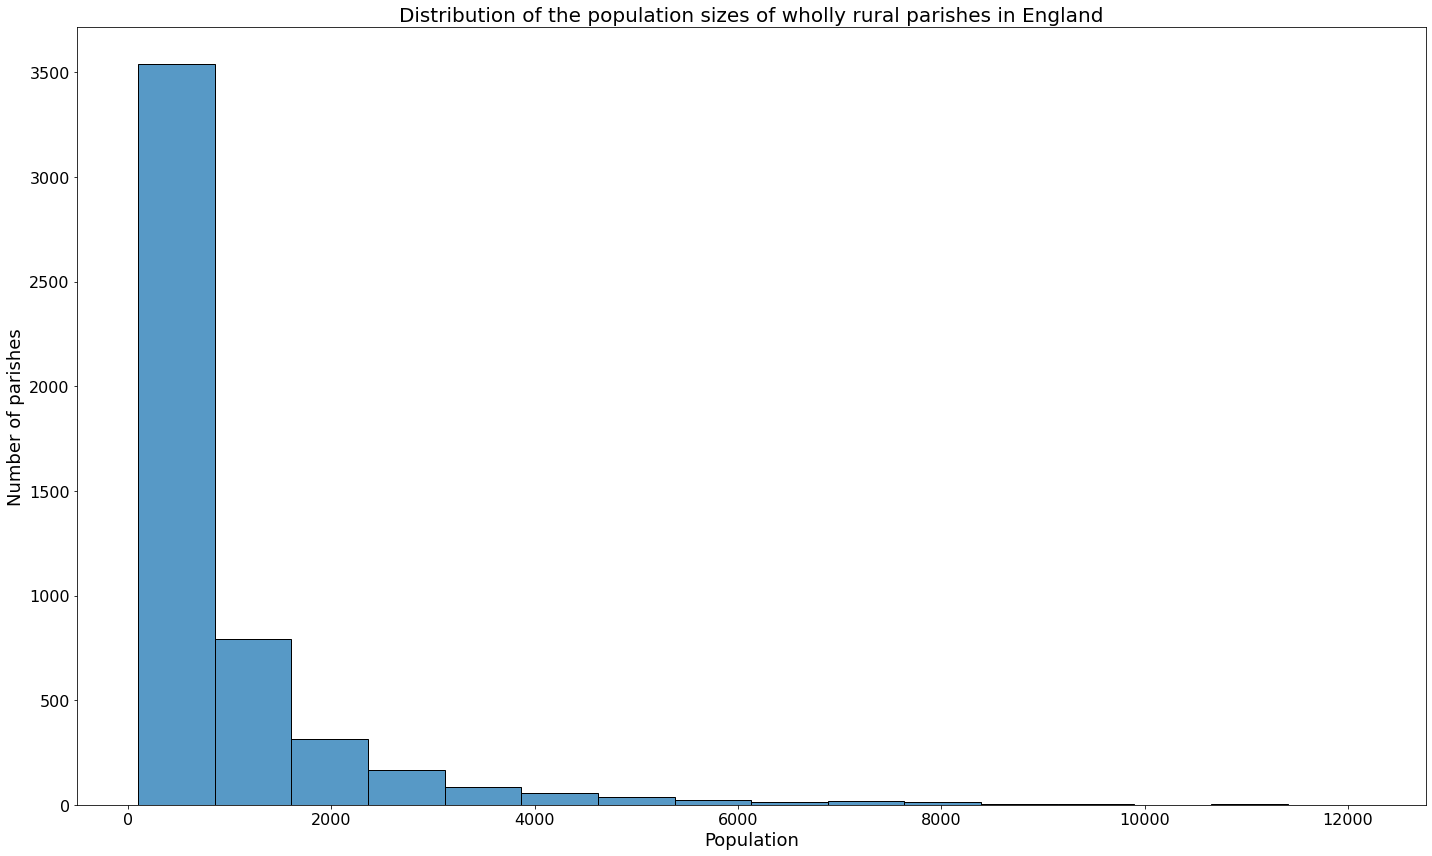

In [845]:
fig, ax = plt.subplots(figsize=(20,12))
sns.histplot(df.population.values, bins=16)
plt.xlabel('Population', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Number of parishes', fontsize=18)
plt.yticks(fontsize=16)
plt.title('Distribution of the population sizes of wholly rural parishes in England', fontsize=20)
plt.tight_layout()
plt.savefig('results/pop_distribution_rural_parishes.png')
plt.show()

## Average plots

In [846]:
df.loc[:, 'population_grouped'] = df.population.apply(
lambda x: 100*np.round(x/100) if x <= 1000 else 250*np.round(x/250) if x <= 2000 else np.round(x/1000)*1000 if x <= 5000 else np.round(x/5000)*5000
    
)


In [847]:
df.groupby(['population_grouped']).agg('mean')[to_get]

pub  place_of_worship    school
population_grouped                                      
100.0               0.272727          1.006494  0.064935
200.0               0.475638          1.140371  0.104408
300.0               0.672365          1.269231  0.207977
400.0               0.862333          1.353728  0.369025
500.0               1.035088          1.375940  0.458647
600.0               1.105802          1.440273  0.576792
700.0               1.241379          1.336207  0.771552
800.0               1.390476          1.447619  0.923810
900.0               1.280702          1.450292  0.918129
1000.0              1.651584          1.683258  0.963801
1250.0              1.851695          1.682203  1.135593
1500.0              2.055866          1.905028  1.195531
1750.0              2.107692          1.823077  1.215385
2000.0              2.186275          2.024510  1.431373
3000.0              2.766497          2.598985  1.670051
4000.0              3.532468          2.883117  1.805195
5000.0              4.656250          3.791667  2.666667
10000.0             7.750000          5.541667  4.500000

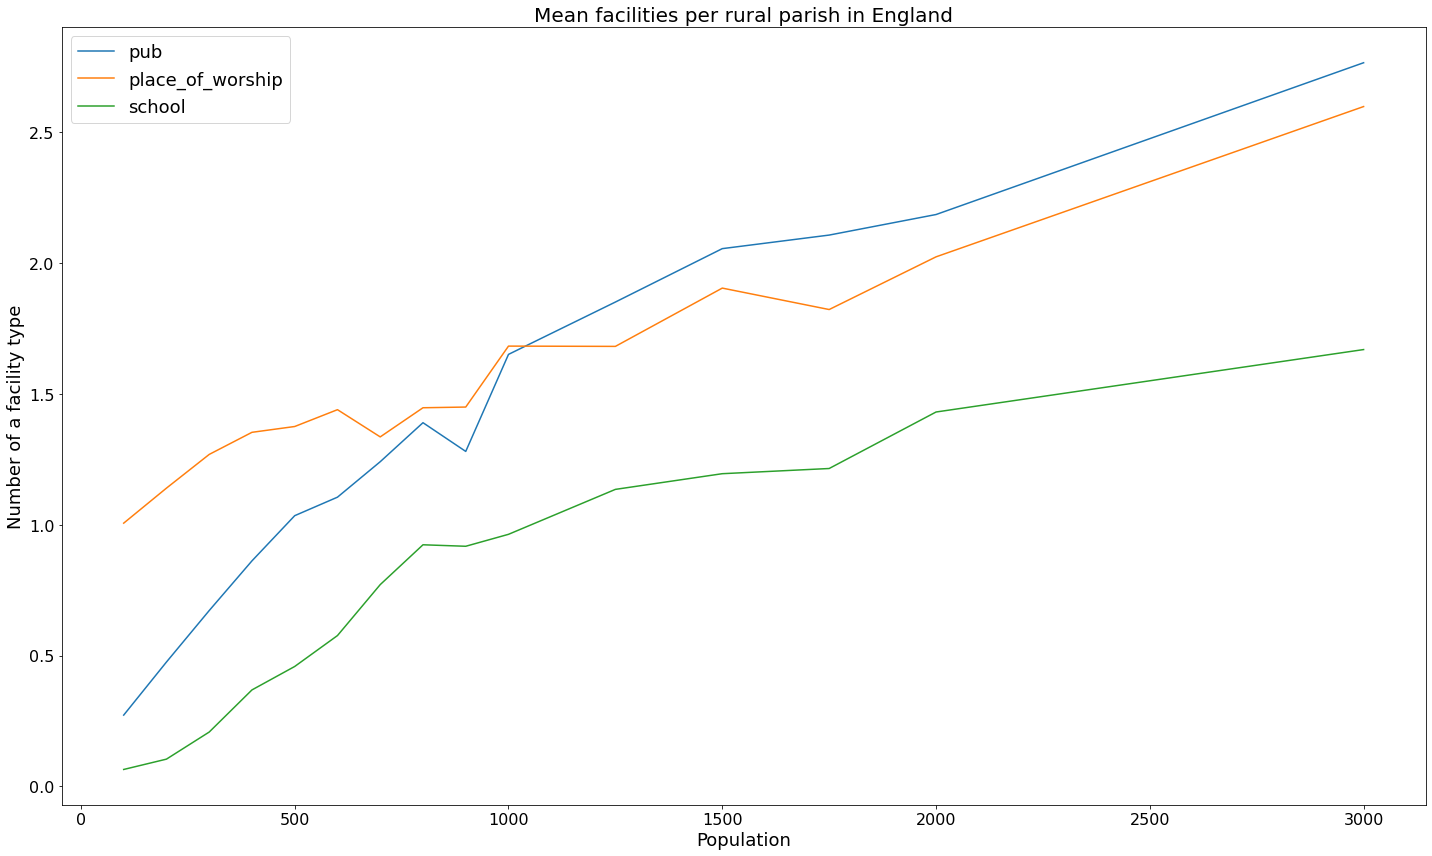

In [848]:
fig, ax = plt.subplots(figsize=(20,12))
df[df.population_grouped < 4000].groupby(['population_grouped']).agg('mean')[to_get].plot(ax=ax)
plt.xlabel('Population', fontsize=18)
plt.ylabel('Number of a facility type', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=18)
plt.title('Mean facilities per rural parish in England', fontsize=20)
plt.tight_layout()
plt.savefig('results/avg_facilities_per_rural_parish_small.png')
plt.show()

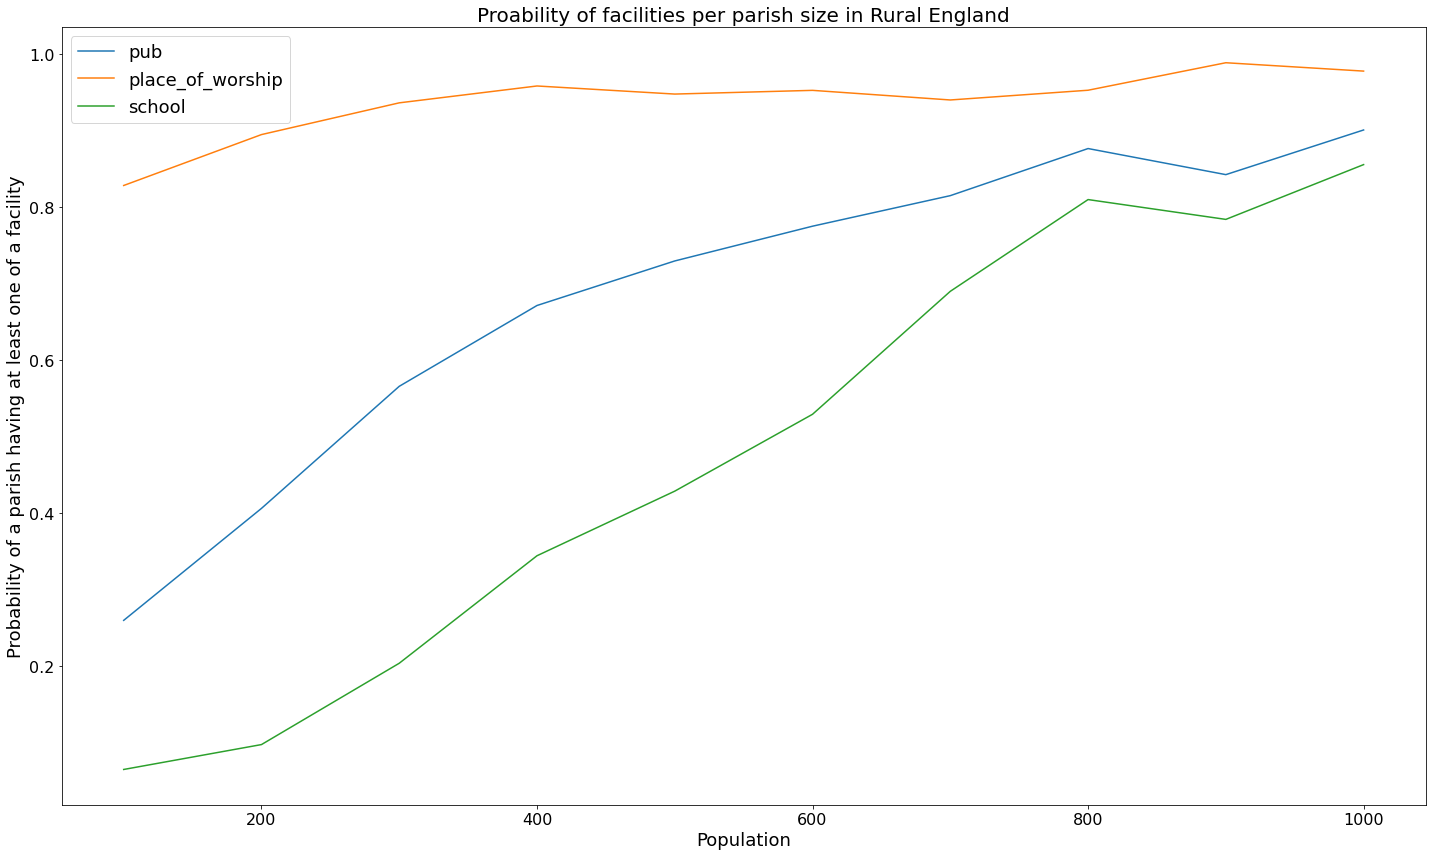

In [849]:
fig, ax = plt.subplots(figsize=(20,12))
small_parishes = df[df.population_grouped <= 1000]
for item in to_get:
    copy = small_parishes.copy()
    copy.loc[:, 'masked_item'] = copy[[item]] > 0
    copy.groupby(['population_grouped']).masked_item.agg('mean').plot(ax=ax, label=item)
plt.xlabel('Population', fontsize=18)
plt.ylabel('Probability of a parish having at least one of a facility', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=18)
plt.title('Proability of facilities per parish size in Rural England', fontsize=20)
plt.tight_layout()
plt.savefig('results/prob_facilities_per_parish.png')
plt.show()

## By Region

In [850]:
region_sizes = df.groupby(['region']).size().reset_index()
region_sizes.columns = ['region', 'num_wholly_rural_parishes']
rural_regions = region_sizes[region_sizes.num_wholly_rural_parishes >= 100].region.values

In [851]:
real_rural_regions = df[df.region.isin(rural_regions)]

In [852]:
real_rural_regions[real_rural_regions.population <= 1000].groupby(['region']).size().sort_values()

region
North West                  261
West Midlands               305
Yorkshire and The Humber    468
South East                  525
South West                  616
East Midlands               645
East of England             957
dtype: int64

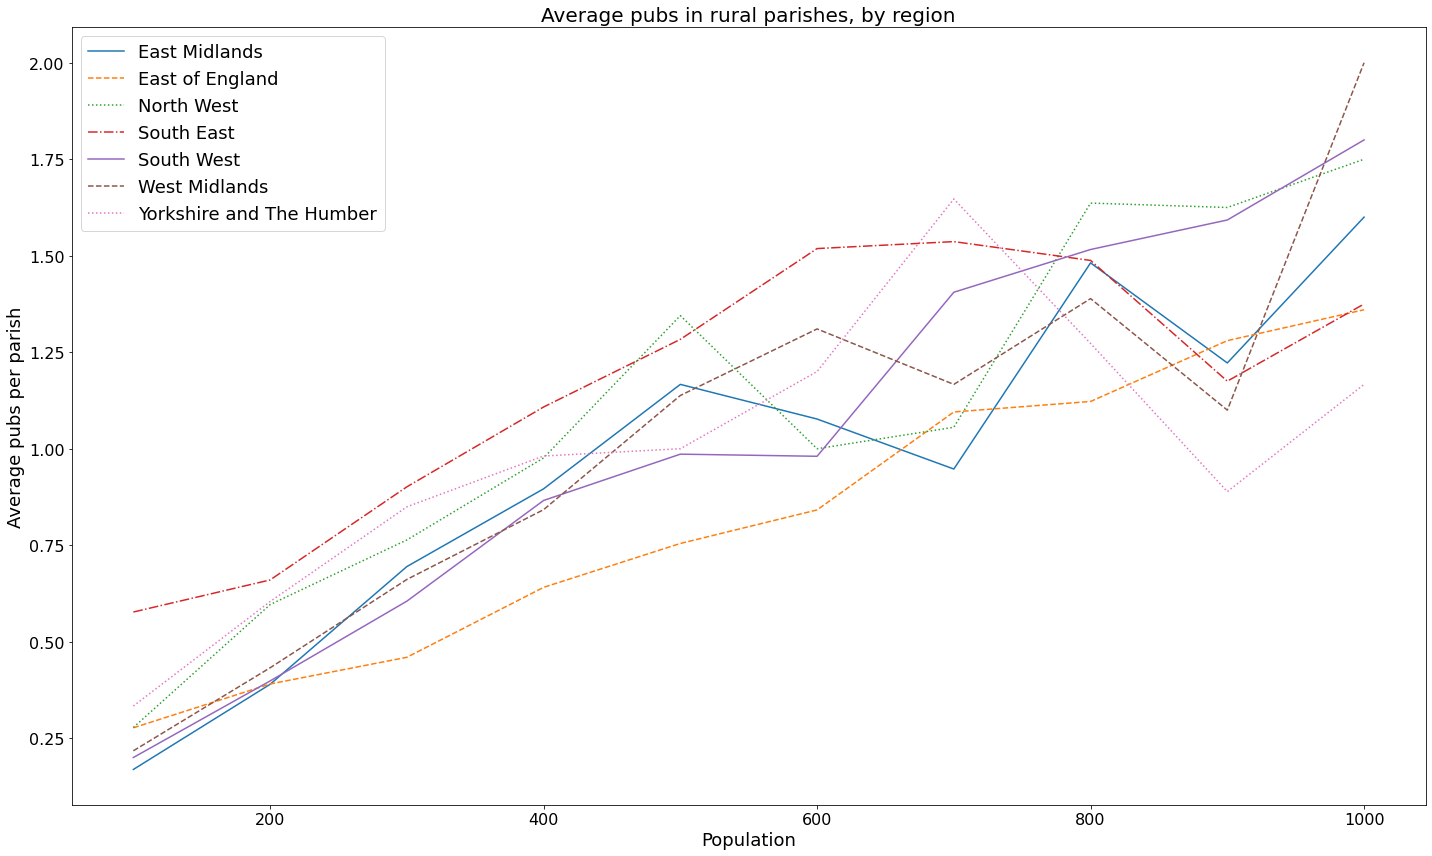

In [853]:
ls = ['-', '--', ':', '-.']
i = 0
fig, ax = plt.subplots(figsize=(20,12))
pop_range = np.arange(100,2500)
for region, frame in real_rural_regions[(real_rural_regions.population <= 1000)].groupby(['region']):
    frame.groupby(['population_grouped']).pub.agg('mean').plot(ax=ax, label=region, ls=ls[i % len(ls)])
    i += 1

plt.legend(fontsize=18)
plt.xlabel('Population', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Average pubs per parish', fontsize=18)
plt.yticks(fontsize=16)
plt.title('Average pubs in rural parishes, by region', fontsize=20)
plt.tight_layout()
plt.savefig('results/pubs_per_parish_by_region.png')
plt.show()

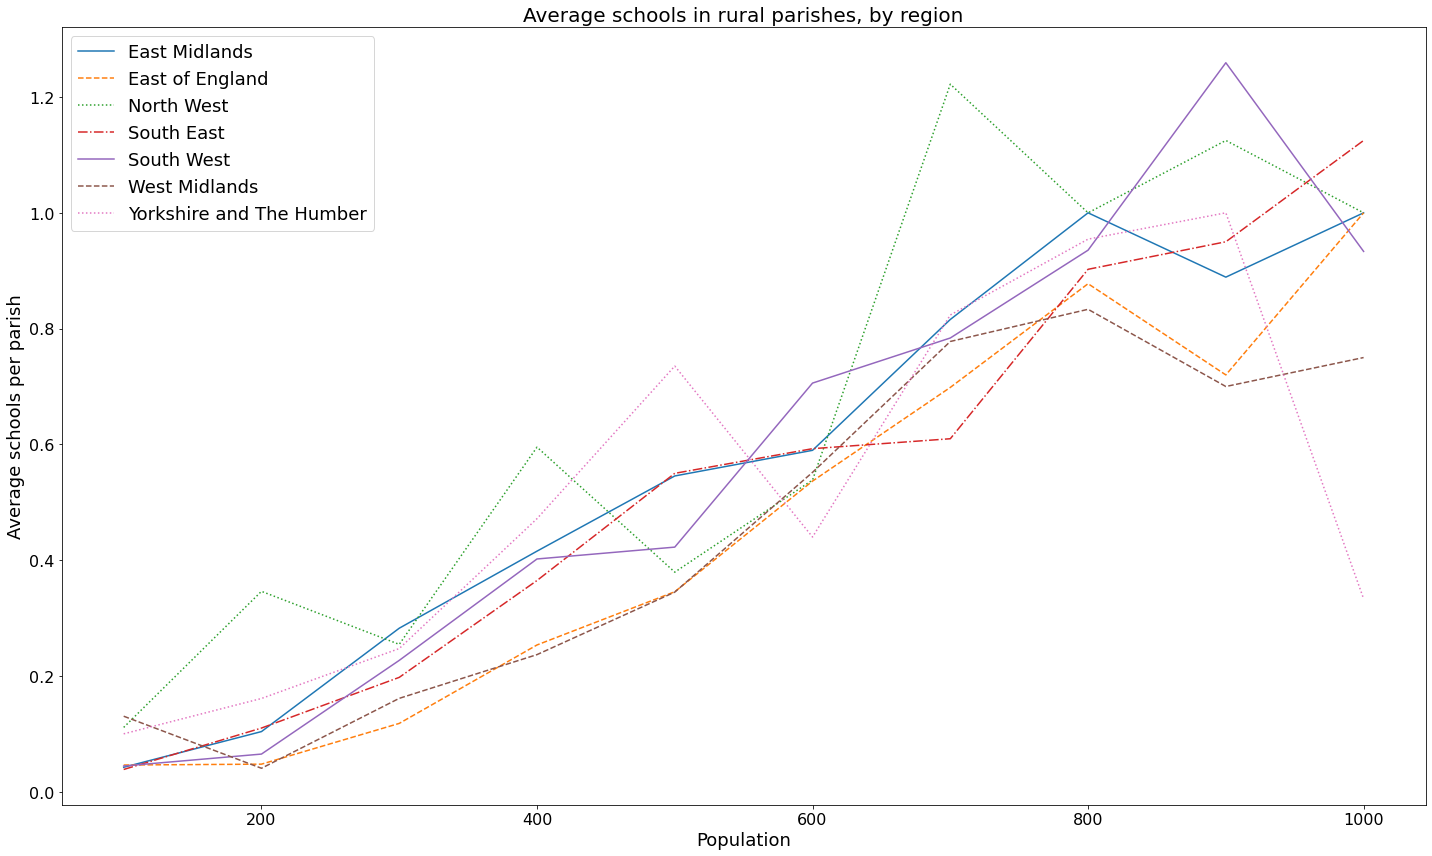

In [854]:
ls = ['-', '--', ':', '-.']
i = 0
fig, ax = plt.subplots(figsize=(20,12))
pop_range = np.arange(100,2500)
for region, frame in real_rural_regions[(real_rural_regions.population <= 1000)].groupby(['region']):
    frame.groupby(['population_grouped']).school.agg('mean').plot(ax=ax, label=region, ls=ls[i % len(ls)])
    i += 1

plt.legend(fontsize=18)
plt.xlabel('Population', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Average schools per parish', fontsize=18)
plt.yticks(fontsize=16)
plt.title('Average schools in rural parishes, by region', fontsize=20)
plt.tight_layout()
plt.savefig('results/schools_per_parish_by_region.png')
plt.show()

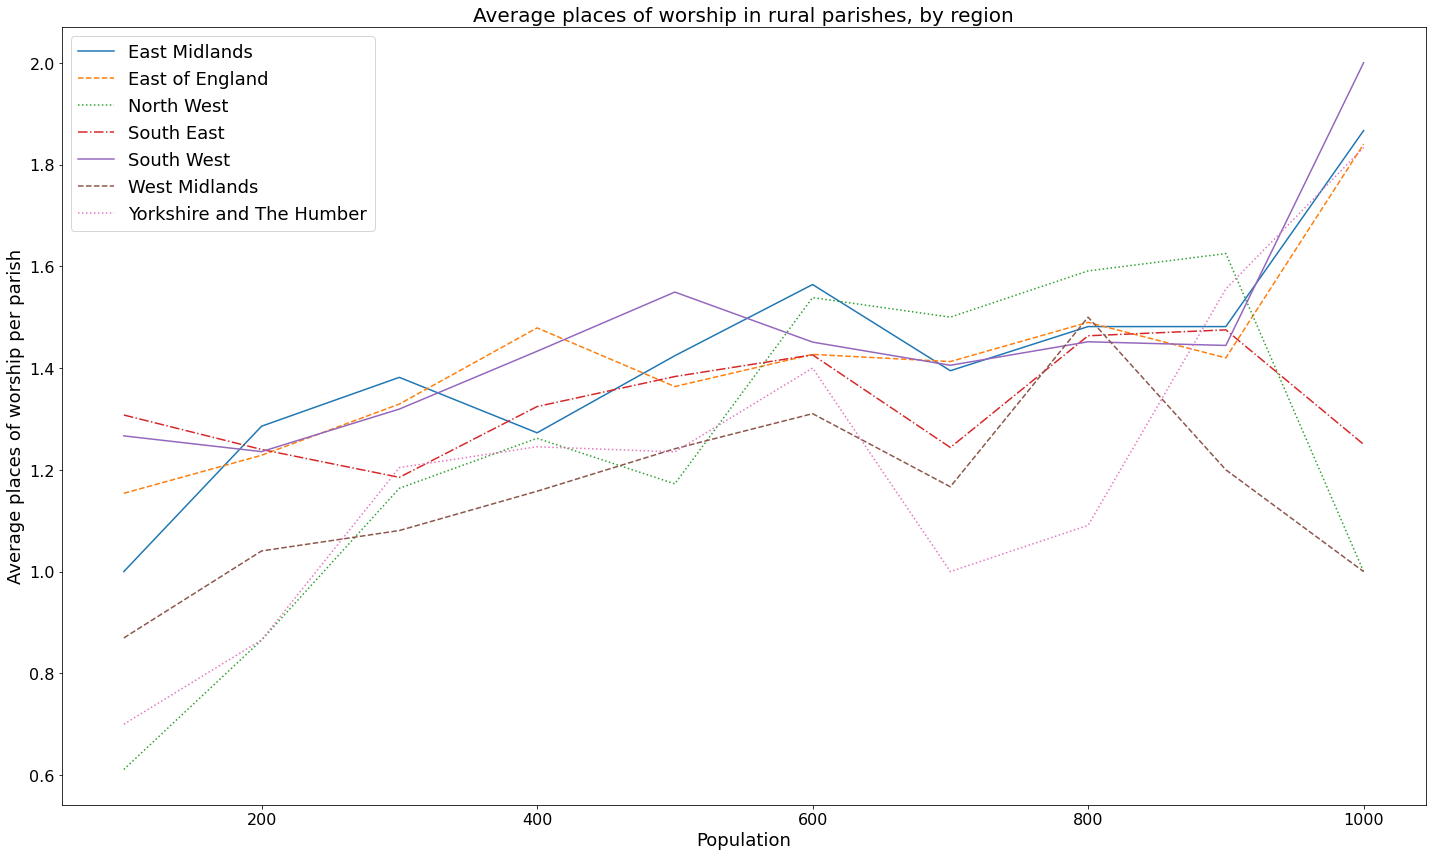

In [855]:
ls = ['-', '--', ':', '-.']
i = 0
fig, ax = plt.subplots(figsize=(20,12))
pop_range = np.arange(100,2500)
for region, frame in real_rural_regions[(real_rural_regions.population <= 1000)].groupby(['region']):
    frame.groupby(['population_grouped']).place_of_worship.agg('mean').plot(ax=ax, label=region, ls=ls[i % len(ls)])
    i += 1

plt.legend(fontsize=18)
plt.xlabel('Population', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Average places of worship per parish', fontsize=18)
plt.yticks(fontsize=16)
plt.title('Average places of worship in rural parishes, by region', fontsize=20)
plt.tight_layout()
plt.savefig('results/worship_per_parish_by_region.png')
plt.show()

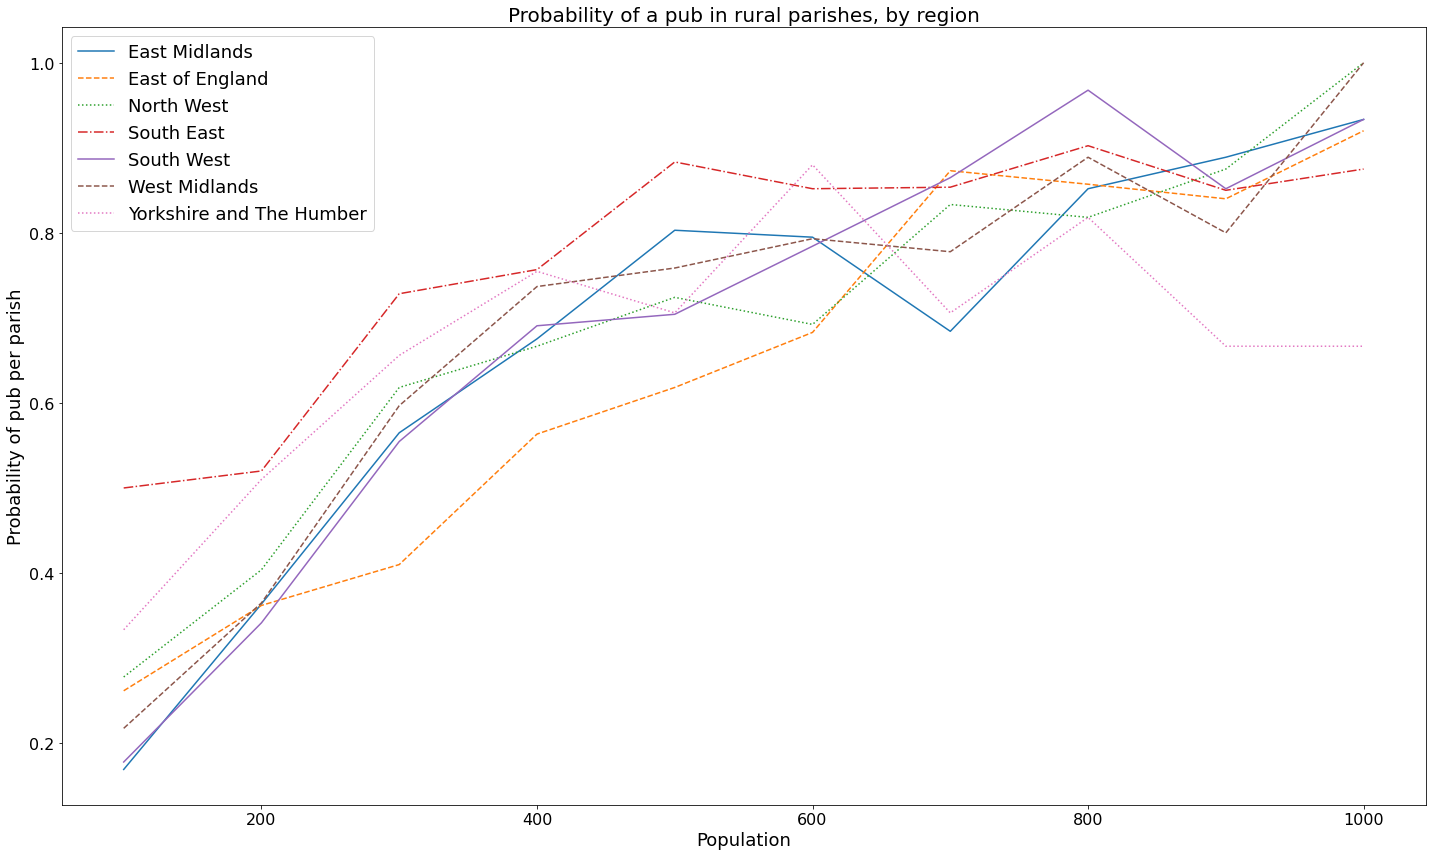

In [856]:
real_rural_regions.loc[:, 'school_bool'] = real_rural_regions.school > 0
real_rural_regions.loc[:, 'school_bool'] = real_rural_regions.school_bool.astype(int)
real_rural_regions.loc[:, 'pub_bool'] = real_rural_regions.pub > 0
real_rural_regions.loc[:, 'pub_bool'] = real_rural_regions.pub_bool.astype(int)
real_rural_regions.loc[:, 'worship_bool'] = real_rural_regions.place_of_worship > 0
real_rural_regions.loc[:, 'worship_bool'] = real_rural_regions.worship_bool.astype(int)

ls = ['-', '--', ':', '-.']
i = 0
fig, ax = plt.subplots(figsize=(20,12))
pop_range = np.arange(100,2500)
for region, frame in real_rural_regions[(real_rural_regions.population <= 1000)].groupby(['region']):
    frame.groupby(['population_grouped']).pub_bool.agg('mean').plot(ax=ax, label=region, ls=ls[i % len(ls)])
    i += 1

plt.legend(fontsize=18)
plt.xlabel('Population', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Probability of pub per parish', fontsize=18)
plt.yticks(fontsize=16)
plt.title('Probability of a pub in rural parishes, by region', fontsize=20)
plt.tight_layout()
plt.savefig('results/prob_pubs_per_parish_by_region.png')
plt.show()

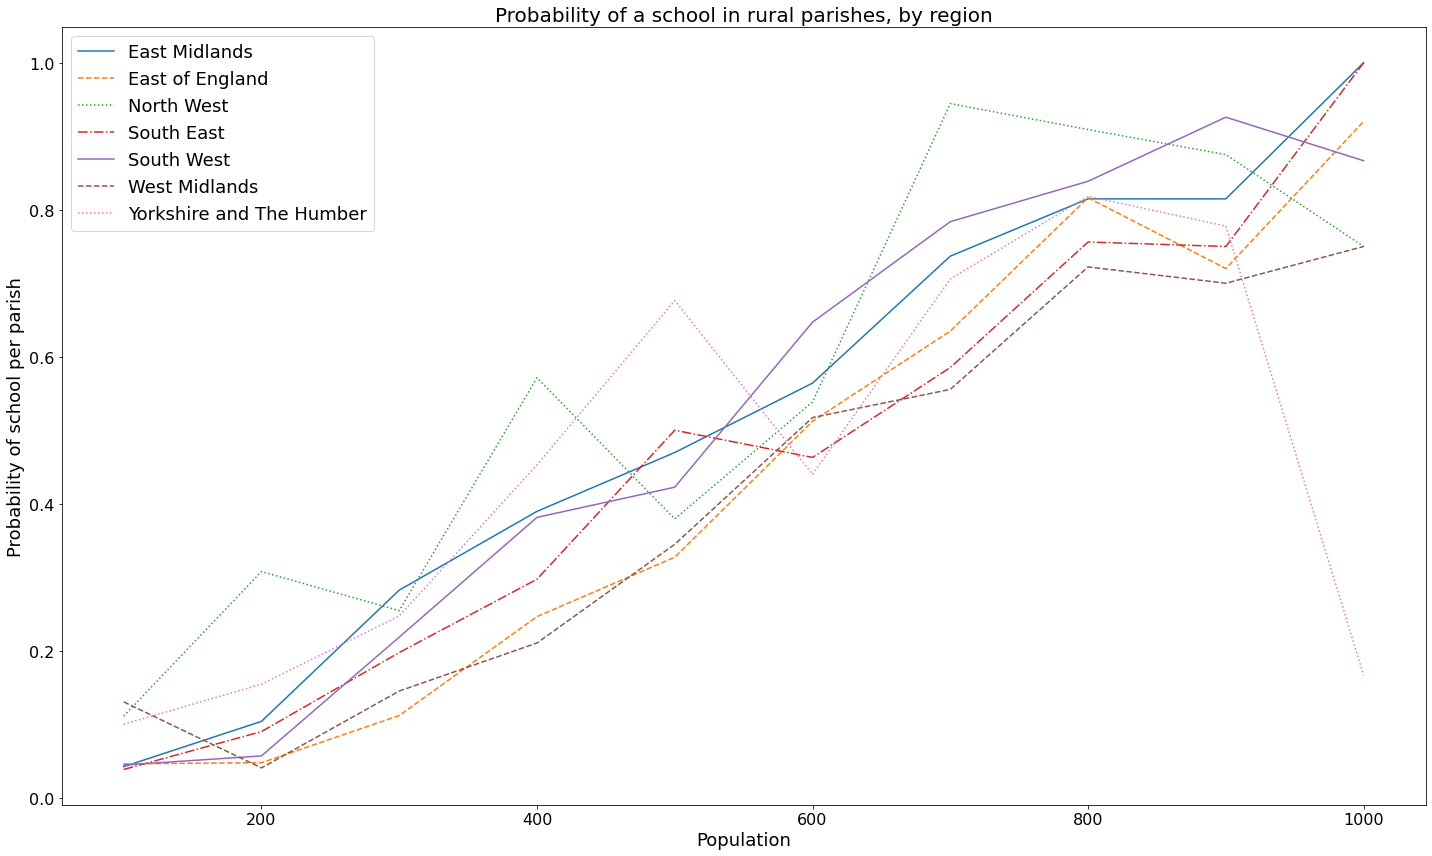

In [857]:
ls = ['-', '--', ':', '-.']
i = 0
fig, ax = plt.subplots(figsize=(20,12))
pop_range = np.arange(100,2500)
for region, frame in real_rural_regions[(real_rural_regions.population <= 1000)].groupby(['region']):
    frame.groupby(['population_grouped']).school_bool.agg('mean').plot(ax=ax, label=region, ls=ls[i % len(ls)])
    i += 1

plt.legend(fontsize=18)
plt.xlabel('Population', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Probability of school per parish', fontsize=18)
plt.yticks(fontsize=16)
plt.title('Probability of a school in rural parishes, by region', fontsize=20)
plt.tight_layout()
plt.savefig('results/prob_schools_per_parish_by_region.png')
plt.show()

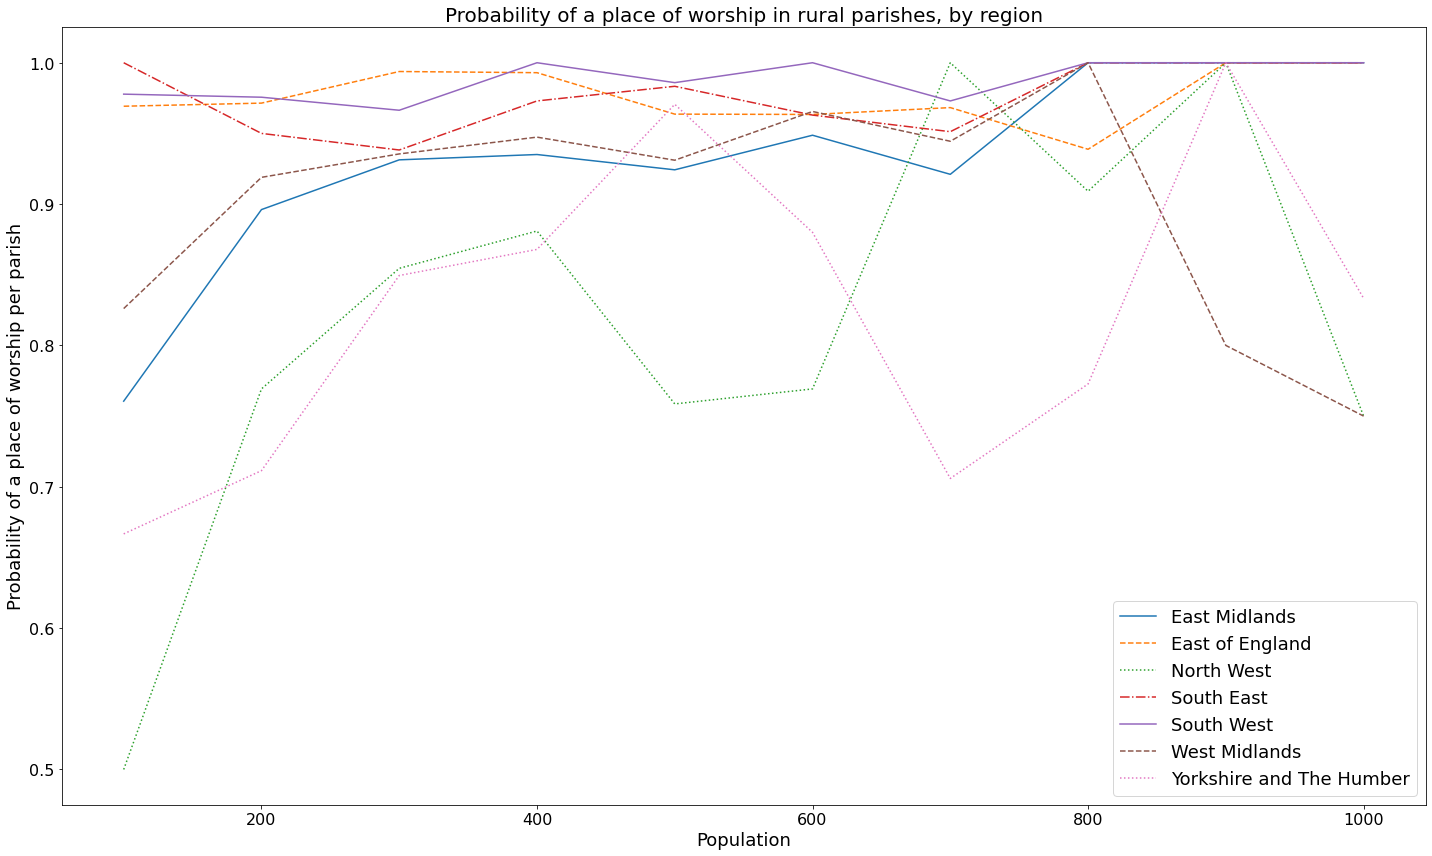

In [858]:
ls = ['-', '--', ':', '-.']
i = 0
fig, ax = plt.subplots(figsize=(20,12))
pop_range = np.arange(100,2500)
for region, frame in real_rural_regions[(real_rural_regions.population <= 1000)].groupby(['region']):
    frame.groupby(['population_grouped']).worship_bool.agg('mean').plot(ax=ax, label=region, ls=ls[i % len(ls)])
    i += 1

plt.legend(fontsize=18)
plt.xlabel('Population', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Probability of a place of worship per parish', fontsize=18)
plt.yticks(fontsize=16)
plt.title('Probability of a place of worship in rural parishes, by region', fontsize=20)
plt.tight_layout()
plt.savefig('results/prob_worship_per_parish_by_region.png')
plt.show()

### Regional differences in dependent variables

In [1185]:
real_rural_regions.head()

pub  place_of_worship  school  population           name          area  \
0    2                 2       1        1203  Bradleys Both  7.898754e+06   
1    2                 1       1        1469       Cononley  6.695996e+06   
2    0                 1       0         481       Farnhill  1.691419e+06   
3    1                 2       1         222       Kildwick  3.710505e+06   
4    1                 2       1         509    Lothersdale  1.084977e+07   

            county                    region  weighted_imd  \
0  North Yorkshire  Yorkshire and The Humber       30238.0   
1  North Yorkshire  Yorkshire and The Humber       23934.0   
2  North Yorkshire  Yorkshire and The Humber       30238.0   
3  North Yorkshire  Yorkshire and The Humber       30238.0   
4  North Yorkshire  Yorkshire and The Humber       23934.0   

   population_grouped  school_bool  pub_bool  worship_bool  \
0              1250.0            1         1             1   
1              1500.0            1         1             1   
2               500.0            0         0             1   
3               200.0            1         1             1   
4               500.0            1         1             1   

   schools_per_person  pubs_per_person  worship_per_person  
0            0.000831         0.001663            0.001663  
1            0.000681         0.001361            0.000681  
2            0.000000         0.000000            0.002079  
3            0.004505         0.004505            0.009009  
4            0.001965         0.001965            0.003929

In [1186]:
real_rural_regions.groupby(['region']).weighted_imd.agg('mean').sort_values()

region
South West                  17729.923751
East of England             18569.391525
East Midlands               18918.214492
North West                  19171.815449
Yorkshire and The Humber    20286.359220
West Midlands               20454.982437
South East                  20607.924602
Name: weighted_imd, dtype: float64

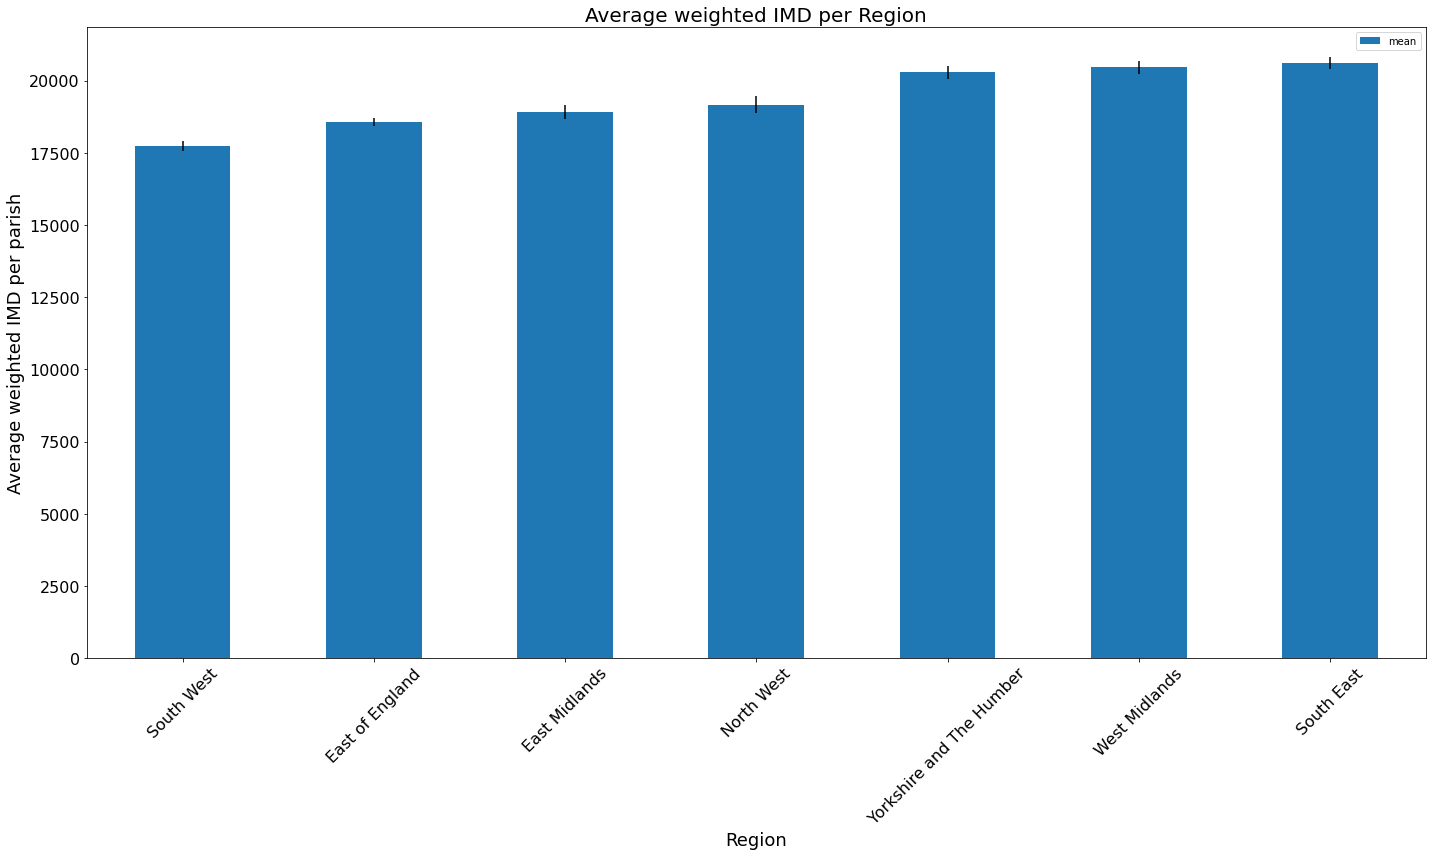

In [1214]:
handy = real_rural_regions.groupby(['region']).weighted_imd.agg(['mean', 'sem']).sort_values(by='mean')
fig, ax = plt.subplots(figsize=(20,12))
handy.plot(kind='bar', yerr='sem', ax=ax, rot=45)
plt.tight_layout()
#plt.legend(None)
plt.xlabel('Region', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Average weighted IMD per parish', fontsize=18)
plt.title('Average weighted IMD per Region', fontsize=20)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('results/imd_per_region.png')
plt.show()

In [1199]:
real_rural_regions.groupby(['region']).pub.agg(['mean', 'sem']).sort_values(by='mean')

mean       sem
region                                      
East of England           0.961508  0.029163
East Midlands             1.106880  0.045561
South West                1.167920  0.045479
Yorkshire and The Humber  1.192374  0.066498
West Midlands             1.363636  0.085584
North West                1.653005  0.129286
South East                1.678484  0.052077

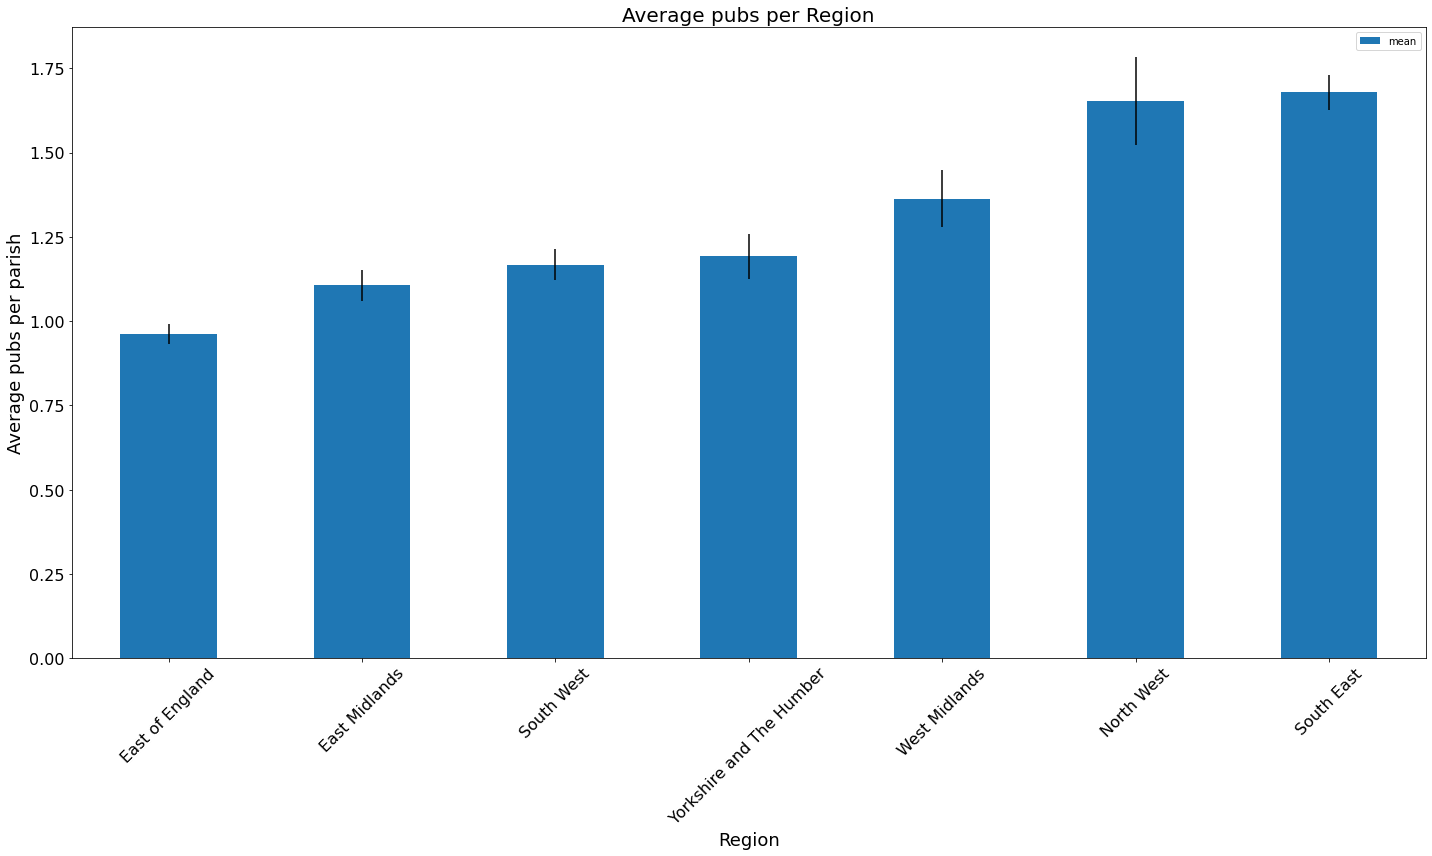

In [1215]:
handy = real_rural_regions.groupby(['region']).pub.agg(['mean', 'sem']).sort_values(by='mean')
fig, ax = plt.subplots(figsize=(20,12))
handy.plot(kind='bar', yerr='sem', ax=ax, rot=45)
plt.tight_layout()
#plt.legend(None)
plt.xlabel('Region', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Average pubs per parish', fontsize=18)
plt.title('Average pubs per Region', fontsize=20)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('results/pub_per_region.png')
plt.show()

In [1200]:
real_rural_regions.groupby(['region']).school.agg(['mean', 'sem']).sort_values(by='mean')

mean       sem
region                                      
Yorkshire and The Humber  0.556326  0.035819
East of England           0.566379  0.021067
South West                0.604010  0.025663
East Midlands             0.616708  0.028996
West Midlands             0.641148  0.044693
South East                0.827628  0.035804
North West                0.920765  0.057566

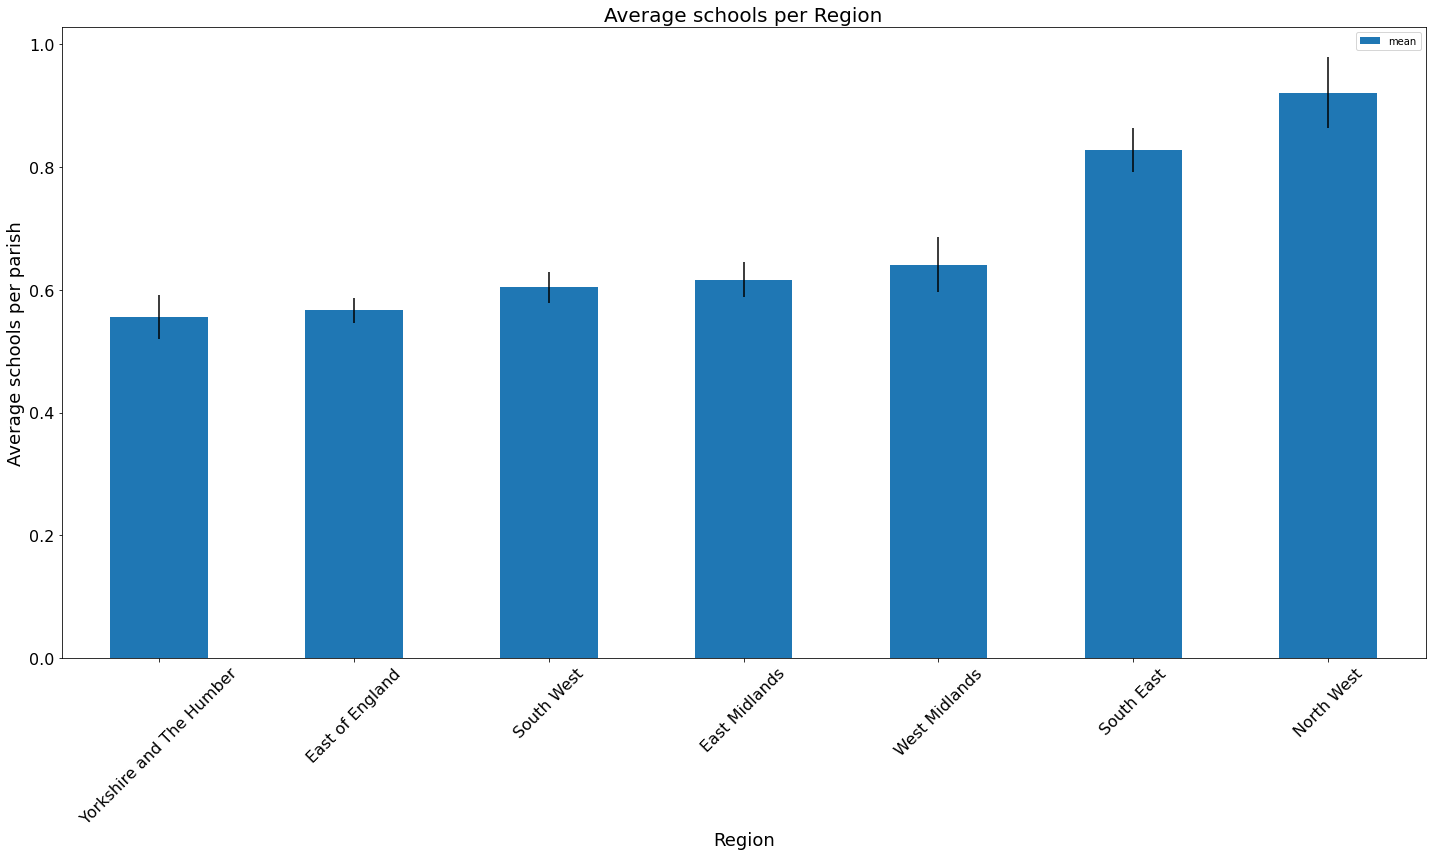

In [1216]:
handy = real_rural_regions.groupby(['region']).school.agg(['mean', 'sem']).sort_values(by='mean')
fig, ax = plt.subplots(figsize=(20,12))
handy.plot(kind='bar', yerr='sem', ax=ax, rot=45)
plt.tight_layout()
#plt.legend(None)
plt.xlabel('Region', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Average schools per parish', fontsize=18)
plt.title('Average schools per Region', fontsize=20)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('results/schools_per_region.png')
plt.show()

In [1201]:
real_rural_regions.groupby(['region']).place_of_worship.agg(['mean', 'sem']).sort_values(by='mean')

mean       sem
region                                      
Yorkshire and The Humber  1.233969  0.042184
West Midlands             1.454545  0.048832
East Midlands             1.506143  0.036579
East of England           1.534171  0.025352
South West                1.604010  0.036791
South East                1.623472  0.037624
North West                1.663934  0.082155

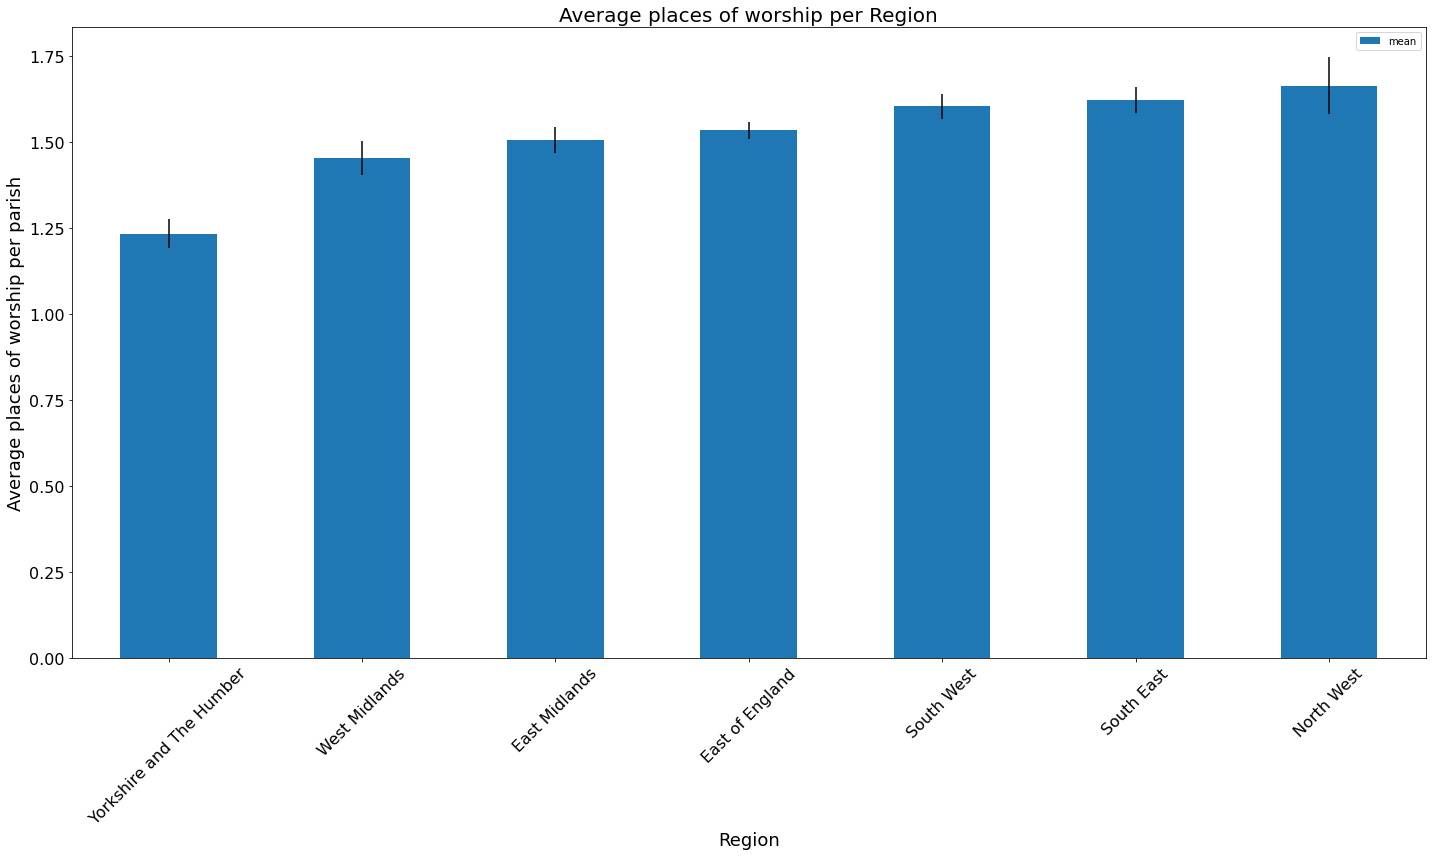

In [1217]:
handy = real_rural_regions.groupby(['region']).place_of_worship.agg(['mean', 'sem']).sort_values(by='mean')
fig, ax = plt.subplots(figsize=(20,12))
handy.plot(kind='bar', yerr='sem', ax=ax, rot=45)
plt.tight_layout()
#plt.legend(None)
plt.xlabel('Region', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Average places of worship per parish', fontsize=18)
plt.title('Average places of worship per Region', fontsize=20)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('results/worship_per_region.png')
plt.show()

In [1202]:
real_rural_regions.groupby(['region']).population.agg(['mean', 'sem']).sort_values(by='mean')

mean        sem
region                                          
Yorkshire and The Humber   720.083189  45.113667
South West                 779.291980  31.617889
East Midlands              796.042998  37.379221
East of England            892.502749  31.712326
West Midlands              917.031100  58.331368
North West                1064.702186  77.079401
South East                1197.189487  48.684423

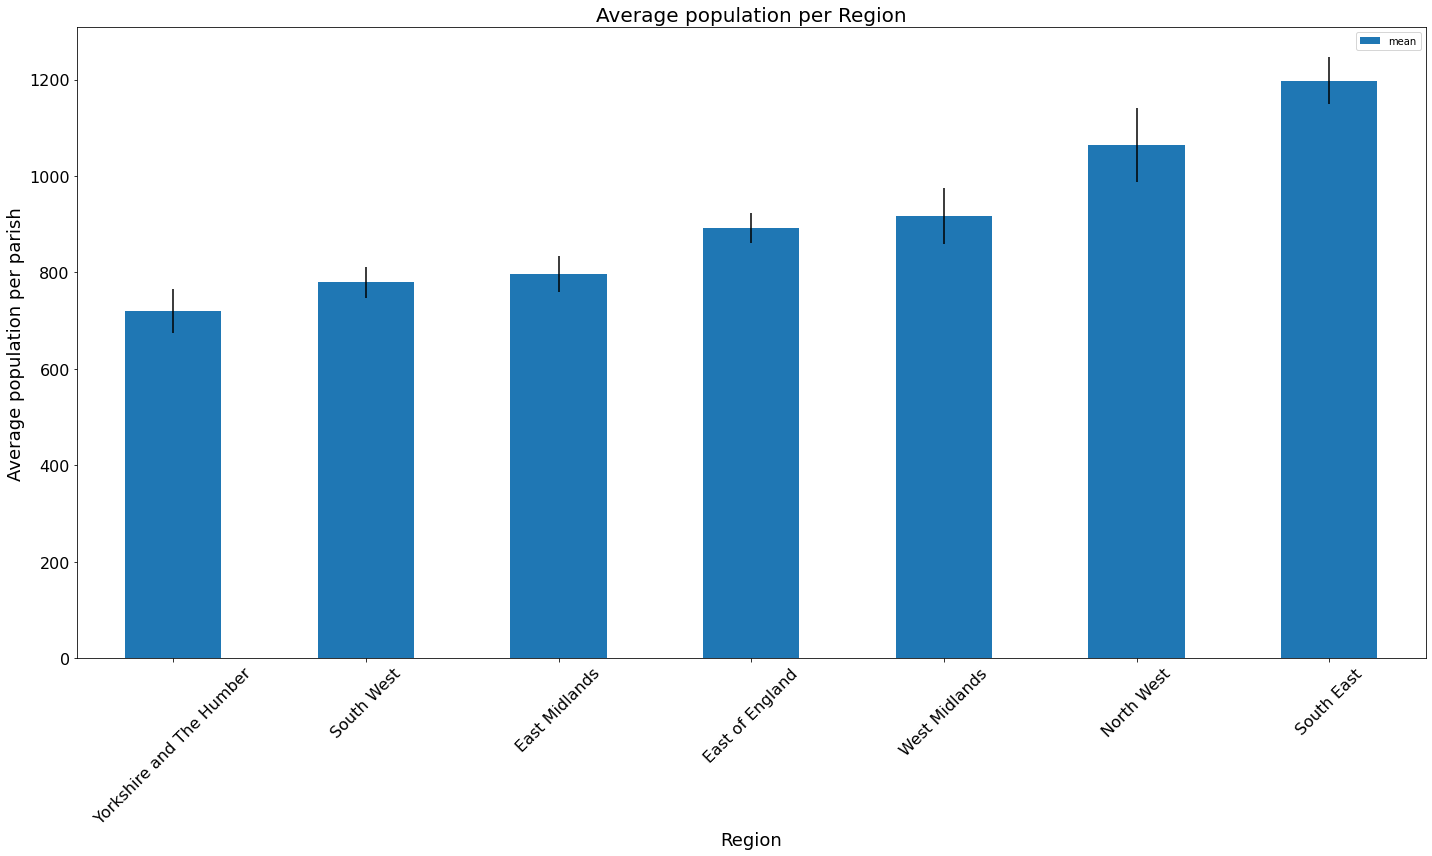

In [1218]:
handy = real_rural_regions.groupby(['region']).population.agg(['mean', 'sem']).sort_values(by='mean')
fig, ax = plt.subplots(figsize=(20,12))
handy.plot(kind='bar', yerr='sem', ax=ax, rot=45)
plt.tight_layout()
#plt.legend(None)
plt.xlabel('Region', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Average population per parish', fontsize=18)
plt.title('Average population per Region', fontsize=20)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('results/population_per_region.png')
plt.show()

In [1203]:
real_rural_regions.groupby(['region']).area.agg(['mean','sem']).sort_values(by='mean')

mean           sem
region                                              
East of England           9.758333e+06  1.679430e+05
West Midlands             1.033817e+07  3.739264e+05
East Midlands             1.043814e+07  2.661419e+05
South East                1.173765e+07  2.723818e+05
Yorkshire and The Humber  1.209722e+07  4.985393e+05
South West                1.256206e+07  3.113705e+05
North West                2.077311e+07  1.067502e+06

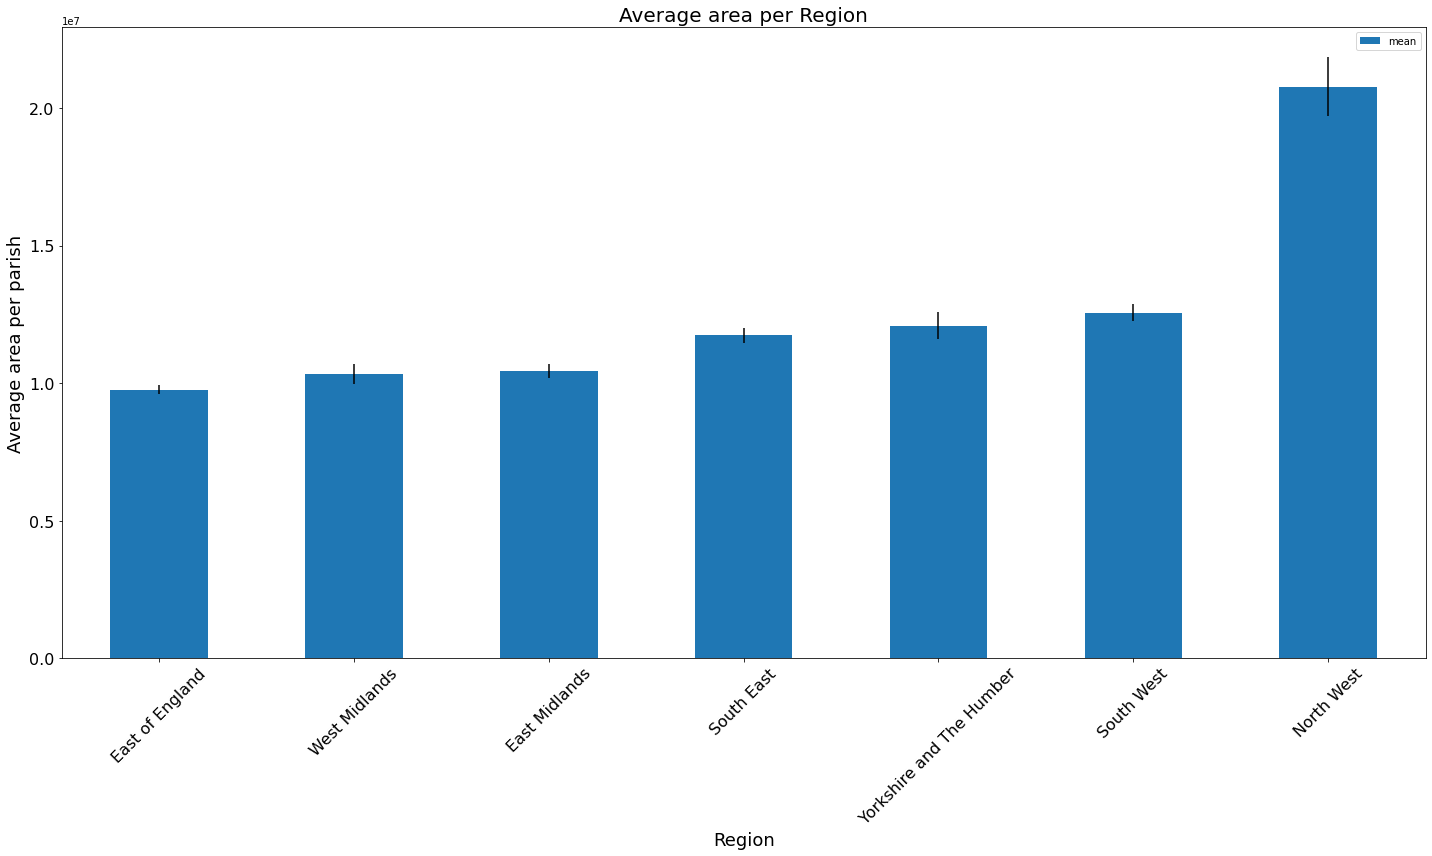

In [1219]:
handy = real_rural_regions.groupby(['region']).area.agg(['mean', 'sem']).sort_values(by='mean')
fig, ax = plt.subplots(figsize=(20,12))
handy.plot(kind='bar', yerr='sem', ax=ax, rot=45)
plt.tight_layout()
#plt.legend(None)
plt.xlabel('Region', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Average area per parish', fontsize=18)
plt.title('Average area per Region', fontsize=20)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('results/area_per_region.png')
plt.show()

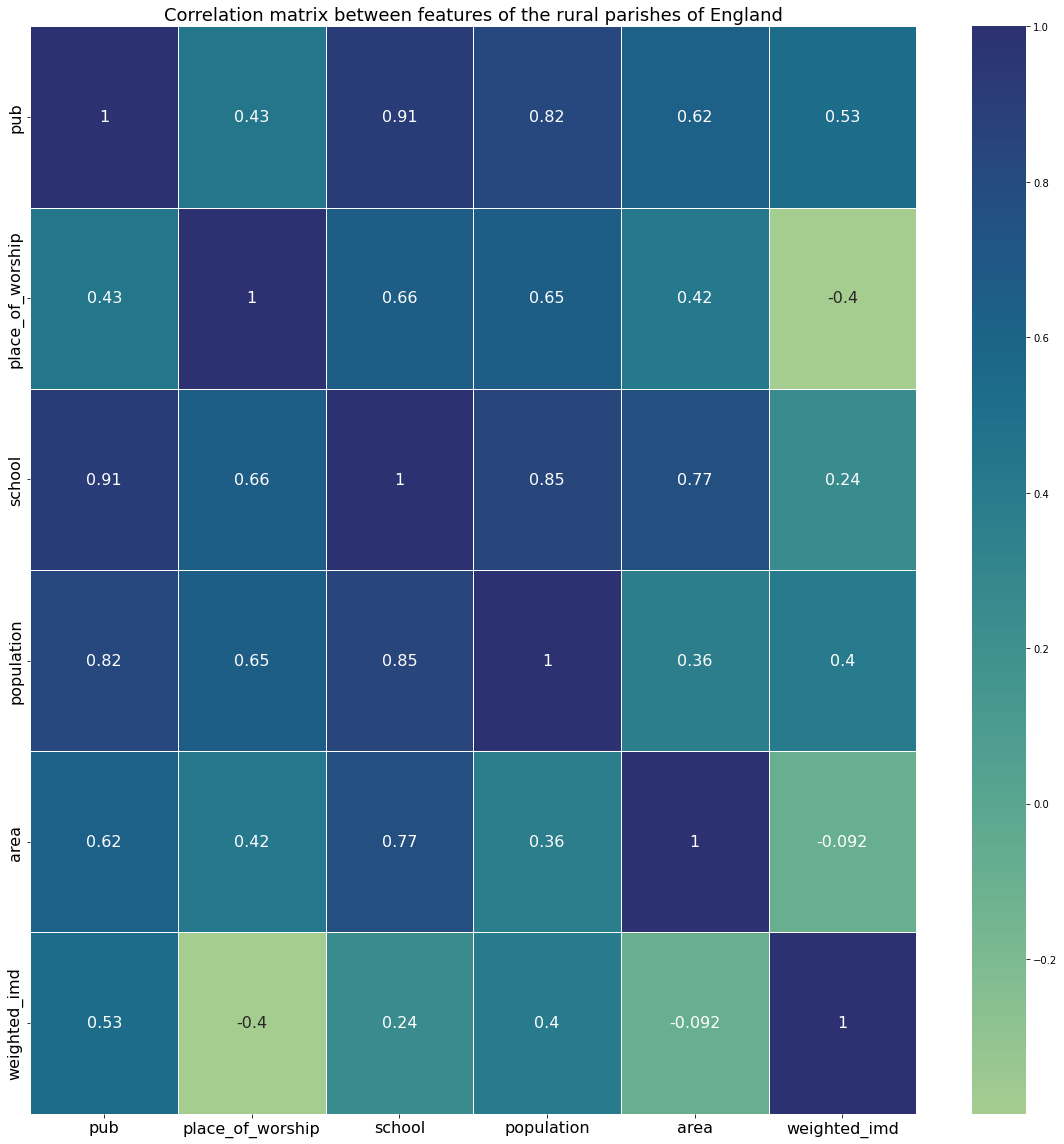

In [1229]:
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(
    real_rural_regions.groupby(['region'])[['pub', 'place_of_worship', 'school', 'population', 'area', 'weighted_imd']].agg('mean').corr(),
    ax=ax,
    annot=True,
    linewidth=.5,
    cmap='crest',
    annot_kws={'size': 16}
)
plt.title('Correlation matrix between features of the rural parishes of England', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('results/correlation_matrix.png')
plt.show()

## Pub model

In [864]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [865]:
to_keep = ['pub', 'school', 'place_of_worship', 'weighted_imd', 'area', 'region', 'population', 'name']
predictor_frame = real_rural_regions[(to_keep)]
predictor_frame.head()

pub  school  place_of_worship  weighted_imd          area  \
0    2       1                 2       30238.0  7.898754e+06   
1    2       1                 1       23934.0  6.695996e+06   
2    0       0                 1       30238.0  1.691419e+06   
3    1       1                 2       30238.0  3.710505e+06   
4    1       1                 2       23934.0  1.084977e+07   

                     region  population           name  
0  Yorkshire and The Humber        1203  Bradleys Both  
1  Yorkshire and The Humber        1469       Cononley  
2  Yorkshire and The Humber         481       Farnhill  
3  Yorkshire and The Humber         222       Kildwick  
4  Yorkshire and The Humber         509    Lothersdale

### Calculate dispersion statistic

In [1084]:
scaled_real_fac

[2571, 1961, 369, 97, 41, -1731]

In [1120]:
predictor_frame[['pub', 'school', 'place_of_worship']].apply(lambda x: np.percentile(x, 99.5))

pub                 8.0
school              4.0
place_of_worship    6.0
dtype: float64

In [1121]:
buckets = 8
for fac in to_get:
    mean = np.mean(predictor_frame[fac])
    e_fac = [(np.exp(-mean) * math.pow(mean, i))/math.factorial(i) for i in range(buckets)]
    scaled_e_fac = [i*predictor_frame.shape[0] for i in e_fac]
    real_fac = predictor_frame.groupby([fac]).size()
    real_fac = real_fac.to_dict() 
    scaled_real_fac = [real_fac.get(i, 0) for i, j in enumerate(scaled_e_fac)]
    ## Add last bucket
    scaled_real_fac.append(predictor_frame[fac].shape[0] - np.sum(scaled_real_fac))
    scaled_e_fac.append(predictor_frame.shape[0] - np.sum(scaled_e_fac))    
    dof = len(scaled_real_fac) - 1
    loss_list = [((scaled_real_fac[i] - scaled_e_fac[i])**2)/scaled_e_fac[i] for i in range(len(scaled_real_fac))]
    dispersion = np.sum(loss_list)/dof
    contingency_table = [scaled_real_fac, scaled_e_fac]
#    print(contingency_table)
    stat, p, dof_2, expected = stats.chi2_contingency(contingency_table)
#    print("Dispersion for {0} is {1} (with {2} d.o.f)".format(fac, dispersion, dof))
    print("Stat for {0} is {1} (with p-value {2} and {3} d.o.f, dispersion is {4})".format(fac, stat, p, dof_2, stat/dof_2))

Stat for pub is 157.21273430062817 (with p-value 6.117696611126127e-30 and 8 d.o.f, dispersion is 19.65159178757852)
Stat for place_of_worship is 890.7262954035198 (with p-value 5.651487914399843e-187 and 8 d.o.f, dispersion is 111.34078692543997)
Stat for school is 84.79746757347318 (with p-value 5.265572717616862e-15 and 8 d.o.f, dispersion is 10.599683446684148)


### Facilities per person

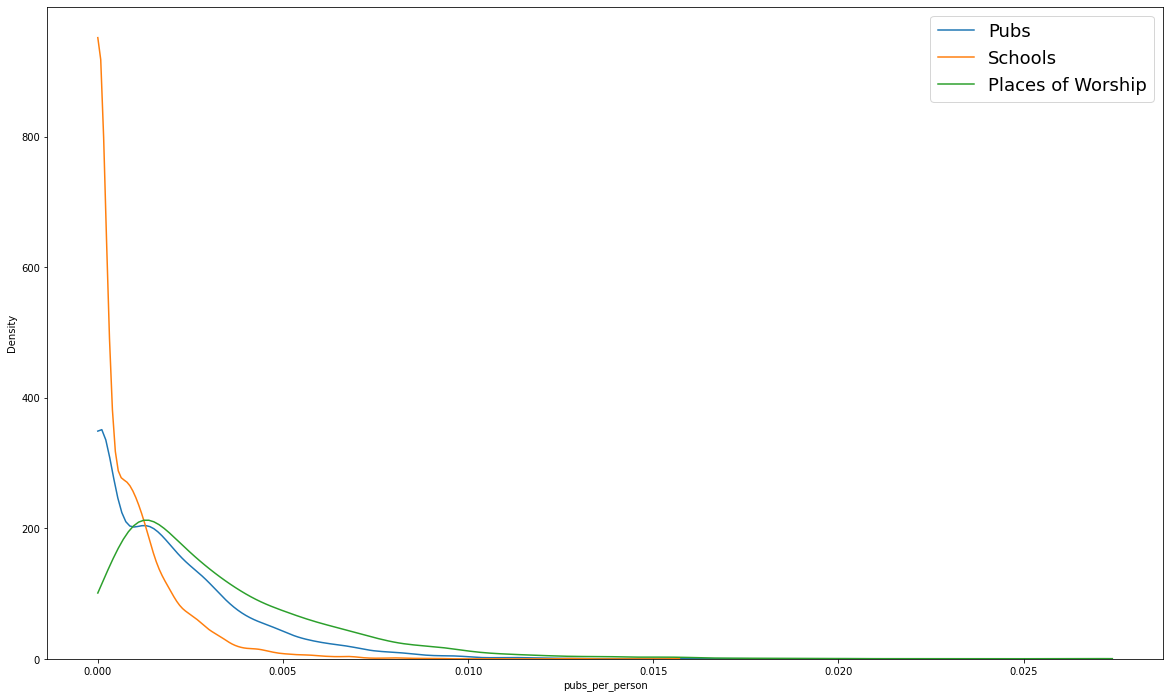

In [1135]:
predictor_frame.loc[:, 'pubs_per_person'] = predictor_frame.pub / predictor_frame.population
predictor_frame.loc[:, 'schools_per_person'] = predictor_frame.school / predictor_frame.population
predictor_frame.loc[:, 'worship_per_person'] = predictor_frame.place_of_worship / predictor_frame.population
fig, ax = plt.subplots(figsize=(20,12))
sns.kdeplot(predictor_frame.pubs_per_person, cut=0, label='Pubs', ax=ax)
sns.kdeplot(predictor_frame.schools_per_person, cut=0, label='Schools', ax=ax)
sns.kdeplot(predictor_frame.worship_per_person, cut=0, label='Places of Worship', ax=ax)
plt.legend(fontsize=18)
plt.show()

In [1136]:
def make_fittedvalues_resid_plot(fit):
    plt.figure()
    plt.scatter(fit.fittedvalues, fit.resid, color='b')
    plt.axhline(y=0, color='r')
    plt.xlabel("Fitted value")
    plt.ylabel("Residual")
    return

/var/folders/zs/1hvc18dn7v94z77k1xy7g90c0000gn/T/ipykernel_22568/1297800702.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.plotting.scatter_matrix(


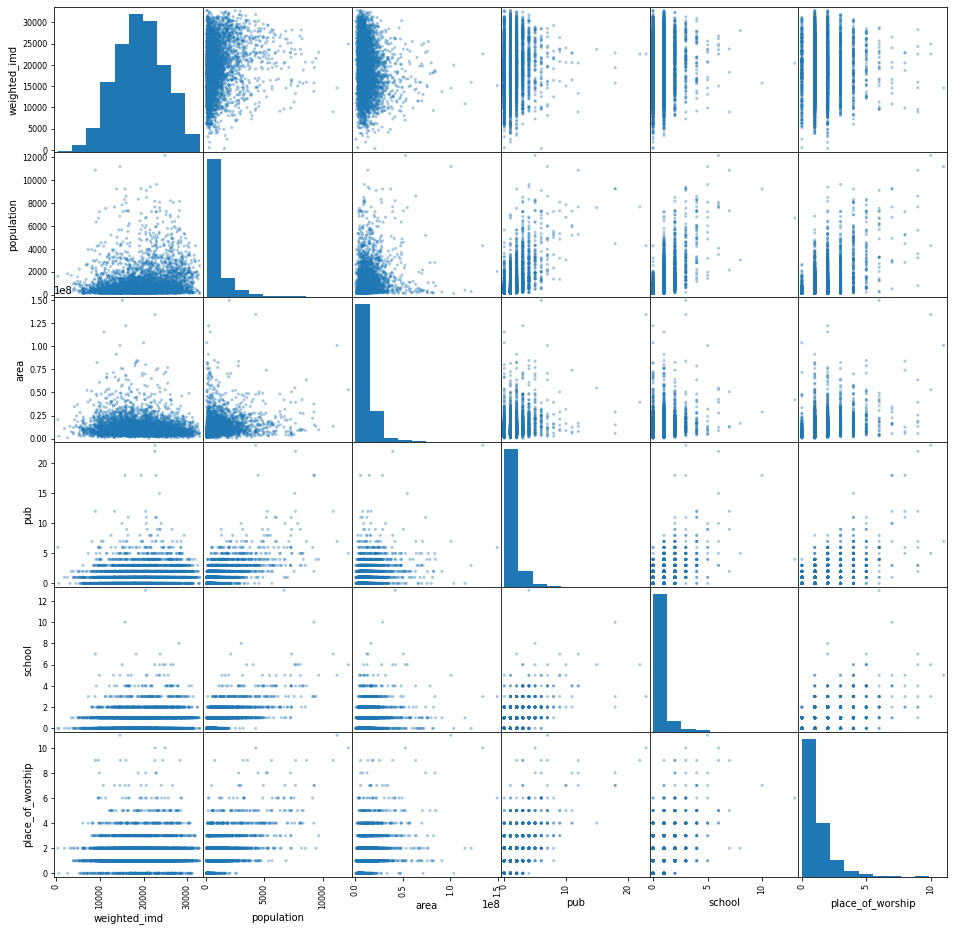

In [1137]:
fig, ax = plt.subplots(figsize=(16,16))
pd.plotting.scatter_matrix(
    predictor_frame[[
      'weighted_imd',
        'population',
        'area',
        'pub',
        'school',
        'place_of_worship'
    ]],
    alpha=0.4,
    ax=ax
)
plt.show()

In [1138]:
predictor_frame['ln_area'] = np.log(predictor_frame.area)
predictor_frame['ln_population'] = np.log(predictor_frame.population)

## Logistic prediction

In [1139]:
predictor_frame.loc[:, 'pub_bool'] = predictor_frame.pub > 0
predictor_frame.loc[:, 'pub_bool'] = predictor_frame.pub_bool.astype(int)
predictor_frame.loc[:, 'school_bool'] = predictor_frame.school > 0
predictor_frame.loc[:, 'school_bool'] = predictor_frame.school_bool.astype(int)
predictor_frame.loc[:, 'worship_bool'] = predictor_frame.place_of_worship > 0
predictor_frame.loc[:, 'worship_bool'] = predictor_frame.worship_bool.astype(int)
predictor_frame.head()

pub  school  place_of_worship  weighted_imd          area  \
0    2       1                 2       30238.0  7.898754e+06   
1    2       1                 1       23934.0  6.695996e+06   
2    0       0                 1       30238.0  1.691419e+06   
3    1       1                 2       30238.0  3.710505e+06   
4    1       1                 2       23934.0  1.084977e+07   

                     region  population           name    ln_area  \
0  Yorkshire and The Humber        1203  Bradleys Both  15.882216   
1  Yorkshire and The Humber        1469       Cononley  15.717020   
2  Yorkshire and The Humber         481       Farnhill  14.341078   
3  Yorkshire and The Humber         222       Kildwick  15.126678   
4  Yorkshire and The Humber         509    Lothersdale  16.199655   

   ln_population  pub_bool  school_bool  worship_bool  pubs_per_person  \
0       7.092574         1            1             1         0.001663   
1       7.292337         1            1             1         0.001361   
2       6.175867         0            0             1         0.000000   
3       5.402677         1            1             1         0.004505   
4       6.232448         1            1             1         0.001965   

   schools_per_person  worship_per_person  
0            0.000831            0.001663  
1            0.000681            0.000681  
2            0.000000            0.002079  
3            0.004505            0.009009  
4            0.001965            0.003929

In [1153]:
log_reg = smf.logit("pub_bool ~ weighted_imd + ln_population + ln_area", data=predictor_frame).fit()

Optimization terminated successfully.
         Current function value: 0.501965
         Iterations 6


In [1154]:

log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               pub_bool   No. Observations:                 5064
Model:                          Logit   Df Residuals:                     5060
Method:                           MLE   Df Model:                            3
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                  0.1929
Time:                        15:37:21   Log-Likelihood:                -2541.9
converged:                       True   LL-Null:                       -3149.5
Covariance Type:            nonrobust   LLR p-value:                3.865e-263
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -13.9281      0.953    -14.623      0.000     -15.795     -12.061
weighted_imd   3.396e-05   6.54e-06      5.190      0.000    2.11e-05    4.68e-05
ln_population     1.2833      0.052     24.851      0.000       1.182       1.385
ln_area           0.3916      0.059      6.615      0.000       0.276       0.508
=================================================================================
"""

In [ ]:
plt.suptitle

/var/folders/zs/1hvc18dn7v94z77k1xy7g90c0000gn/T/ipykernel_22568/3764099361.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.plotting.scatter_matrix(


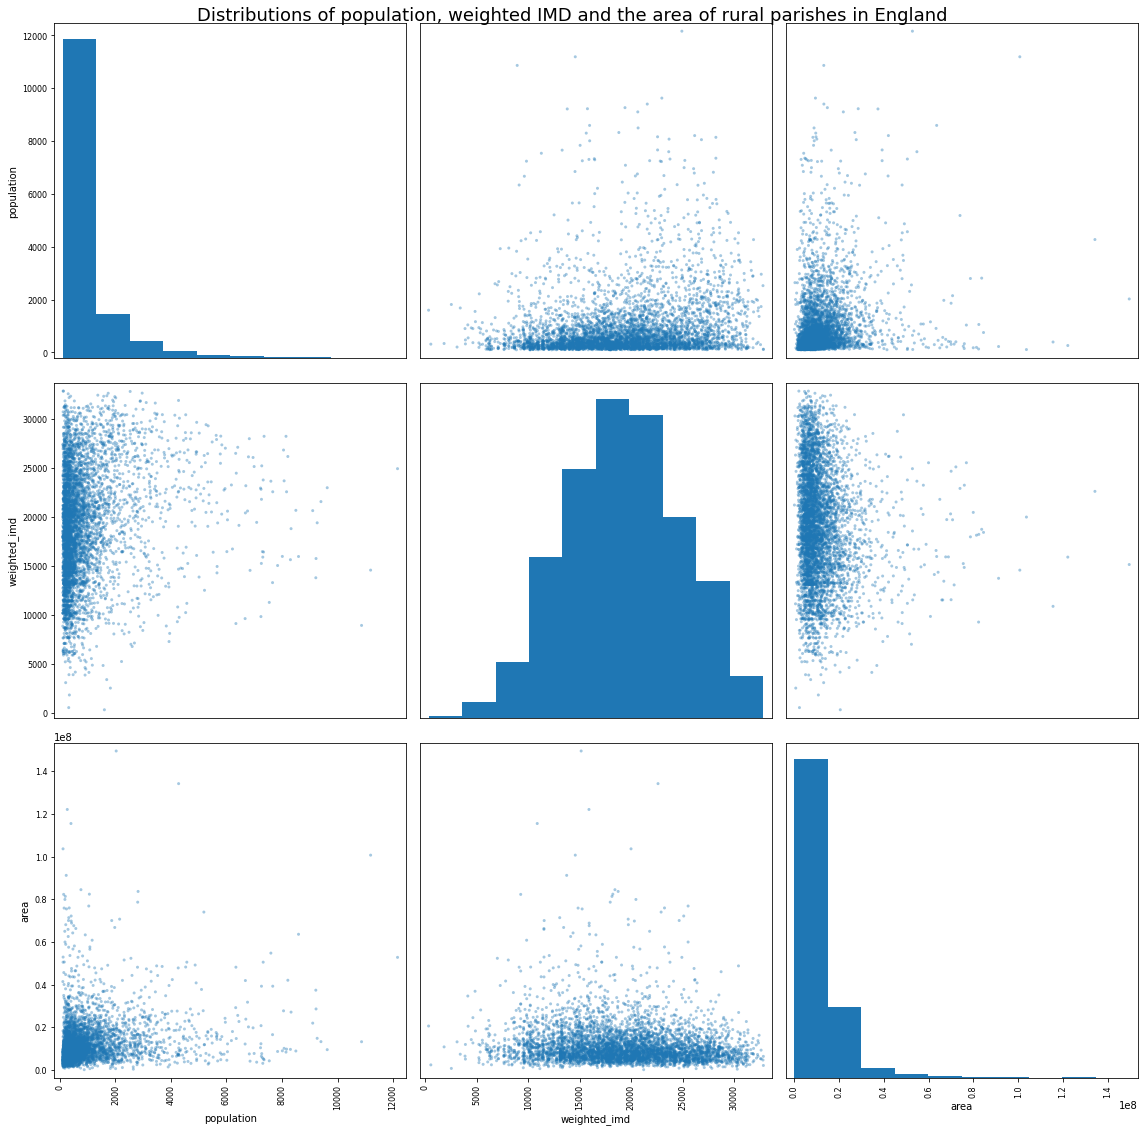

In [1184]:
fig, ax = plt.subplots(figsize=(16,16))
pd.plotting.scatter_matrix(
    predictor_frame[['population', 'weighted_imd', 'area']],
    alpha=0.4, ax=ax
)
plt.suptitle('Distributions of population, weighted IMD and the area of rural parishes in England', fontsize=18)
plt.tight_layout()
plt.savefig('results/distribution_of_values.png')
plt.show()

In [1150]:
predictor_frame.head()

pub  school  place_of_worship  weighted_imd          area  \
0    2       1                 2       30238.0  7.898754e+06   
1    2       1                 1       23934.0  6.695996e+06   
2    0       0                 1       30238.0  1.691419e+06   
3    1       1                 2       30238.0  3.710505e+06   
4    1       1                 2       23934.0  1.084977e+07   

                     region  population           name    ln_area  \
0  Yorkshire and The Humber        1203  Bradleys Both  15.882216   
1  Yorkshire and The Humber        1469       Cononley  15.717020   
2  Yorkshire and The Humber         481       Farnhill  14.341078   
3  Yorkshire and The Humber         222       Kildwick  15.126678   
4  Yorkshire and The Humber         509    Lothersdale  16.199655   

   ln_population  pub_bool  school_bool  worship_bool  pubs_per_person  \
0       7.092574         1            1             1         0.001663   
1       7.292337         1            1             1         0.001361   
2       6.175867         0            0             1         0.000000   
3       5.402677         1            1             1         0.004505   
4       6.232448         1            1             1         0.001965   

   schools_per_person  worship_per_person  
0            0.000831            0.001663  
1            0.000681            0.000681  
2            0.000000            0.002079  
3            0.004505            0.009009  
4            0.001965            0.003929

In [1156]:
wide_frame = pd.concat([predictor_frame,pd.get_dummies(predictor_frame.region)], axis=1)
wide_frame.head()

pub  school  place_of_worship  weighted_imd          area  \
0    2       1                 2       30238.0  7.898754e+06   
1    2       1                 1       23934.0  6.695996e+06   
2    0       0                 1       30238.0  1.691419e+06   
3    1       1                 2       30238.0  3.710505e+06   
4    1       1                 2       23934.0  1.084977e+07   

                     region  population           name    ln_area  \
0  Yorkshire and The Humber        1203  Bradleys Both  15.882216   
1  Yorkshire and The Humber        1469       Cononley  15.717020   
2  Yorkshire and The Humber         481       Farnhill  14.341078   
3  Yorkshire and The Humber         222       Kildwick  15.126678   
4  Yorkshire and The Humber         509    Lothersdale  16.199655   

   ln_population  ...  pubs_per_person  schools_per_person  \
0       7.092574  ...         0.001663            0.000831   
1       7.292337  ...         0.001361            0.000681   
2       6.175867  ...         0.000000            0.000000   
3       5.402677  ...         0.004505            0.004505   
4       6.232448  ...         0.001965            0.001965   

   worship_per_person  East Midlands  East of England  North West  South East  \
0            0.001663              0                0           0           0   
1            0.000681              0                0           0           0   
2            0.002079              0                0           0           0   
3            0.009009              0                0           0           0   
4            0.003929              0                0           0           0   

   South West  West Midlands  Yorkshire and The Humber  
0           0              0                         1  
1           0              0                         1  
2           0              0                         1  
3           0              0                         1  
4           0              0                         1  

[5 rows x 23 columns]

In [1157]:
wide_frame.groupby(['region']).size()

region
East Midlands                814
East of England             1273
North West                   366
South East                   818
South West                   798
West Midlands                418
Yorkshire and The Humber     577
dtype: int64

In [1158]:
log_reg = smf.logit(
    "pub_bool ~ weighted_imd + ln_population + ln_area + Q('East Midlands')  + Q('Yorkshire and The Humber') + Q('North West') + Q('South East') + Q('South West') + Q('West Midlands')"
    , data=wide_frame
).fit()

Optimization terminated successfully.
         Current function value: 0.496495
         Iterations 7


In [1159]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:               pub_bool   No. Observations:                 5064
Model:                          Logit   Df Residuals:                     5054
Method:                           MLE   Df Model:                            9
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                  0.2017
Time:                        15:37:42   Log-Likelihood:                -2514.3
converged:                       True   LL-Null:                       -3149.5
Covariance Type:            nonrobust   LLR p-value:                7.258e-268
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       -14.1146      0.989    -14.272      0.000     -16.053     -12.176
weighted_imd                   2.715e-05   6.71e-06      4.043      0.000 

## School model

In [1160]:
predictor_frame.head()

pub  school  place_of_worship  weighted_imd          area  \
0    2       1                 2       30238.0  7.898754e+06   
1    2       1                 1       23934.0  6.695996e+06   
2    0       0                 1       30238.0  1.691419e+06   
3    1       1                 2       30238.0  3.710505e+06   
4    1       1                 2       23934.0  1.084977e+07   

                     region  population           name    ln_area  \
0  Yorkshire and The Humber        1203  Bradleys Both  15.882216   
1  Yorkshire and The Humber        1469       Cononley  15.717020   
2  Yorkshire and The Humber         481       Farnhill  14.341078   
3  Yorkshire and The Humber         222       Kildwick  15.126678   
4  Yorkshire and The Humber         509    Lothersdale  16.199655   

   ln_population  pub_bool  school_bool  worship_bool  pubs_per_person  \
0       7.092574         1            1             1         0.001663   
1       7.292337         1            1             1         0.001361   
2       6.175867         0            0             1         0.000000   
3       5.402677         1            1             1         0.004505   
4       6.232448         1            1             1         0.001965   

   schools_per_person  worship_per_person  
0            0.000831            0.001663  
1            0.000681            0.000681  
2            0.000000            0.002079  
3            0.004505            0.009009  
4            0.001965            0.003929

In [1163]:
predictor_frame.loc[:, 'school_bool'] = predictor_frame.school > 0
predictor_frame.school_bool = predictor_frame.school_bool.astype(int)
school_1 = 'school_bool ~ ln_population + weighted_imd + ln_area'
school_fit_2 = smf.logit("school_bool ~ weighted_imd + ln_population + ln_area", data=predictor_frame).fit()
school_fit_2.summary()

Optimization terminated successfully.
         Current function value: 0.419463
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            school_bool   No. Observations:                 5064
Model:                          Logit   Df Residuals:                     5060
Method:                           MLE   Df Model:                            3
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                  0.3947
Time:                        15:37:55   Log-Likelihood:                -2124.2
converged:                       True   LL-Null:                       -3509.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -22.6832      1.122    -20.223      0.000     -24.882     -20.485
weighted_imd   3.099e-05   7.35e-06      4.216      0.000    1.66e-05    4.54e-05
ln_population     2.2499      0.066     33.868      0.000       2.120       2.380
ln_area           0.4995      0.066      7.606      0.000       0.371       0.628
=================================================================================
"""

In [1164]:

log_reg_school = smf.logit(
    "school_bool ~ weighted_imd + ln_population + ln_area + Q('East Midlands') + Q('Yorkshire and The Humber') + Q('North West') + Q('South East') + Q('South West') + Q('West Midlands')"
    , data=wide_frame
).fit()

Optimization terminated successfully.
         Current function value: 0.415077
         Iterations 7


In [1165]:
print(log_reg_school.summary())

                           Logit Regression Results                           
Dep. Variable:            school_bool   No. Observations:                 5064
Model:                          Logit   Df Residuals:                     5054
Method:                           MLE   Df Model:                            9
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                  0.4011
Time:                        15:38:00   Log-Likelihood:                -2102.0
converged:                       True   LL-Null:                       -3509.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       -21.9316      1.150    -19.076      0.000     -24.185     -19.678
weighted_imd                    2.86e-05   7.56e-06      3.783      0.000 

## Worship model

In [1166]:
worship_fit_2 = smf.logit("worship_bool ~ weighted_imd + ln_population + ln_area", data=predictor_frame).fit()
worship_fit_2.summary()

Optimization terminated successfully.
         Current function value: 0.206256
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           worship_bool   No. Observations:                 5064
Model:                          Logit   Df Residuals:                     5060
Method:                           MLE   Df Model:                            3
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.08502
Time:                        15:38:27   Log-Likelihood:                -1044.5
converged:                       True   LL-Null:                       -1141.5
Covariance Type:            nonrobust   LLR p-value:                 7.891e-42
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -13.8306      1.666     -8.301      0.000     -17.096     -10.565
weighted_imd  -1.957e-06   1.13e-05     -0.173      0.863   -2.41e-05    2.02e-05
ln_population     0.6896      0.086      8.060      0.000       0.522       0.857
ln_area           0.7869      0.107      7.339      0.000       0.577       0.997
=================================================================================
"""

In [1232]:
log_reg_worship = smf.logit(
    "worship_bool ~ weighted_imd + ln_population + ln_area + Q('East Midlands') + Q('Yorkshire and The Humber') + Q('North West') + Q('South East') + Q('South West') + Q('West Midlands')"
    , data=wide_frame
).fit()

Optimization terminated successfully.
         Current function value: 0.181469
         Iterations 8


In [1233]:
print(log_reg_worship.summary())

                           Logit Regression Results                           
Dep. Variable:           worship_bool   No. Observations:                 5064
Model:                          Logit   Df Residuals:                     5054
Method:                           MLE   Df Model:                            9
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                  0.1950
Time:                        20:50:22   Log-Likelihood:                -918.96
converged:                       True   LL-Null:                       -1141.5
Covariance Type:            nonrobust   LLR p-value:                 3.114e-90
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       -16.9114      1.723     -9.813      0.000     -20.289     -13.534
weighted_imd                   2.257e-05   1.16e-05      1.952      0.051 

### Plotting predictions

In [1235]:
a = [3]

3*a

[3, 3, 3]

In [1236]:
dummy_populations = np.arange(100,2000)
avg_area = np.mean(predictor_frame.area)
avg_imd = np.mean(predictor_frame.weighted_imd)
regions = predictor_frame.region.drop_duplicates()
handy_frame = pd.DataFrame(columns=['population', 'region', 'area', 'weighted_imd'])
frame_base = {
    'population': [],
    'weighted_imd': [],
    'region': [],
    'area': []
}
for region in regions:
    for pop in dummy_populations:
        frame_base['population'].append(pop)
        frame_base['weighted_imd'].append(avg_imd)
        frame_base['region'].append(region)
        frame_base['area'].append(avg_area)

to_pred_frame = pd.DataFrame(frame_base)
to_pred_frame.head()

population  weighted_imd                    region          area
0         100  19217.282754  Yorkshire and The Humber  1.173960e+07
1         101  19217.282754  Yorkshire and The Humber  1.173960e+07
2         102  19217.282754  Yorkshire and The Humber  1.173960e+07
3         103  19217.282754  Yorkshire and The Humber  1.173960e+07
4         104  19217.282754  Yorkshire and The Humber  1.173960e+07

In [1237]:
to_pred_frame.loc[:, 'ln_area'] = np.log(to_pred_frame.area)
to_pred_frame.loc[:, 'ln_population'] = np.log(to_pred_frame.population)
to_pred_frame.head()

population  weighted_imd                    region          area  \
0         100  19217.282754  Yorkshire and The Humber  1.173960e+07   
1         101  19217.282754  Yorkshire and The Humber  1.173960e+07   
2         102  19217.282754  Yorkshire and The Humber  1.173960e+07   
3         103  19217.282754  Yorkshire and The Humber  1.173960e+07   
4         104  19217.282754  Yorkshire and The Humber  1.173960e+07   

     ln_area  ln_population  
0  16.278478       4.605170  
1  16.278478       4.615121  
2  16.278478       4.624973  
3  16.278478       4.634729  
4  16.278478       4.644391

In [1238]:
wide_pred_frame = pd.concat([to_pred_frame,pd.get_dummies(to_pred_frame.region)], axis=1)

In [1239]:
wide_pred_frame.loc[:, 'prob_worship'] = log_reg_worship.predict(wide_pred_frame)
wide_pred_frame.loc[:, 'prob_school'] = log_reg_school.predict(wide_pred_frame)
wide_pred_frame.loc[:, 'prob_pub'] = log_reg.predict(wide_pred_frame)
wide_pred_frame.head()

population  weighted_imd                    region          area  \
0         100  19217.282754  Yorkshire and The Humber  1.173960e+07   
1         101  19217.282754  Yorkshire and The Humber  1.173960e+07   
2         102  19217.282754  Yorkshire and The Humber  1.173960e+07   
3         103  19217.282754  Yorkshire and The Humber  1.173960e+07   
4         104  19217.282754  Yorkshire and The Humber  1.173960e+07   

     ln_area  ln_population  East Midlands  East of England  North West  \
0  16.278478       4.605170              0                0           0   
1  16.278478       4.615121              0                0           0   
2  16.278478       4.624973              0                0           0   
3  16.278478       4.634729              0                0           0   
4  16.278478       4.644391              0                0           0   

   South East  South West  West Midlands  Yorkshire and The Humber  \
0           0           0              0                         1   
1           0           0              0                         1   
2           0           0              0                         1   
3           0           0              0                         1   
4           0           0              0                         1   

   prob_worship  prob_school  prob_pub  
0      0.774383     0.029716  0.313651  
1      0.775389     0.030393  0.316439  
2      0.776382     0.031079  0.319212  
3      0.777362     0.031772  0.321970  
4      0.778330     0.032474  0.324714

### Plotting

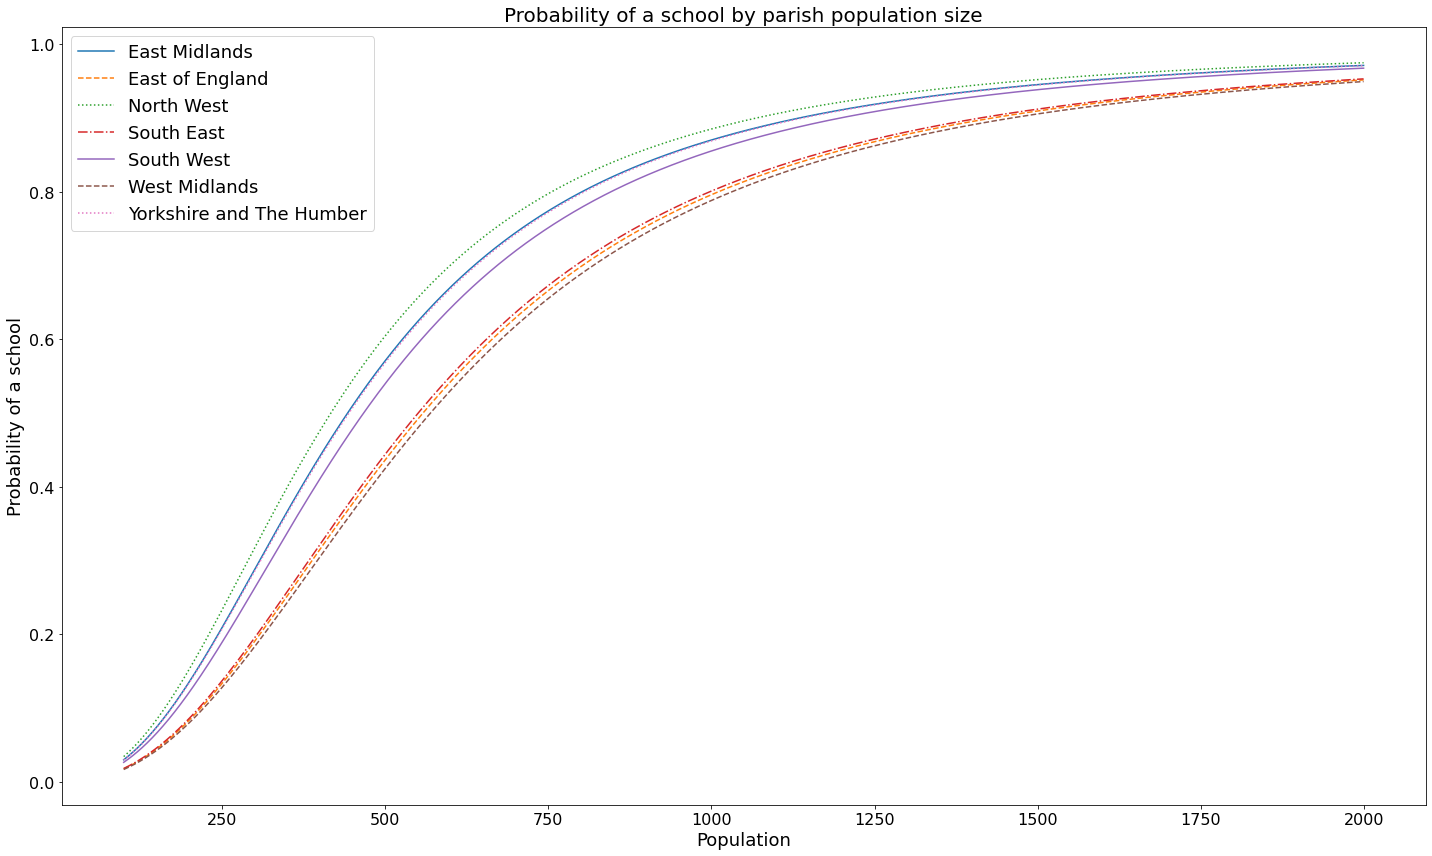

In [1240]:
fig, ax = plt.subplots(figsize=(20,12))
i = 0
ls = ['-', '--', ':', '-.']
for region, frame in wide_pred_frame.groupby(['region']):
    plt.plot(frame.population, frame.prob_school, label=region, ls=ls[i%len(ls)])
    i += 1

plt.legend(fontsize=18)
plt.xlabel('Population', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Probability of a school', fontsize=18)
plt.yticks(fontsize=16)
plt.title('Probability of a school by parish population size', fontsize=20)
plt.tight_layout()
plt.savefig('results/prob_school_by_region.png')
plt.show()

In [1241]:
wide_pred_frame[wide_pred_frame.prob_school >= 0.5].sort_values(by='prob_school', ascending=True).head(7).sort_values(by='population')

population  weighted_imd                    region          area  \
6018          418  19217.282754                North West  1.173960e+07   
7943          443  19217.282754             East Midlands  1.173960e+07   
345           445  19217.282754  Yorkshire and The Humber  1.173960e+07   
9868          468  19217.282754                South West  1.173960e+07   
4251          551  19217.282754                South East  1.173960e+07   
11859         559  19217.282754           East of England  1.173960e+07   
2370          570  19217.282754             West Midlands  1.173960e+07   

         ln_area  ln_population  East Midlands  East of England  North West  \
6018   16.278478       6.035481              0                0           1   
7943   16.278478       6.093570              1                0           0   
345    16.278478       6.098074              0                0           0   
9868   16.278478       6.148468              0                0           0   
4251   16.278478       6.311735              0                0           0   
11859  16.278478       6.326149              0                1           0   
2370   16.278478       6.345636              0                0           0   

       South East  South West  West Midlands  Yorkshire and The Humber  \
6018            0           0              0                         0   
7943            0           0              0                         0   
345             0           0              0                         1   
9868            0           1              0                         0   
4251            1           0              0                         0   
11859           0           0              0                         0   
2370            0           0              1                         0   

       prob_worship  prob_school  prob_pub  
6018       0.840412     0.501023  0.651288  
7943       0.959851     0.500144  0.702477  
345        0.890776     0.500114  0.760405  
9868       0.991395     0.500724  0.717952  
4251       0.982797     0.500012  0.850354  
11859      0.989826     0.500688  0.720570  
2370       0.973482     0.500211  0.789720

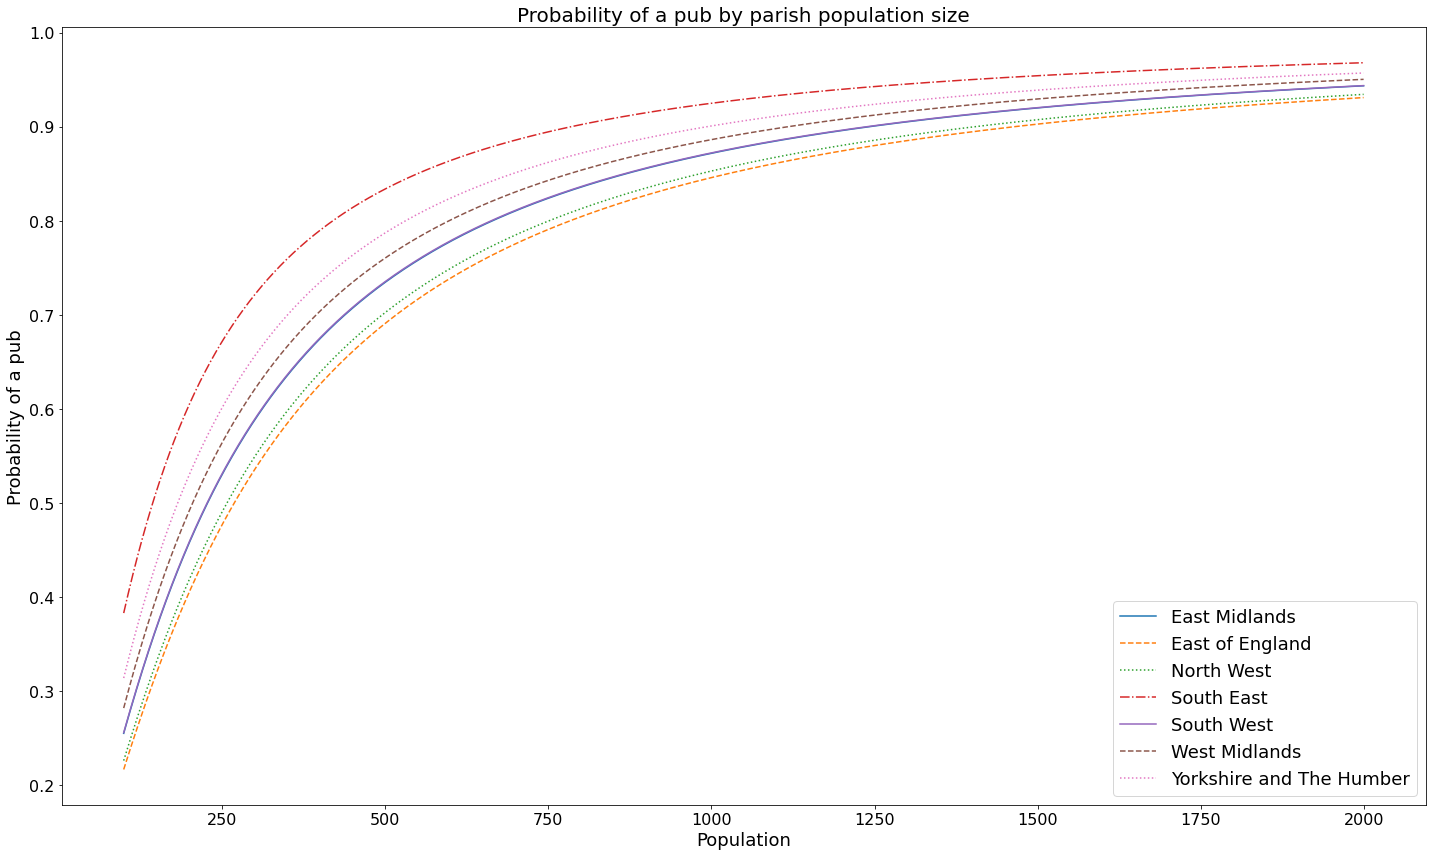

In [1242]:
fig, ax = plt.subplots(figsize=(20,12))
i = 0
ls = ['-', '--', ':', '-.']
for region, frame in wide_pred_frame.groupby(['region']):
    plt.plot(frame.population, frame.prob_pub, label=region, ls=ls[i%len(ls)])
    i += 1

plt.legend(fontsize=18)
plt.xlabel('Population', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Probability of a pub', fontsize=18)
plt.yticks(fontsize=16)
plt.title('Probability of a pub by parish population size', fontsize=20)
plt.tight_layout()
plt.savefig('results/prob_pub_by_region.png')
plt.show()

In [1243]:
wide_pred_frame[wide_pred_frame.prob_pub >= 0.5].sort_values(by='prob_pub', ascending=True).head(7).sort_values(by='population')

population  weighted_imd                    region          area  \
3845          145  19217.282754                South East  1.173960e+07   
83            183  19217.282754  Yorkshire and The Humber  1.173960e+07   
2006          206  19217.282754             West Midlands  1.173960e+07   
9628          228  19217.282754                South West  1.173960e+07   
7729          229  19217.282754             East Midlands  1.173960e+07   
5859          259  19217.282754                North West  1.173960e+07   
11570         270  19217.282754           East of England  1.173960e+07   

         ln_area  ln_population  East Midlands  East of England  North West  \
3845   16.278478       4.976734              0                0           0   
83     16.278478       5.209486              0                0           0   
2006   16.278478       5.327876              0                0           0   
9628   16.278478       5.429346              0                0           0   
7729   16.278478       5.433722              1                0           0   
5859   16.278478       5.556828              0                0           1   
11570  16.278478       5.598422              0                1           0   

       South East  South West  West Midlands  Yorkshire and The Humber  \
3845            1           0              0                         0   
83              0           0              0                         1   
2006            0           0              1                         0   
9628            0           1              0                         0   
7729            0           0              0                         0   
5859            0           0              0                         0   
11570           0           0              0                         0   

       prob_worship  prob_school  prob_pub  
3845       0.963433     0.042388  0.501089  
83         0.829708     0.111585  0.500346  
2006       0.953159     0.085027  0.500510  
9628       0.987001     0.157564  0.500200  
7729       0.942223     0.176483  0.500636  
5859       0.799603     0.247181  0.500836  
11570      0.984568     0.154896  0.500649

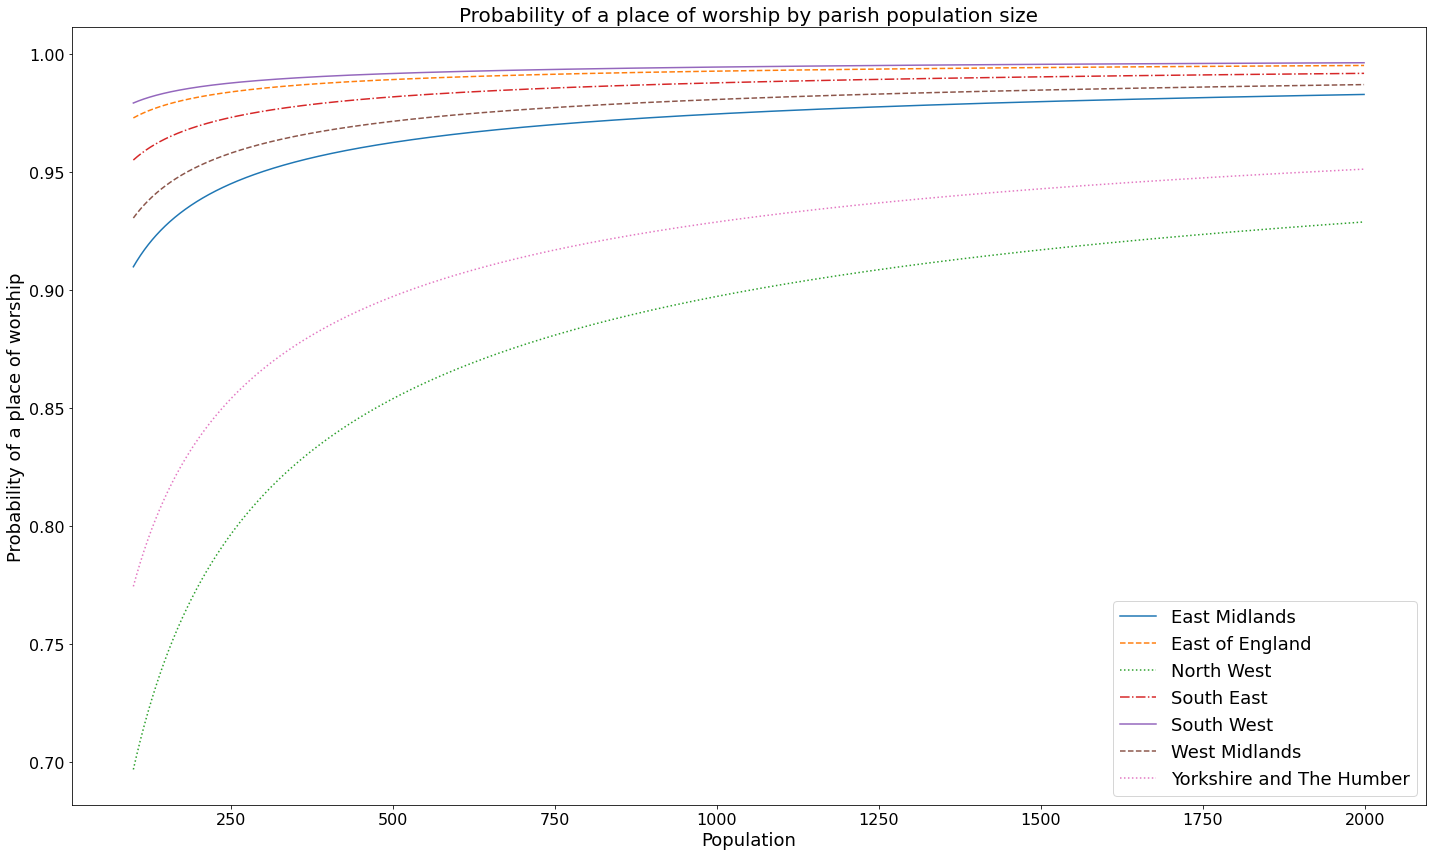

In [1244]:
fig, ax = plt.subplots(figsize=(20,12))
i = 0
ls = ['-', '--', ':', '-.']
for region, frame in wide_pred_frame.groupby(['region']):
    plt.plot(frame.population, frame.prob_worship, label=region, ls=ls[i%len(ls)])
    i += 1

plt.legend(fontsize=18)
plt.xlabel('Population', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Probability of a place of worship', fontsize=18)
plt.yticks(fontsize=16)
plt.title('Probability of a place of worship by parish population size', fontsize=20)
plt.tight_layout()
plt.savefig('results/prob_worship_by_region.png')
plt.show()

### By region

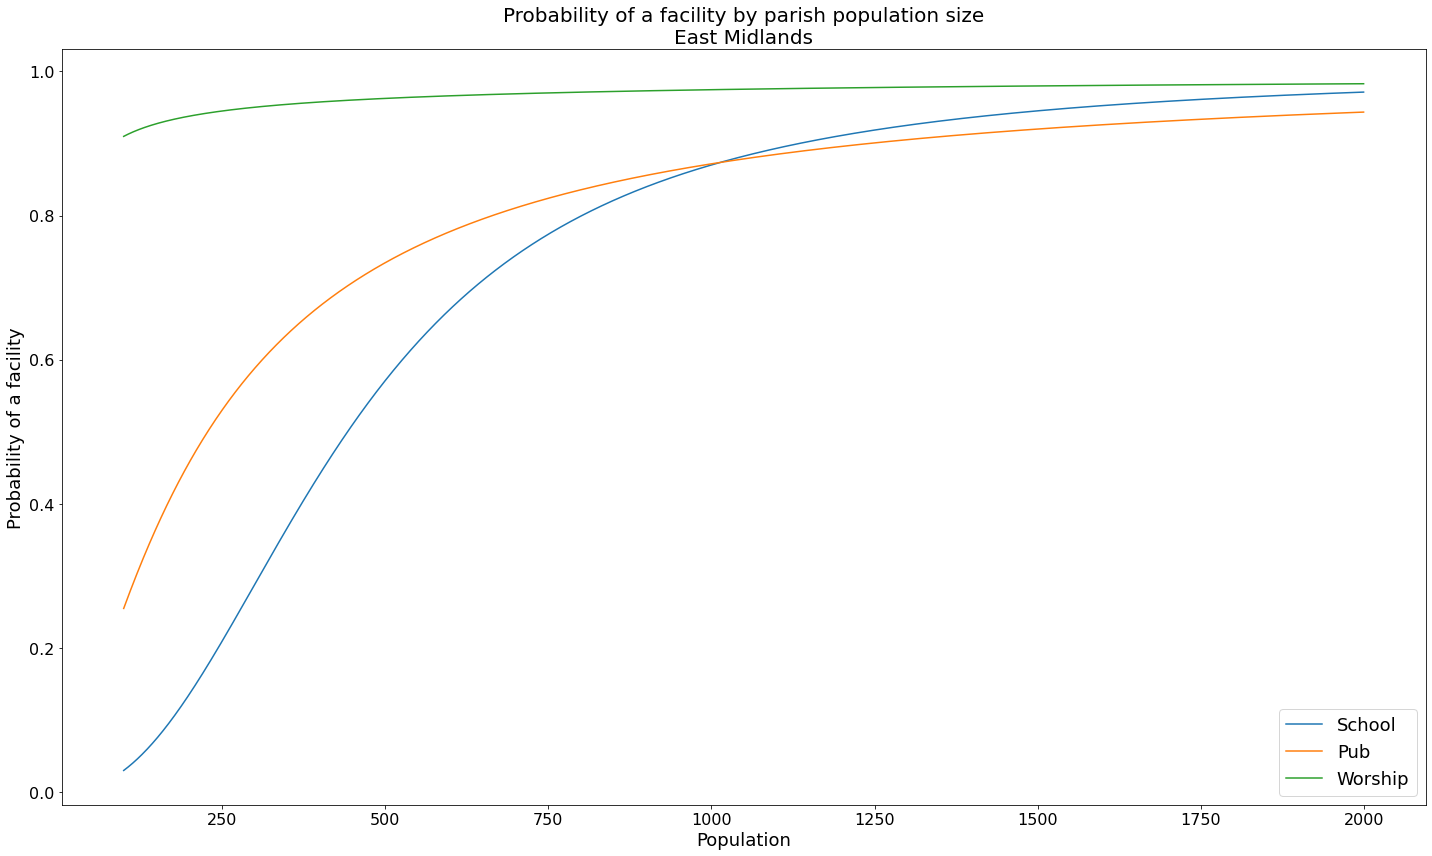

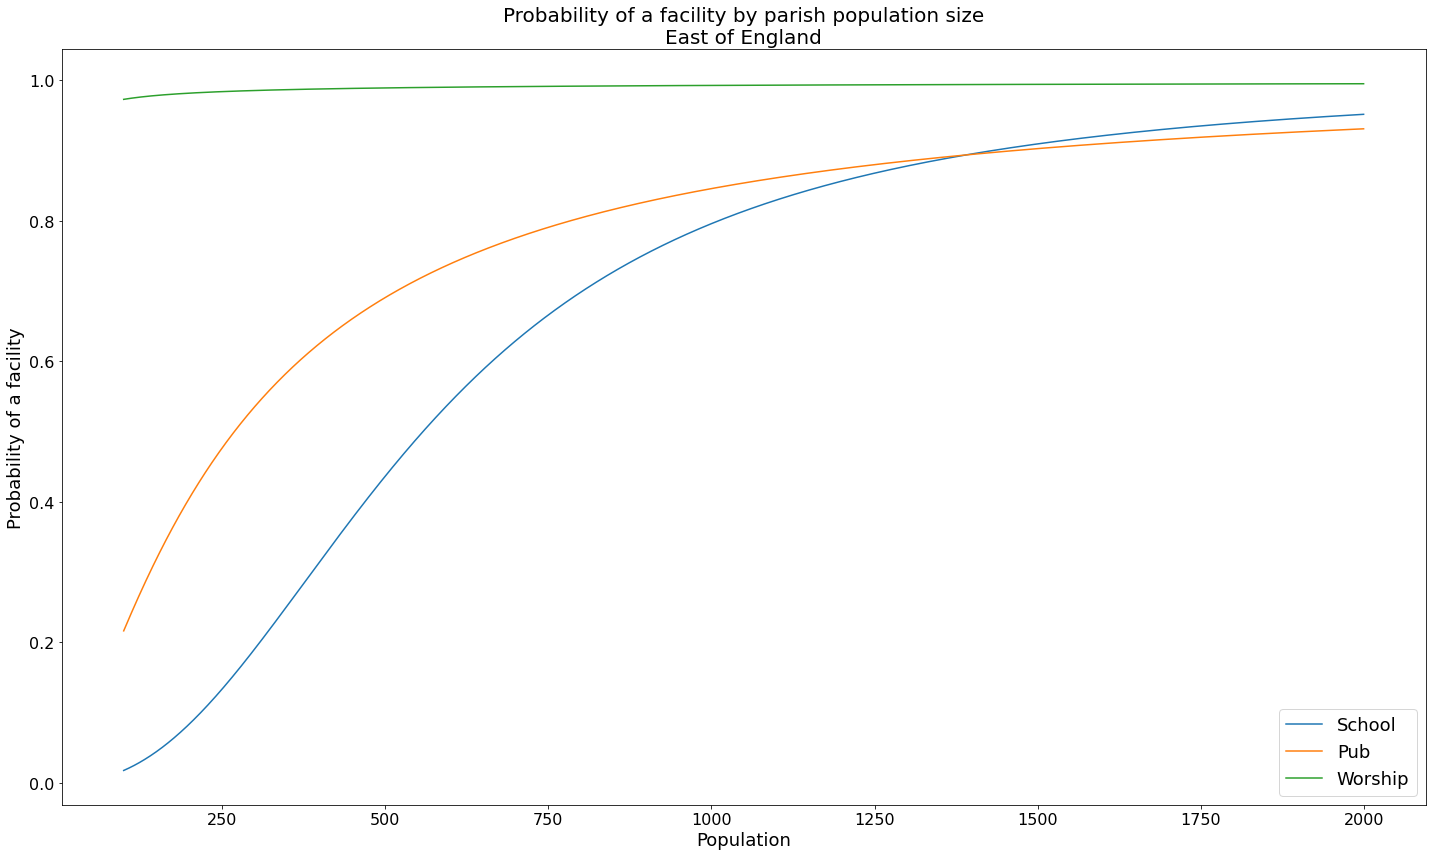

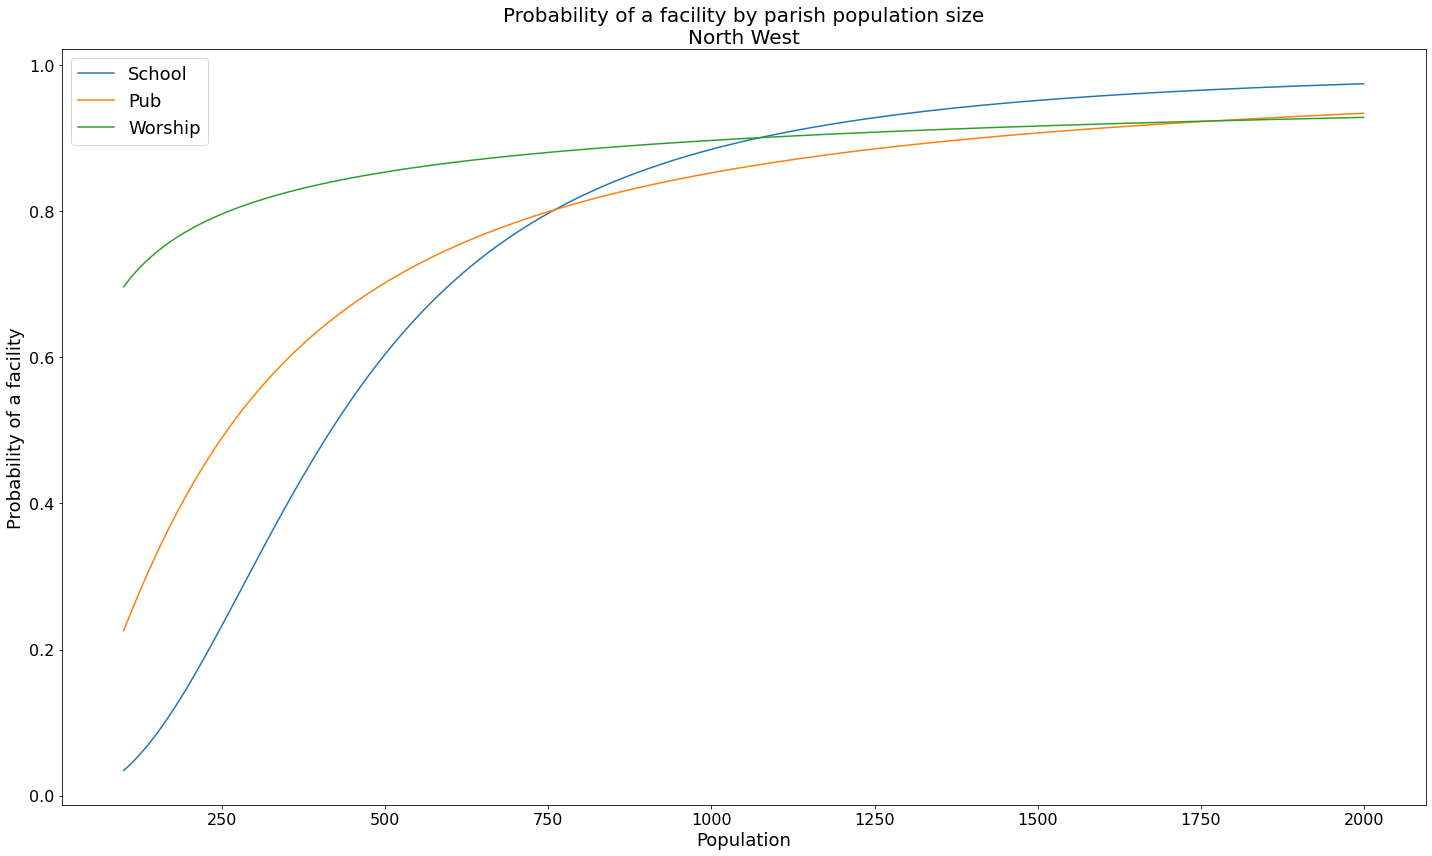

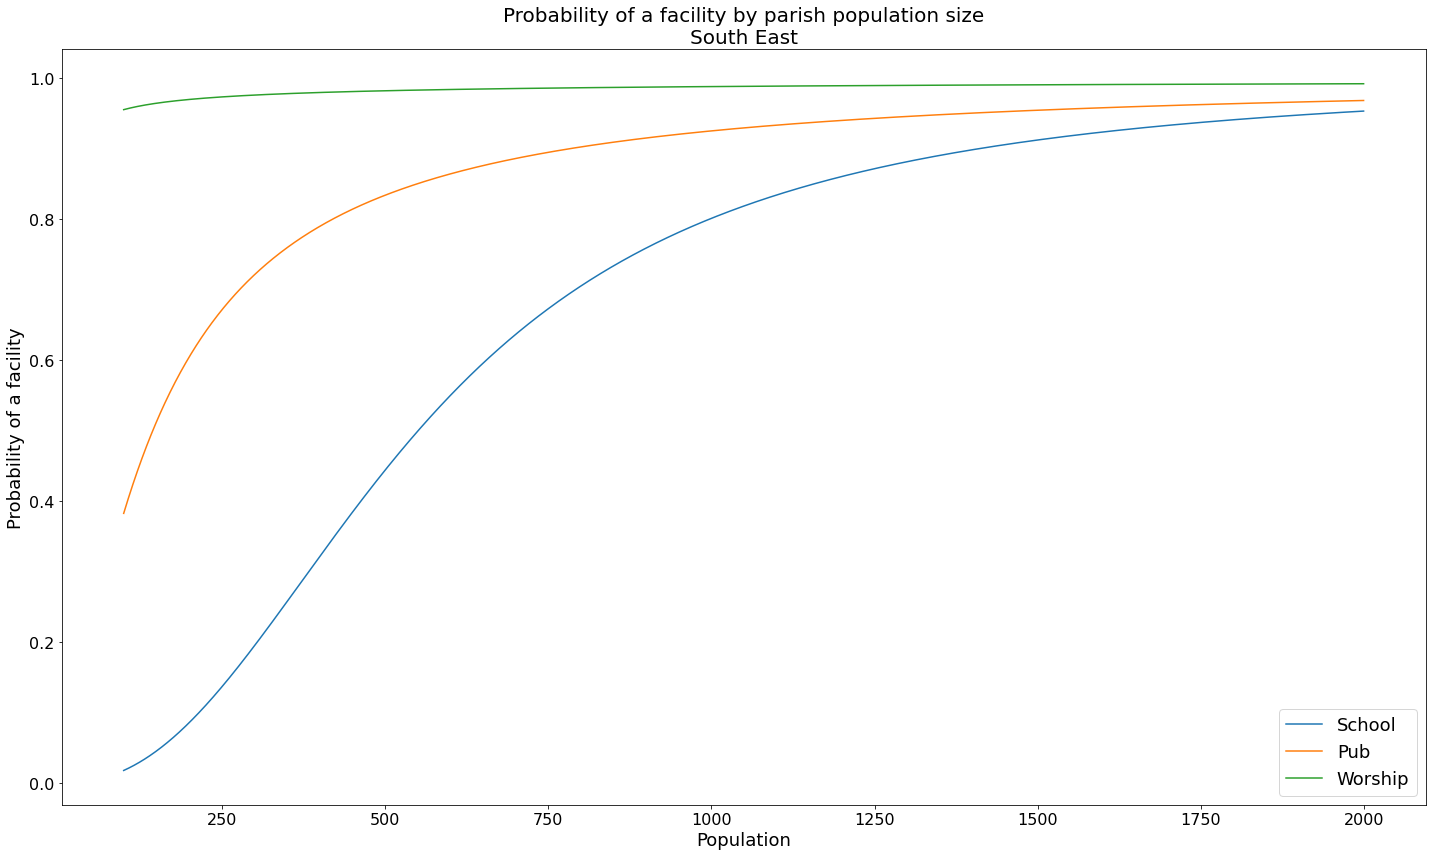

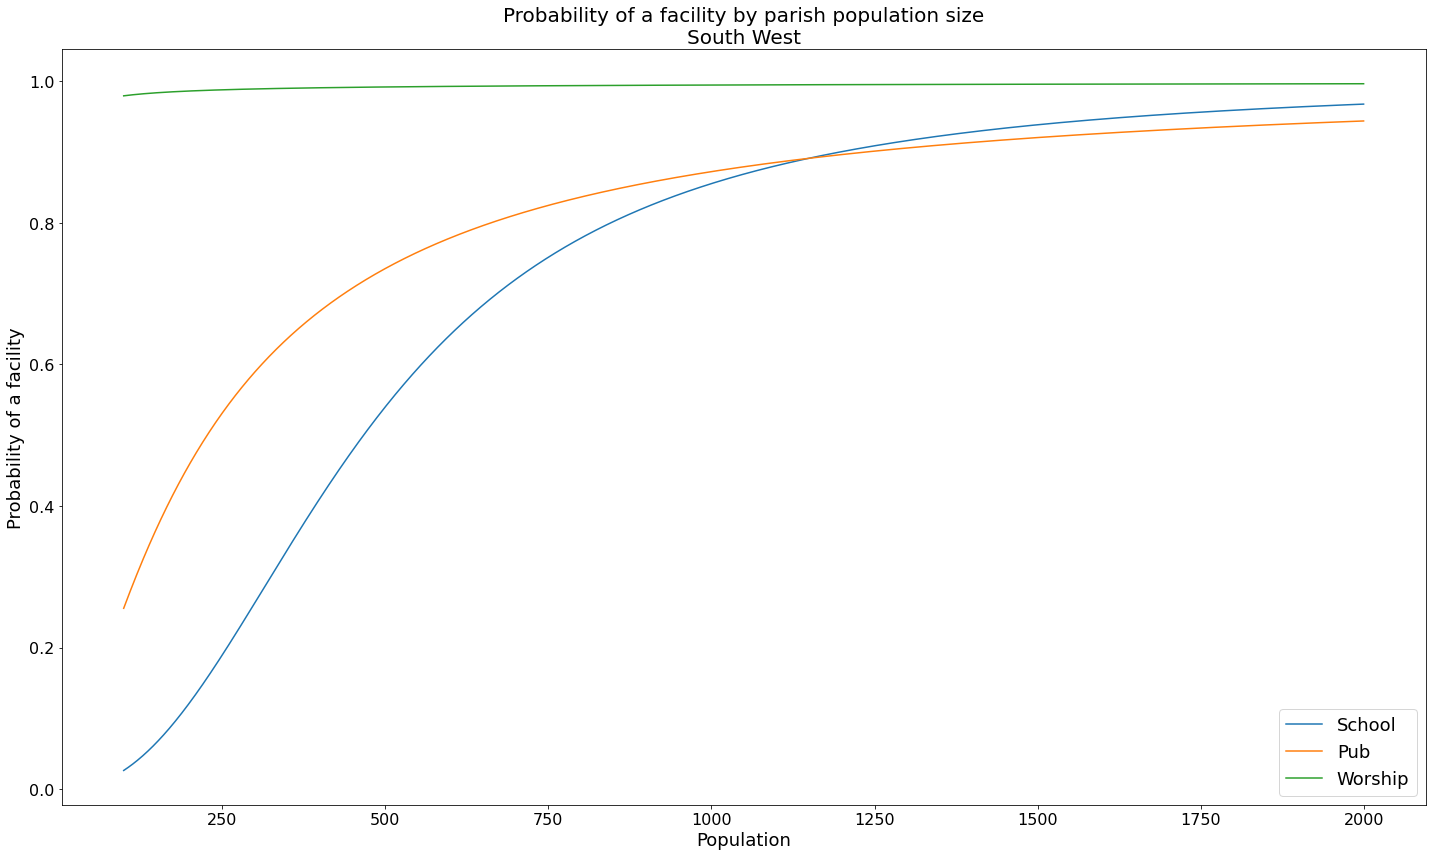

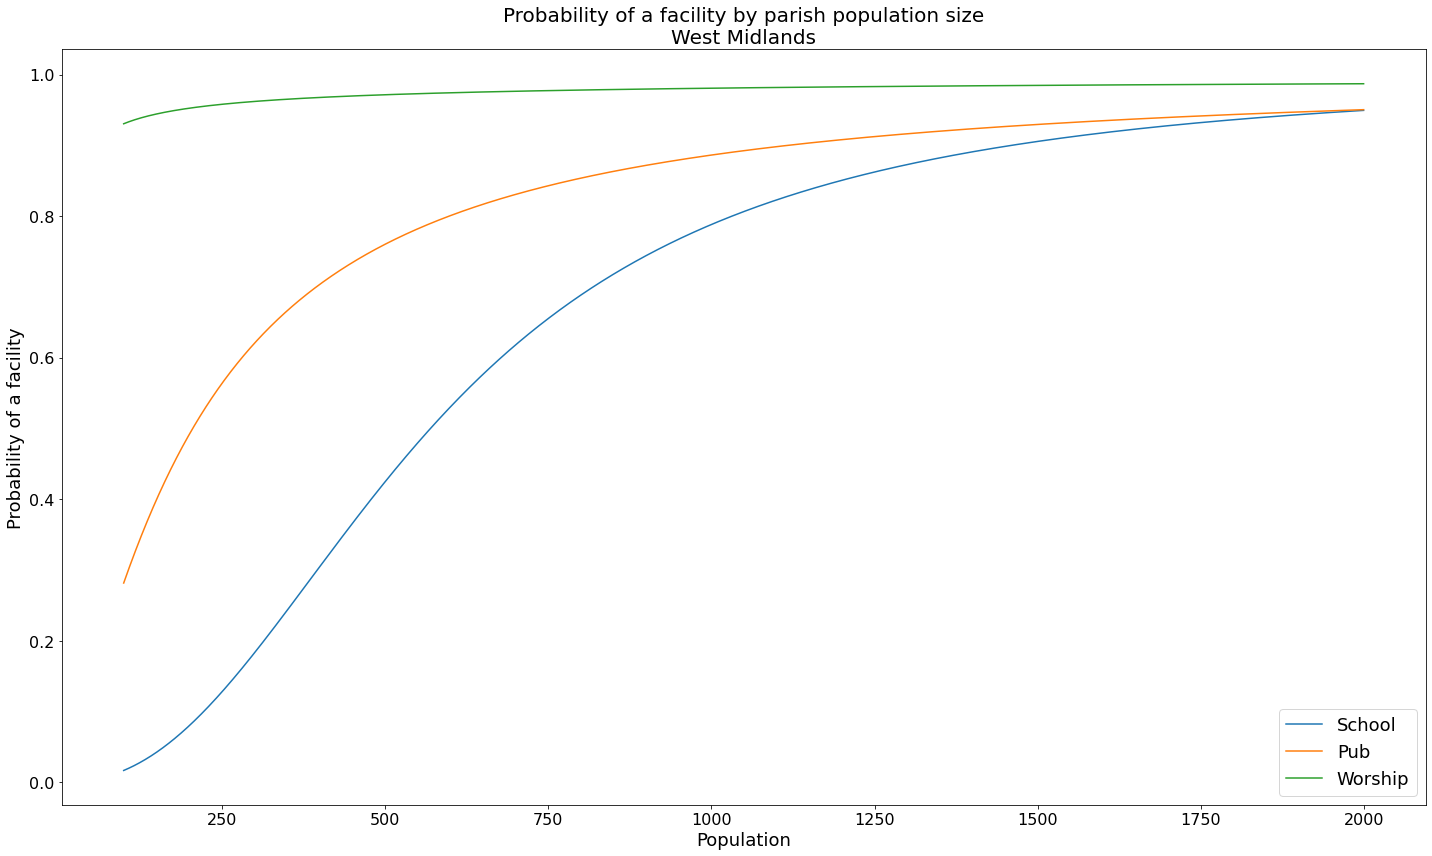

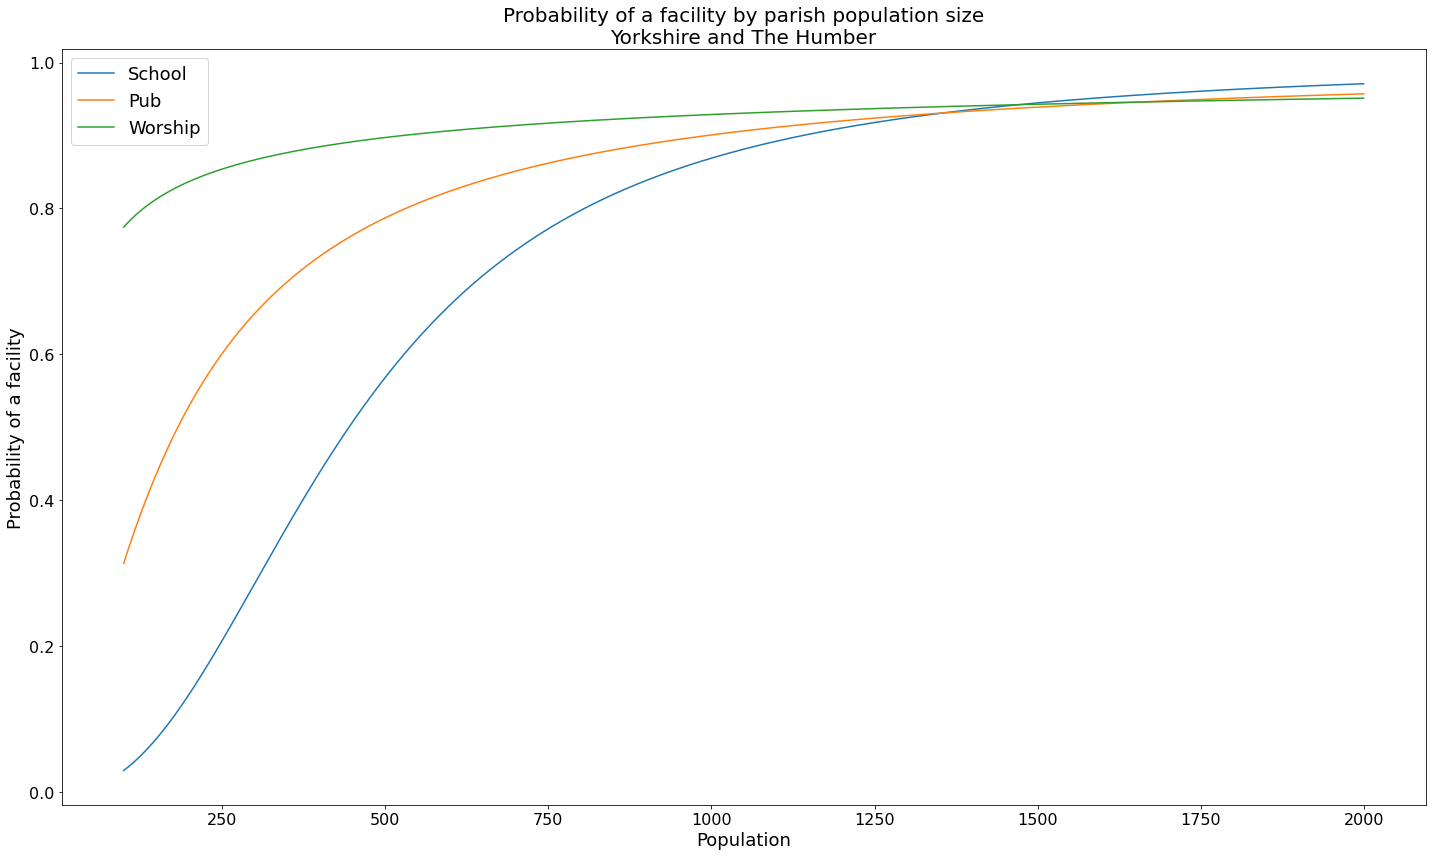

In [1245]:
i = 0
ls = ['-', '--', ':', '-.']
for region, frame in wide_pred_frame.groupby(['region']):
    fig, ax = plt.subplots(figsize=(20,12))    
    plt.plot(frame.population, frame.prob_school, label='School')
    plt.plot(frame.population, frame.prob_pub, label='Pub')
    plt.plot(frame.population, frame.prob_worship, label='Worship')
    plt.legend(fontsize=18)
    plt.xlabel('Population', fontsize=18)
    plt.xticks(fontsize=16)
    plt.ylabel('Probability of a facility', fontsize=18)
    plt.yticks(fontsize=16)
    plt.title('Probability of a facility by parish population size\n{0}'.format(region), fontsize=20)
    plt.tight_layout()
    plt.savefig('results/prob_everything_{0}.png'.format(region))
    plt.show()



### By IMD

In [903]:
np.max(predictor_frame.weighted_imd)

32828.0

In [904]:
avg_populations = np.mean(predictor_frame.population)
avg_area = np.mean(predictor_frame.area)
dummy_imds = np.arange(np.min(predictor_frame.weighted_imd), np.max(predictor_frame.weighted_imd))
regions = predictor_frame.region.drop_duplicates()
handy_frame = pd.DataFrame(columns=['population', 'region', 'area', 'weighted_imd'])
frame_base = {
    'population': [],
    'weighted_imd': [],
    'region': [],
    'area': []
}
for region in regions:
    for imd in dummy_imds:
        frame_base['population'].append(avg_populations)
        frame_base['weighted_imd'].append(imd)
        frame_base['region'].append(region)
        frame_base['area'].append(avg_area)

to_pred_frame = pd.DataFrame(frame_base)
to_pred_frame.head()

population  weighted_imd                    region          area
0  903.198855         322.0  Yorkshire and The Humber  1.173960e+07
1  903.198855         323.0  Yorkshire and The Humber  1.173960e+07
2  903.198855         324.0  Yorkshire and The Humber  1.173960e+07
3  903.198855         325.0  Yorkshire and The Humber  1.173960e+07
4  903.198855         326.0  Yorkshire and The Humber  1.173960e+07

In [905]:
to_pred_frame.loc[:, 'ln_area'] = np.log(to_pred_frame.area)
to_pred_frame.loc[:, 'ln_population'] = np.log(to_pred_frame.population)
to_pred_frame.head()

population  weighted_imd                    region          area  \
0  903.198855         322.0  Yorkshire and The Humber  1.173960e+07   
1  903.198855         323.0  Yorkshire and The Humber  1.173960e+07   
2  903.198855         324.0  Yorkshire and The Humber  1.173960e+07   
3  903.198855         325.0  Yorkshire and The Humber  1.173960e+07   
4  903.198855         326.0  Yorkshire and The Humber  1.173960e+07   

     ln_area  ln_population  
0  16.278478       6.805943  
1  16.278478       6.805943  
2  16.278478       6.805943  
3  16.278478       6.805943  
4  16.278478       6.805943

In [906]:
wide_pred_frame = pd.concat([to_pred_frame,pd.get_dummies(to_pred_frame.region)], axis=1)
wide_pred_frame.loc[:, 'prob_worship'] = log_reg_worship.predict(wide_pred_frame)
wide_pred_frame.loc[:, 'prob_school'] = log_reg_school.predict(wide_pred_frame)
wide_pred_frame.loc[:, 'prob_pub'] = log_reg.predict(wide_pred_frame)
wide_pred_frame.head()

population  weighted_imd                    region          area  \
0  903.198855         322.0  Yorkshire and The Humber  1.173960e+07   
1  903.198855         323.0  Yorkshire and The Humber  1.173960e+07   
2  903.198855         324.0  Yorkshire and The Humber  1.173960e+07   
3  903.198855         325.0  Yorkshire and The Humber  1.173960e+07   
4  903.198855         326.0  Yorkshire and The Humber  1.173960e+07   

     ln_area  ln_population  East Midlands  East of England  North West  \
0  16.278478       6.805943              0                0           0   
1  16.278478       6.805943              0                0           0   
2  16.278478       6.805943              0                0           0   
3  16.278478       6.805943              0                0           0   
4  16.278478       6.805943              0                0           0   

   South East  South West  West Midlands  Yorkshire and The Humber  \
0           0           0              0                         1   
1           0           0              0                         1   
2           0           0              0                         1   
3           0           0              0                         1   
4           0           0              0                         1   

   prob_worship  prob_school  prob_pub  
0      0.889208     0.752721  0.826479  
1      0.889211     0.752727  0.826483  
2      0.889213     0.752732  0.826487  
3      0.889215     0.752737  0.826491  
4      0.889217     0.752742  0.826495

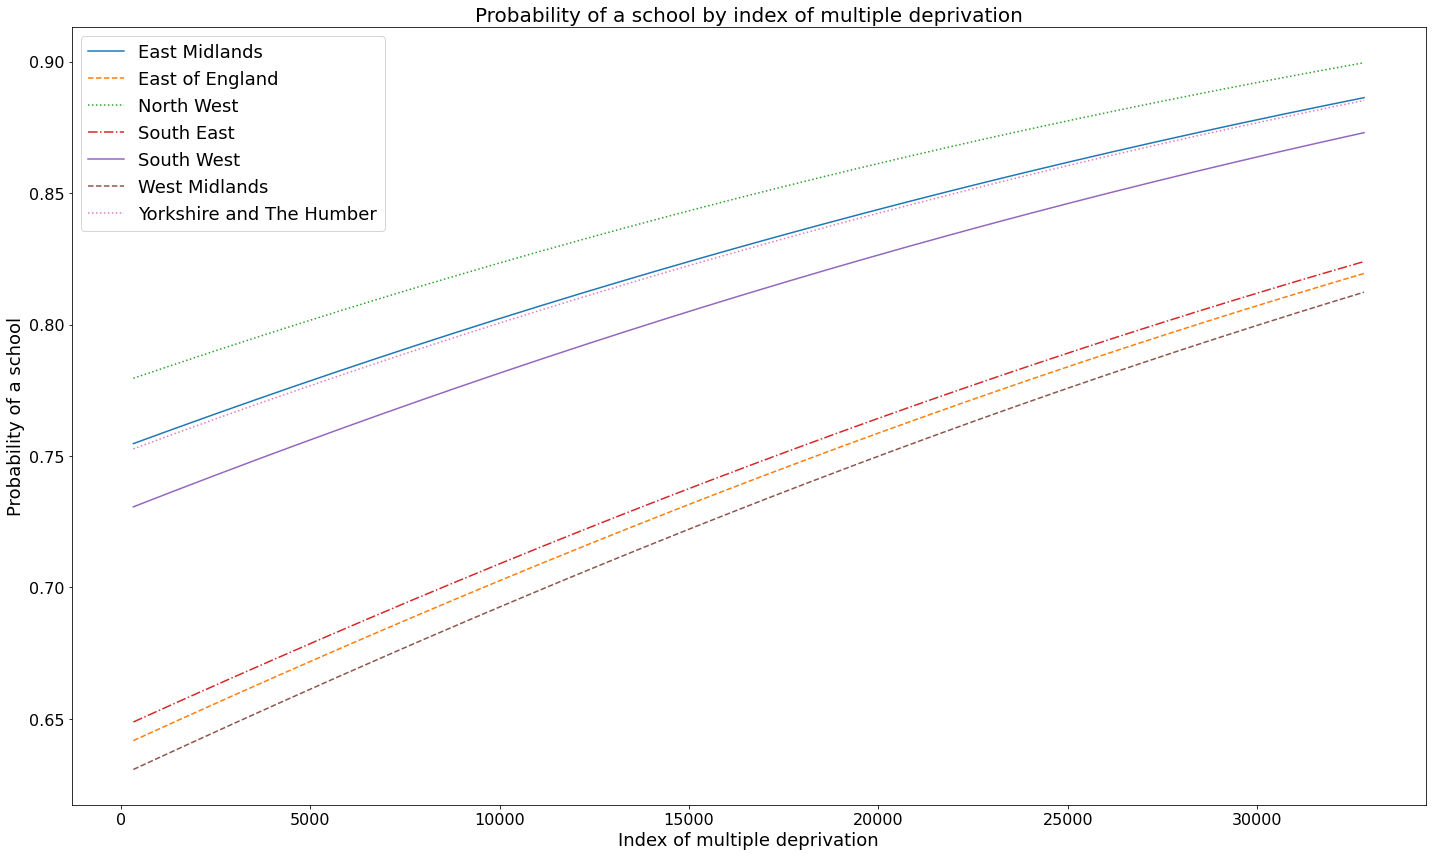

In [907]:
fig, ax = plt.subplots(figsize=(20,12))
i = 0
ls = ['-', '--', ':', '-.']
for region, frame in wide_pred_frame.groupby(['region']):
    plt.plot(frame.weighted_imd, frame.prob_school, label=region, ls=ls[i%len(ls)])
    i += 1

plt.legend(fontsize=18)
plt.xlabel('Index of multiple deprivation', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('Probability of a school', fontsize=18)
plt.yticks(fontsize=16)
plt.title('Probability of a school by index of multiple deprivation', fontsize=20)
plt.tight_layout()
plt.savefig('results/prob_school_by_region_by_imd.png')
plt.show()

### Most surprising omissions

In [908]:
wide_frame.head()

pub  school  place_of_worship  weighted_imd          area  \
0    2       1                 2       30238.0  7.898754e+06   
1    2       1                 1       23934.0  6.695996e+06   
2    0       0                 1       30238.0  1.691419e+06   
3    1       1                 2       30238.0  3.710505e+06   
4    1       1                 2       23934.0  1.084977e+07   

                     region  population           name    ln_area  \
0  Yorkshire and The Humber        1203  Bradleys Both  15.882216   
1  Yorkshire and The Humber        1469       Cononley  15.717020   
2  Yorkshire and The Humber         481       Farnhill  14.341078   
3  Yorkshire and The Humber         222       Kildwick  15.126678   
4  Yorkshire and The Humber         509    Lothersdale  16.199655   

   ln_population  pub_bool  school_bool  worship_bool  East Midlands  \
0       7.092574         1            1             1              0   
1       7.292337         1            1             1              0   
2       6.175867         0            0             1              0   
3       5.402677         1            1             1              0   
4       6.232448         1            1             1              0   

   East of England  North West  South East  South West  West Midlands  \
0                0           0           0           0              0   
1                0           0           0           0              0   
2                0           0           0           0              0   
3                0           0           0           0              0   
4                0           0           0           0              0   

   Yorkshire and The Humber  
0                         1  
1                         1  
2                         1  
3                         1  
4                         1

In [1249]:
wide_frame.loc[:, 'prob_worship'] = log_reg_worship.predict(wide_frame)
wide_frame.loc[:, 'prob_school'] = log_reg_school.predict(wide_frame)
wide_frame.loc[:, 'prob_pub'] = log_reg.predict(wide_frame)
wide_frame.head()

pub  school  place_of_worship  weighted_imd          area  \
0    2       1                 2       30238.0  7.898754e+06   
1    2       1                 1       23934.0  6.695996e+06   
2    0       0                 1       30238.0  1.691419e+06   
3    1       1                 2       30238.0  3.710505e+06   
4    1       1                 2       23934.0  1.084977e+07   

                     region  population           name    ln_area  \
0  Yorkshire and The Humber        1203  Bradleys Both  15.882216   
1  Yorkshire and The Humber        1469       Cononley  15.717020   
2  Yorkshire and The Humber         481       Farnhill  14.341078   
3  Yorkshire and The Humber         222       Kildwick  15.126678   
4  Yorkshire and The Humber         509    Lothersdale  16.199655   

   ln_population  ...  East Midlands  East of England  North West  South East  \
0       7.092574  ...              0                0           0           0   
1       7.292337  ...              0                0           0           0   
2       6.175867  ...              0                0           0           0   
3       5.402677  ...              0                0           0           0   
4       6.232448  ...              0                0           0           0   

   South West  West Midlands  Yorkshire and The Humber  prob_worship  \
0           0              0                         1      0.924187   
1           0              0                         1      0.908689   
2           0              0                         1      0.580060   
3           0              0                         1      0.671270   
4           0              0                         1      0.900144   

   prob_school  prob_pub  
0     0.922522  0.930282  
1     0.936805  0.931821  
2     0.428107  0.690388  
3     0.144781  0.525879  
4     0.602796  0.806392  

[5 rows x 26 columns]

In [910]:
wide_frame.loc[:, 'pub_surprise'] = wide_frame.pub_bool - wide_frame.prob_pub
wide_frame.loc[:, 'school_surprise'] = wide_frame.school_bool - wide_frame.prob_school
wide_frame.loc[:, 'worship_surprise'] = wide_frame.worship_bool - wide_frame.prob_worship

In [911]:
wide_frame.sort_values(by='pub_surprise').head()

pub  school  place_of_worship  weighted_imd          area  \
3081    0       4                 5  21442.342124  1.598800e+07   
4645    0       1                 5  28000.460996  1.464049e+07   
2215    0       1                 2  32621.000000  5.248724e+06   
782     0       2                 1  23835.432871  1.866658e+07   
3752    0       1                 1  19494.987999  4.672770e+06   

               region  population                     name    ln_area  \
3081    East Midlands        5650               Ruskington  16.587349   
4645  East of England        4538                Knebworth  16.499302   
2215       South East        2962            South Wonston  15.473496   
782        North West        4186  Hesketh-with-Becconsall  16.742245   
3752       South East        3333                 Tangmere  15.357263   

      ln_population  ...  South East  South West  West Midlands  \
3081       8.639411  ...           0           0              0   
4645       8.420242  ...           0           0              0   
2215       7.993620  ...           1           0              0   
782        8.339501  ...           0           0              0   
3752       8.111628  ...           1           0              0   

      Yorkshire and The Humber  prob_worship  prob_school  prob_pub  \
3081                         0      0.993505     0.997839  0.987188   
4645                         0      0.998026     0.994696  0.981836   
2215                         0      0.988603     0.981731  0.981506   
782                          0      0.973314     0.996682  0.980570   
3752                         0      0.983873     0.978899  0.976416   

      pub_surprise  school_surprise  worship_surprise  
3081     -0.987188         0.002161          0.006495  
4645     -0.981836         0.005304          0.001974  
2215     -0.981506         0.018269          0.011397  
782      -0.980570         0.003318          0.026686  
3752     -0.976416         0.021101          0.016127  

[5 rows x 26 columns]

In [912]:
wide_frame.sort_values(by='pub_surprise', ascending=False).head()

pub  school  place_of_worship  weighted_imd          area  \
1240    1       0                 1       10163.0  3.202055e+06   
4162    1       0                 1       17869.0  1.951660e+06   
1879    1       0                 1       13559.0  4.251930e+06   
1162    1       0                 1       16731.0  1.163563e+06   
2040    1       0                 1       12525.0  4.383810e+06   

               region  population                   name    ln_area  \
1240       South West         102             Monksilver  14.979303   
4162       South West         105            Butterleigh  14.484191   
1879  East of England         108                Wiveton  15.262884   
1162       South West         126  Seavington St Michael  13.966997   
2040  East of England         125              Wheatacre  15.293429   

      ln_population  ...  South East  South West  West Midlands  \
1240       4.624973  ...           0           1              0   
4162       4.653960  ...           0           1              0   
1879       4.682131  ...           0           0              0   
1162       4.836282  ...           0           1              0   
2040       4.828314  ...           0           0              0   

      Yorkshire and The Humber  prob_worship  prob_school  prob_pub  \
1240                         0      0.906487     0.012850  0.142557   
4162                         0      0.873615     0.014001  0.149331   
1879                         0      0.917743     0.012000  0.149914   
1162                         0      0.811667     0.016769  0.149934   
2040                         0      0.924569     0.016519  0.173402   

      pub_surprise  school_surprise  worship_surprise  
1240      0.857443        -0.012850          0.093513  
4162      0.850669        -0.014001          0.126385  
1879      0.850086        -0.012000          0.082257  
1162      0.850066        -0.016769          0.188333  
2040      0.826598        -0.016519          0.075431  

[5 rows x 26 columns]

In [913]:
wide_frame.sort_values(by='school_surprise').head()

pub  school  place_of_worship  weighted_imd          area      region  \
634     1       0                 1  31872.149579  7.403694e+06  South East   
2290    3       0                 4  14734.885277  1.825062e+07  South East   
691     1       0                 0  10305.000000  7.534208e+06  North West   
3382    3       0                 2   8795.581781  1.397643e+07  South East   
2174    1       0                 1  24711.000000  1.891132e+07  South East   

      population                   name    ln_area  ln_population  ...  \
634         4272           East Horsley  15.817490       8.359837  ...   
2290        3199               Pevensey  16.719710       8.070594  ...   
691         2544           Ulnes Walton  15.834964       7.841493  ...   
3382        2898  St. Mary in the Marsh  16.452883       7.971776  ...   
2174        2066            Over Wallop  16.755271       7.633370  ...   

      South East  South West  West Midlands  Yorkshire and The Humber  \
634            1           0              0                         0   
2290           1           0              0                         0   
691            0           0              0                         0   
3382           1           0              0                         0   
2174           1           0              0                         0   

      prob_worship  prob_school  prob_pub  pub_surprise  school_surprise  \
634       0.993476     0.993019  0.989651      0.010349        -0.993019   
2290      0.995658     0.984610  0.983217      0.016783        -0.984610   
691       0.884262     0.977831  0.927897      0.072103        -0.977831   
3382      0.993027     0.974656  0.975331      0.024669        -0.974656   
2174      0.995700     0.968847  0.977850      0.022150        -0.968847   

      worship_surprise  
634           0.006524  
2290          0.004342  
691          -0.884262  
3382          0.006973  
2174          0.004300  

[5 rows x 26 columns]

In [914]:
wide_frame.sort_values(by='school_surprise', ascending=False).head()

pub  school  place_of_worship  weighted_imd          area  \
3715    1       1                 2       14651.0  8.364166e+06   
4639    1       1                 1       17498.0  6.003138e+06   
1300    0       1                 1       16178.0  3.027205e+06   
4052    1       1                 1       23891.0  7.079458e+06   
4068    0       1                 1       11367.0  7.450049e+06   

               region  population           name    ln_area  ln_population  \
3715       South East         113        Eartham  15.939467       4.727388   
4639  East of England         123         Hexton  15.607793       4.812184   
1300    West Midlands         149    Madresfield  14.923150       5.003946   
4052    West Midlands         123        Marston  15.772708       4.812184   
4068    West Midlands         149  Hollinsclough  15.823731       5.003946   

      ...  South East  South West  West Midlands  Yorkshire and The Humber  \
3715  ...           1           0              0                         0   
4639  ...           0           0              0                         0   
1300  ...           0           0              1                         0   
4052  ...           0           0              1                         0   
4068  ...           0           0              1                         0   

      prob_worship  prob_school  prob_pub  pub_surprise  school_surprise  \
3715      0.934726     0.018558  0.360068      0.639932         0.981442   
4639      0.950016     0.020748  0.209914      0.790086         0.979252   
1300      0.787337     0.022538  0.263505     -0.263505         0.977462   
4052      0.907148     0.025284  0.323630      0.676370         0.974716   
4068      0.896818     0.028152  0.308243     -0.308243         0.971848   

      worship_surprise  
3715          0.065274  
4639          0.049984  
1300          0.212663  
4052          0.092852  
4068          0.103182  

[5 rows x 26 columns]

In [915]:
wide_frame.sort_values(by='worship_surprise', ascending=True).head()

pub  school  place_of_worship  weighted_imd          area  \
2655    1       1                 0   30557.00000  1.437074e+07   
4778    0       2                 0   23438.33465  1.554497e+07   
4432    1       1                 0   21095.00000  2.247215e+07   
2120    3       0                 0   13055.00000  7.141533e+07   
4802    0       0                 0   23379.00000  1.662893e+07   

               region  population          name    ln_area  ln_population  \
2655  East of England        2091  Great Barton  16.480705       7.645398   
4778       South West        1013     Hamfallow  16.559248       6.920672   
4432       South West         507    Whitchurch  16.927787       6.228511   
2120       South East         317   Denny Lodge  18.084023       5.758902   
4802       South West         742     Alkington  16.626654       6.609349   

      ...  South East  South West  West Midlands  Yorkshire and The Humber  \
2655  ...           0           0              0                         0   
4778  ...           0           1              0                         0   
4432  ...           0           1              0                         0   
2120  ...           1           0              0                         0   
4802  ...           0           1              0                         0   

      prob_worship  prob_school  prob_pub  pub_surprise  school_surprise  \
2655      0.997024     0.970402  0.954623      0.045377         0.029598   
4778      0.996277     0.885031  0.896644     -0.896644         0.114969   
4432      0.996046     0.624158  0.792754      0.207246         0.375842   
2120      0.995988     0.324342  0.825535      0.174465        -0.324342   
4802      0.995847     0.792426  0.855812     -0.855812        -0.792426   

      worship_surprise  
2655         -0.997024  
4778         -0.996277  
4432         -0.996046  
2120         -0.995988  
4802         -0.995847  

[5 rows x 26 columns]

In [916]:
wide_frame.sort_values(by='worship_surprise', ascending=False).head()

pub  school  place_of_worship  weighted_imd          area  \
984    0       0                 1       21151.0  2.128683e+06   
273    1       0                 1       18604.0  2.260012e+06   
762    1       0                 1       14835.0  3.038567e+06   
708    0       0                 1       21121.0  3.428329e+06   
173    0       0                 1       20977.0  2.944632e+06   

                       region  population           name    ln_area  \
984  Yorkshire and The Humber         158  East Hardwick  14.571014   
273  Yorkshire and The Humber         180       Finghall  14.630881   
762                North West         251      Newsholme  14.926897   
708                North West         181        Borwick  15.047584   
173  Yorkshire and The Humber         145       Winksley  14.895494   

     ln_population  ...  South East  South West  West Midlands  \
984       5.062595  ...           0           0              0   
273       5.192957  ...           0           0              0   
762       5.525453  ...           0           0              0   
708       5.198497  ...           0           0              0   
173       4.976734  ...           0           0              0   

     Yorkshire and The Humber  prob_worship  prob_school  prob_pub  \
984                         1      0.430010     0.044965  0.309908   
273                         1      0.450225     0.057326  0.336889   
762                         0      0.455873     0.134559  0.335871   
708                         0      0.476080     0.083479  0.291393   
173                         1      0.502771     0.041904  0.312040   

     pub_surprise  school_surprise  worship_surprise  
984     -0.309908        -0.044965          0.569990  
273      0.663111        -0.057326          0.549775  
762      0.664129        -0.134559          0.544127  
708     -0.291393        -0.083479          0.523920  
173     -0.312040        -0.041904          0.497229  

[5 rows x 26 columns]

### Poisson regression testing

In [917]:
wide_frame.head()

pub  school  place_of_worship  weighted_imd          area  \
0    2       1                 2       30238.0  7.898754e+06   
1    2       1                 1       23934.0  6.695996e+06   
2    0       0                 1       30238.0  1.691419e+06   
3    1       1                 2       30238.0  3.710505e+06   
4    1       1                 2       23934.0  1.084977e+07   

                     region  population           name    ln_area  \
0  Yorkshire and The Humber        1203  Bradleys Both  15.882216   
1  Yorkshire and The Humber        1469       Cononley  15.717020   
2  Yorkshire and The Humber         481       Farnhill  14.341078   
3  Yorkshire and The Humber         222       Kildwick  15.126678   
4  Yorkshire and The Humber         509    Lothersdale  16.199655   

   ln_population  ...  South East  South West  West Midlands  \
0       7.092574  ...           0           0              0   
1       7.292337  ...           0           0              0   
2       6.175867  ...           0           0              0   
3       5.402677  ...           0           0              0   
4       6.232448  ...           0           0              0   

   Yorkshire and The Humber  prob_worship  prob_school  prob_pub  \
0                         1      0.924187     0.922522  0.930282   
1                         1      0.908689     0.936805  0.931821   
2                         1      0.580060     0.428107  0.690388   
3                         1      0.671270     0.144781  0.525879   
4                         1      0.900144     0.602796  0.806392   

   pub_surprise  school_surprise  worship_surprise  
0      0.069718         0.077478          0.075813  
1      0.068179         0.063195          0.091311  
2     -0.690388        -0.428107          0.419940  
3      0.474121         0.855219          0.328730  
4      0.193608         0.397204          0.099856  

[5 rows x 26 columns]

In [926]:
wide_frame.region.drop_duplicates()

0       Yorkshire and The Humber
482                West Midlands
633                   South East
681                   North West
805                East Midlands
991                   South West
1401             East of England
Name: region, dtype: object

In [932]:
X = wide_frame[[
    'weighted_imd', 
    'ln_area', 
    'ln_population', 
    'North West',
    'East Midlands',
    'South East', 
    'South West', 
    'West Midlands', 
    'Yorkshire and The Humber',
    
]]
y = wide_frame[['pub']]

feature_names = X.columns.to_list()

exog = sm.add_constant(X)
poisson_model = sm.GLM(y, exog, family=sm.families.NegativeBinomial())
result = poisson_model.fit()

In [933]:
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    pub   No. Observations:                 5064
Model:                            GLM   Df Residuals:                     5054
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7145.4
Date:                Thu, 12 Jan 2023   Deviance:                       2410.8
Time:                        11:55:50   Pearson chi2:                 1.90e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2295
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [929]:
from scipy import stats
mean_predicted = result.predict()
prob_2more = stats.poisson.sf(2 - 1, mean_predicted).mean()
freq_2more = (y > 2 - 1).mean()

In [930]:
freq_2more

pub    0.287322
dtype: float64

In [931]:
prob_2more

0.3130853795907184

In [1252]:
wide_frame.loc[:, 'population_grouped'] = wide_frame.population.apply(
lambda x: 100*np.round(x/100) if x <= 1000 else 250*np.round(x/250) if x <= 2000 else np.round(x/1000)*1000 if x <= 5000 else np.round(x/5000)*5000
    
)

In [1254]:
wide_frame.groupby(['population_grouped']).agg('mean')[['prob_school', 'prob_worship', 'prob_pub']]

prob_school  prob_worship  prob_pub
population_grouped                                     
100.0                  0.036141      0.842417  0.283933
200.0                  0.093928      0.890395  0.418509
300.0                  0.218770      0.924801  0.559090
400.0                  0.343429      0.945353  0.649767
500.0                  0.473948      0.955402  0.718682
600.0                  0.569564      0.963758  0.770586
700.0                  0.666167      0.964885  0.805805
800.0                  0.740229      0.964809  0.840494
900.0                  0.773774      0.973739  0.853455
1000.0                 0.834078      0.971971  0.873159
1250.0                 0.887563      0.976416  0.903406
1500.0                 0.926342      0.980856  0.928401
1750.0                 0.945879      0.973929  0.940431
2000.0                 0.966095      0.980044  0.951888
3000.0                 0.983549      0.984874  0.969588
4000.0                 0.991769      0.983708  0.977062
5000.0                 0.996400      0.989126  0.986546
10000.0                0.998810      0.989641  0.992041